In [41]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [42]:
# remotes::install_github("glmmTMB/glmmTMB", subdir = "glmmTMB")


# Load Data

In [43]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2023.csv" # nolint
local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2024.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2018_2023.csv" # nolint


regression_df <- read.csv(local_input_path)
print(regression_df)


           date       regiao mental_health_visits total_atd periodo
1    2016-01-01          sul                38152   1491781       1
2    2016-02-01          sul                51908   2019943       2
3    2016-03-01          sul                62072   2652117       3
4    2016-04-01          sul                52677   2126983       4
5    2016-05-01          sul                55141   2382835       5
6    2016-06-01          sul                63802   2681087       6
7    2016-07-01          sul                62187   2506770       7
8    2016-08-01          sul                72404   2991575       8
9    2016-09-01          sul                64658   2694636       9
10   2016-10-01          sul                56849   2345810      10
11   2016-11-01          sul                55079   2157356      11
12   2016-12-01          sul                44722   1701881      12
13   2017-01-01          sul                52788   2078724      13
14   2017-02-01          sul                5105

# Imports

In [44]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c("writexl"))
# install.packages(c(
#    # "lubridate",
#    # "ggplot2",
#    # "purrr",
#    #"glmmTMB"
# ))
library(gamlss.add)
library(gamlss)
library(glarma)
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
library(brms)
library(cmdstanr)
library(writexl)
library(glmmTMB) # For NB GLMM with autocorrelation
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


In [45]:
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [46]:
#' Fit GLMM with PQL estimation and AR(1) structure
#'
#' @param data Dataframe containing all variables
#' @param response_var Name of response variable (count data)
#' @param fixed_effects Vector of fixed effect variable names
#' @param offset_var Name of offset variable (should be log-transformed)
#' @param time_var Name of time variable for AR(1) structure
#' @param group_var Name of grouping variable (default intercept-only)
#' @param theta Starting value for negative binomial theta (NULL for estimation)
#'
#' @return Fitted model object
#' @export
#'
#' @examples
#' model <- fit_glmm_ar1(
#'   data = my_data,
#'   response_var = "mental_health_visits",
#'   fixed_effects = c("periodo", "Pandemia_Step", "Pandemia_Trend"),
#'   offset_var = "log_total_visits",
#'   time_var = "month"
#' )
fit_glmm_ar1 <- function(data,
                         response_var,
                         fixed_effects,
                         offset_var = NULL,
                         time_var,
                         group_var = NULL,
                         theta = 1) {
  # Load required packages
  require(nlme)
  require(MASS)

  # Create formula components
  fixed_part <- paste(
    response_var, "~",
    paste(fixed_effects, collapse = " + ")
  )

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Handle grouping structure
  if (is.null(group_var)) {
    data$..group.. <- factor(1) # Intercept-only random effect
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Fit model
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta), # quasipoisson(),#poisson(),#
    correlation = corAR1(form = cor_formula),
    data = data,
    verbose = FALSE
  )


  # Add model components to object for easier reference
  model$call$fixed <- fixed_part
  model$call$random <- random_formula
  model$call$correlation <- cor_formula

  return(model)
}


In [47]:
fit_glmm_arma <- function(data,
                          response_var,
                          fixed_effects,
                          offset_var = NULL,
                          time_var,
                          group_var = NULL,
                          theta = 1,
                          ar_order = 1, # Ordem AR(p)
                          ma_order = 0) { # Ordem MA(q)

  require(nlme)
  require(MASS)
  require(dplyr)

  # Criar fórmula fixa
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Estrutura aleatória
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Estrutura de correlação ARMA
  if (ar_order > 0 | ma_order > 0) {
    cor_struct <- corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    cor_struct <- NULL
  }

  # Ajustar modelo
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


In [ ]:
library(nlme)
library(MASS)
library(dplyr)

# 1) Função auxiliar para estimar α e θ por momentos a partir de um ajuste Poisson
estimate_theta_moments <- function(df, response_var, fixed_effects, offset_var = NULL) {
  # montar fórmula
  rhs <- paste(fixed_effects, collapse = " + ")
  if (!is.null(offset_var)) rhs <- paste0(rhs, " + offset(", offset_var, ")")
  form <- as.formula(paste(response_var, "~", rhs))

  # ajusta Poisson
  pois <- glm(form, data = df, family = poisson())

  # extrai y e mu
  y <- df[[response_var]]
  mu <- fitted(pois)

  # estimador de momentos para α: sum[(y - mu)^2 - mu] / sum(mu^2)
  num <- sum((y - mu)^2 - mu)
  den <- sum(mu^2)
  alpha_hat <- max(num / den, 0)

  # θ = 1/α (MASS::negative.binomial() usa var = μ + μ^2/θ)
  theta_hat <- if (alpha_hat > 0) 1 / alpha_hat else Inf

  # opcional: índice de dispersão Pearson φ
  pearson_chi2 <- sum((y - mu)^2 / mu)
  phi_hat <- pearson_chi2 / pois$df.residual

  list(alpha = alpha_hat, phi = phi_hat, theta = theta_hat)
}

# 2) Função principal, agora estimando θ se não for fornecido
fit_glmm_arma_2moment <- function(data,
                                  response_var,
                                  fixed_effects,
                                  offset_var = NULL,
                                  time_var,
                                  group_var = NULL,
                                  theta = NULL,
                                  ar_order = 1,
                                  ma_order = 0) {
  # estima θ via momentos se theta=NULL
  if (is.null(theta)) {
    est <- estimate_theta_moments(data, response_var, fixed_effects, offset_var)
    theta <- est$theta
    message(sprintf(
      "Estimativa de theta por momentos: %.3f (α = %.4f, φ = %.3f)",
      theta, est$alpha, est$phi
    ))
  }

  # construir parte fixa da fórmula
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))
  if (!is.null(offset_var)) {
    fixed_part <- paste0(fixed_part, " + offset(", offset_var, ")")
  }

  # estrutura de efeitos aleatórios e correlação
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # correlação ARMA
  cor_struct <- if (ar_order > 0 || ma_order > 0) {
    corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    NULL
  }

  # ajuste final
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


In [ ]:
fit_glmmTMB_auto_by_region <- function(data,
                                       response_var,
                                       fixed_effects,
                                       offset_var = NULL,
                                       time_var,
                                       region_var,
                                       group_var = NULL,
                                       random_slope = TRUE) {
  # pacotes necessários
  if (!requireNamespace("glmmTMB", quietly = TRUE)) {
    stop("Instale o pacote 'glmmTMB' para usar esta função.")
  }
  if (!requireNamespace("dplyr", quietly = TRUE)) {
    stop("Instale o pacote 'dplyr' para usar esta função.")
  }

  # identificar níveis de região
  regions <- unique(data[[region_var]])
  models <- vector("list", length(regions))
  names(models) <- regions

  for (reg in regions) {
    # subconjunto por região
    df_reg <- dplyr::filter(data, .data[[region_var]] == reg)

    # construir parte fixa
    fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))
    if (!is.null(offset_var)) {
      fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
    }

    # construir efeitos aleatórios (intercepto e opcionalmente slope em time)
    random_part <- ""
    if (!is.null(group_var)) {
      random_part <- if (random_slope) {
        paste0(" + (1 + ", time_var, " | ", group_var, ")")
      } else {
        paste0(" + (1 | ", group_var, ")")
      }
    }

    # fórmula final
    form <- as.formula(paste0(fixed_part, random_part))

    # ajuste automático de θ (glmmTMB estima θ por ML)
    model <- glmmTMB::glmmTMB(
      formula = form,
      data = df_reg,
      family = glmmTMB::nbinom2(link = "log"),
      dispformula = ~1
    )

    # exibir sumário imediato do modelo
    cat("\n===== Sumário para região:", reg, " =====\n")
    print(summary(model))

    # armazenar o modelo
    models[[as.character(reg)]] <- model
  }

  return(models)
}


# Model Run

In [ ]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend"
      # , "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )


  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model
  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: sul 
Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
        (Intercept)   Residual
StdDev: 1.10216e-06 0.05686389

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1880868 0.3779967 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                      Value  Std.Error  DF   t-value p-value
(Intercept)        3.181042 0.02377550 102 133.79496  0.0000
periodo            0.001799 0.00078601 102   2.28863  0.0242
Pandemia_Step      0.176085 0.03814740 102   4.61590  0.0000
Pandemia_Trend    -0.011766 0.00246191 102  -4.77938  0.0000
PosPandemia_Step  -0.057080 0.04957952 102  -1.15129  0.2523
PosPandemia_Trend  0.004186 0.001

In [ ]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend"
      # , "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )


  model <- fit_glmm_arma_2moment(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend"
      # , "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )



  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model
  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: sul 


Estimativa de theta por momentos: 278.635 (α = 0.0036, φ = 449.839)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
        (Intercept)  Residual
StdDev: 9.95573e-07 0.9480326

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1878079 0.3783318 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                      Value  Std.Error  DF   t-value p-value
(Intercept)        3.180967 0.02380123 102 133.64713  0.0000
periodo            0.001801 0.00078657 102   2.28942  0.0241
Pandemia_Step      0.176024 0.03815804 102   4.61303  0.0000
Pandemia_Trend    -0.011767 0.00246224 102  -4.77893  0.0000
PosPandemia_Step  -0.057126 0.04958623 102  -1.15206  0.2520
PosPandemia_Trend  0.004183 0.00167167 102   2.50206  0.0139
 Correlation: 
                  

Estimativa de theta por momentos: 331.624 (α = 0.0030, φ = 780.383)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 7.323855e-07 1.369512

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.4753318 0.2214176 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        2.4797951 0.03794594 102 65.35073  0.0000
periodo            0.0144700 0.00123547 102 11.71216  0.0000
Pandemia_Step      0.1754133 0.05344334 102  3.28223  0.0014
Pandemia_Trend    -0.0190476 0.00371713 102 -5.12429  0.0000
PosPandemia_Step  -0.2595562 0.07783744 102 -3.33459  0.0012
PosPandemia_Trend -0.0082354 0.00256801 102 -3.20694  0.0018
 Correlation: 
                  

Estimativa de theta por momentos: 306.212 (α = 0.0033, φ = 104.067)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.763241e-06 1.544477

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.6003859 0.2116554 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        1.7146450 0.05162212 102 33.21531  0.0000
periodo            0.0152614 0.00164702 102  9.26605  0.0000
Pandemia_Step      0.1510420 0.06173888 102  2.44647  0.0161
Pandemia_Trend    -0.0143795 0.00475996 102 -3.02092  0.0032
PosPandemia_Step  -0.1753681 0.10341189 102 -1.69582  0.0930
PosPandemia_Trend  0.0020718 0.00331226 102  0.62549  0.5330
 Correlation: 
                  

Estimativa de theta por momentos: 301.268 (α = 0.0033, φ = 426.350)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.074986e-06 1.191672

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3777085 0.2940863 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        1.7221797 0.03248049 102 53.02198  0.0000
periodo            0.0193522 0.00106240 102 18.21543  0.0000
Pandemia_Step      0.2779218 0.04803996 102  5.78522  0.0000
Pandemia_Trend    -0.0163512 0.00323673 102 -5.05175  0.0000
PosPandemia_Step  -0.0825734 0.06680849 102 -1.23597  0.2193
PosPandemia_Trend -0.0046506 0.00222397 102 -2.09112  0.0390
 Correlation: 
                  

Estimativa de theta por momentos: 151.245 (α = 0.0066, φ = 289.882)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.703571e-06 1.169932

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.5869498 0.3008311 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        2.3903282 0.05445244 102 43.89754  0.0000
periodo            0.0173321 0.00173891 102  9.96723  0.0000
Pandemia_Step      0.1085732 0.06343905 102  1.71146  0.0900
Pandemia_Trend    -0.0241497 0.00502316 102 -4.80767  0.0000
PosPandemia_Step  -0.4473132 0.10979971 102 -4.07390  0.0001
PosPandemia_Trend -0.0117681 0.00351672 102 -3.34634  0.0011
 Correlation: 
                  

Estimativa de theta por momentos: 139.594 (α = 0.0072, φ = 175.656)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.276165e-06 1.354702

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
 0.7813448 -0.1738587 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF    t-value p-value
(Intercept)       -1.2613953 0.07893641 102 -15.979892   0e+00
periodo            0.0246232 0.00249296 102   9.877080   0e+00
Pandemia_Step      0.4498226 0.08232106 102   5.464247   0e+00
Pandemia_Trend    -0.0436895 0.00704120 102  -6.204836   0e+00
PosPandemia_Step  -0.5967339 0.15778931 102  -3.781840   3e-04
PosPandemia_Trend -0.0220084 0.00489756 102  -4.493738   0e+00
 Correlation: 


Estimativa de theta por momentos: 190.641 (α = 0.0052, φ = 160.886)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.027969e-06 1.106917

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3721238 0.3020927 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF   t-value p-value
(Intercept)       -0.3305222 0.03797655 102 -8.703325  0.0000
periodo            0.0071758 0.00124173 102  5.778925  0.0000
Pandemia_Step     -0.2197026 0.05627894 102 -3.903815  0.0002
Pandemia_Trend     0.0014693 0.00378679 102  0.387996  0.6988
PosPandemia_Step  -0.1639169 0.07802153 102 -2.100919  0.0381
PosPandemia_Trend  0.0147492 0.00259601 102  5.681487  0.0000
 Correlation: 
           

Estimativa de theta por momentos: 184.700 (α = 0.0054, φ = 301.671)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 7.904206e-07 1.535152

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3891664 0.3108995 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF   t-value p-value
(Intercept)       -0.5222134 0.05438398 102 -9.602338  0.0000
periodo            0.0149118 0.00177356 102  8.407854  0.0000
Pandemia_Step     -0.7864321 0.07931995 102 -9.914682  0.0000
Pandemia_Trend     0.0311339 0.00538451 102  5.782127  0.0000
PosPandemia_Step  -0.1012039 0.11134129 102 -0.908952  0.3655
PosPandemia_Trend  0.0056566 0.00369593 102  1.530499  0.1290
 Correlation: 
           

Estimativa de theta por momentos: 284.057 (α = 0.0035, φ = 45.823)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 9.586964e-07 1.149859

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3044604 0.1909011 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF   t-value p-value
(Intercept)       -1.3221662 0.03052471 102 -43.31462  0.0000
periodo            0.0118148 0.00100069 102  11.80667  0.0000
Pandemia_Step     -0.2505448 0.04815126 102  -5.20329  0.0000
Pandemia_Trend     0.0012059 0.00310322 102   0.38859  0.6984
PosPandemia_Step  -0.2593537 0.06245402 102  -4.15271  0.0001
PosPandemia_Trend -0.0029201 0.00209006 102  -1.39714  0.1654
 Correlation: 
           

Estimativa de theta por momentos: 268.903 (α = 0.0037, φ = 19.447)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
        (Intercept) Residual
StdDev: 1.20168e-06 1.210154

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
0.49243522 0.08538195 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF   t-value p-value
(Intercept)       -2.6625171 0.04095883 102 -65.00472  0.0000
periodo            0.0202043 0.00130243 102  15.51275  0.0000
Pandemia_Step      0.0591391 0.05601844 102   1.05571  0.2936
Pandemia_Trend    -0.0163650 0.00379253 102  -4.31507  0.0000
PosPandemia_Step  -0.4405612 0.07915384 102  -5.56589  0.0000
PosPandemia_Trend -0.0061685 0.00258145 102  -2.38954  0.0187
 Correlation: 
         

Estimativa de theta por momentos: 336.281 (α = 0.0030, φ = 48.992)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.124723e-06  1.02662

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.2134496 0.3600316 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF    t-value p-value
(Intercept)       -0.7678344 0.02434847 102 -31.535219       0
periodo            0.0106940 0.00079983 102  13.370301       0
Pandemia_Step      0.3811323 0.03825445 102   9.963084       0
Pandemia_Trend    -0.0320597 0.00247623 102 -12.946971       0
PosPandemia_Step  -0.3545484 0.05008501 102  -7.078933       0
PosPandemia_Trend -0.0104298 0.00168237 102  -6.199483       0
 Correlation: 
    

Estimativa de theta por momentos: 287.167 (α = 0.0035, φ = 898.341)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.429331e-06 1.094251

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.4689813 0.2409902 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        1.3126815 0.03252561 102 40.35840  0.0000
periodo            0.0172321 0.00105862 102 16.27784  0.0000
Pandemia_Step      0.2588398 0.04568151 102  5.66618  0.0000
Pandemia_Trend    -0.0170321 0.00318243 102 -5.35191  0.0000
PosPandemia_Step  -0.1208153 0.06668669 102 -1.81169  0.0730
PosPandemia_Trend -0.0072497 0.00219998 102 -3.29533  0.0014
 Correlation: 
                  

Estimativa de theta por momentos: 318.426 (α = 0.0031, φ = 421.965)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.296289e-06 1.090248

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.4132383 0.1523561 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        1.4681909 0.02858862 102 51.35577   0e+00
periodo            0.0068378 0.00093919 102  7.28050   0e+00
Pandemia_Step      0.2223760 0.04353731 102  5.10771   0e+00
Pandemia_Trend    -0.0205733 0.00289050 102 -7.11755   0e+00
PosPandemia_Step  -0.2452125 0.05919494 102 -4.14246   1e-04
PosPandemia_Trend -0.0067217 0.00197540 102 -3.40272   1e-03
 Correlation: 
                  

Estimativa de theta por momentos: 287.500 (α = 0.0035, φ = 145.264)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.360837e-06 1.484215

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.5251290 0.2774337 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF   t-value p-value
(Intercept)       -0.0840199 0.04717382 102 -1.781071  0.0779
periodo            0.0108091 0.00151984 102  7.112018  0.0000
Pandemia_Step      0.1524137 0.06090011 102  2.502684  0.0139
Pandemia_Trend    -0.0215629 0.00447309 102 -4.820585  0.0000
PosPandemia_Step  -0.3541756 0.09563351 102 -3.703467  0.0003
PosPandemia_Trend -0.0052808 0.00311274 102 -1.696526  0.0928
 Correlation: 
           

Estimativa de theta por momentos: 348.190 (α = 0.0029, φ = 70.159)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept)  Residual
StdDev: 8.686018e-07 0.9991378

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1968834 0.3072640 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF    t-value p-value
(Intercept)       -0.4978721 0.02256174 102 -22.067092   0e+00
periodo            0.0111164 0.00074389 102  14.943685   0e+00
Pandemia_Step      0.1644485 0.03632062 102   4.527689   0e+00
Pandemia_Trend    -0.0170941 0.00232557 102  -7.350501   0e+00
PosPandemia_Step  -0.1946741 0.04667056 102  -4.171240   1e-04
PosPandemia_Trend -0.0086337 0.00157115 102  -5.495147   0e+00
 Correlation: 
  

Estimativa de theta por momentos: 371.361 (α = 0.0027, φ = 1519.212)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 9.967564e-07 1.060811

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3450546 0.2465929 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error  DF  t-value p-value
(Intercept)        2.4736227 0.02494695 102 99.15529  0.0000
periodo            0.0125499 0.00082082 102 15.28955  0.0000
Pandemia_Step      0.1800625 0.03847440 102  4.68006  0.0000
Pandemia_Trend    -0.0164831 0.00253658 102 -6.49815  0.0000
PosPandemia_Step  -0.1815955 0.05173735 102 -3.50995  0.0007
PosPandemia_Trend -0.0041716 0.00173237 102 -2.40803  0.0178
 Correlation: 
                  

# Diagnóstico

In [52]:
# GLMM TMB
if (!dir.exists("acf_plots")) dir.create("acf_plots")
if (!dir.exists("model_tests")) dir.create("model_tests")

sink(file = "model_tests/ljung_box_results.txt")

for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Resíduos de Pearson
  res <- residuals(model, type = "pearson")

  # Plot ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  acf(res, main = paste("ACF -", reg), lag.max = 36, ylim = c(-0.5, 1))
  pacf(res, main = paste("PACF -", reg), lag.max = 36, ylim = c(-0.5, 1))

  dev.off()

  # Teste Ljung-Box
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos de Pearson:\n\n")

  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  cat("Gráficos e testes gerados para:", reg, "\n")
}

sink()


In [53]:
# Criar pastas para salvar os resultados
if (!dir.exists("acf_plots")) {
  dir.create("acf_plots")
}
if (!dir.exists("model_tests")) {
  dir.create("model_tests")
}

# Arquivo para salvar os testes Ljung-Box
sink(file = "model_tests/ljung_box_results.txt")

# Loop através de cada modelo na lista
for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Extrair resíduos normalizados
  res <- residuals(model, type = "normalized")

  # Gráficos ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  # Plot ACF
  acf(res,
    main = paste("ACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  # Plot PACF
  pacf(res,
    main = paste("PACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  dev.off()

  # Teste Ljung-Box para diferentes lags
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos:\n\n")

  # Testar para lags específicos (1, 9, 12, 24, 25)
  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))

    # Adicionar asterisco para significância
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  # Mostrar mensagem de progresso
  cat("Gráficos e testes gerados para:", reg, "\n")
}

# Fechar o arquivo de saída
sink()


# Extrair

In [54]:
extrair_tabela_formatada <- function(models_list,
                                     coef_map = NULL,
                                     round_digits = 2) {
  if (is.null(coef_map)) {
    coef_map <- list(
      "Pandemia_Step" = c("Pandemia", "Mudança de nível"),
      "Pandemia_Trend" = c("Pandemia", "Mudança de tendência"),
      "PosPandemia_Step" = c("Pós-pandemia", "Mudança de nível"),
      "PosPandemia_Trend" = c("Pós-pandemia", "Mudança de tendência")
    )
  }

  linhas <- list()

  for (regiao in names(models_list)) {
    model <- models_list[[regiao]]
    coefs <- summary(model)$tTable

    for (coef in names(coef_map)) {
      if (coef %in% rownames(coefs)) {
        beta <- coefs[coef, "Value"]
        se <- coefs[coef, "Std.Error"]
        pval <- coefs[coef, "p-value"]

        irr <- exp(beta)
        ci_low <- exp(beta - 1.96 * se)
        ci_high <- exp(beta + 1.96 * se)

        p_str <- ifelse(pval < 0.001, "< 0.001", round(pval, 4))

        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = round(irr, round_digits),
          IC95 = sprintf("%.*f – %.*f", round_digits, ci_low, round_digits, ci_high),
          p_valor = p_str,
          stringsAsFactors = FALSE
        )
      } else {
        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = "",
          IC95 = "",
          p_valor = "",
          stringsAsFactors = FALSE
        )
      }

      linhas[[length(linhas) + 1]] <- linha
    }
  }

  df <- do.call(rbind, linhas)

  # Pivotar para formato mais legível com colunas por período
  library(tidyr)
  df_pivot <- df %>%
    pivot_wider(
      names_from = Periodo,
      values_from = c(IRR, IC95, p_valor),
      names_sep = "_"
    )

  return(df_pivot)
}


In [55]:
extrair_resultados_its_glmmpql <- function(models_list,
                                           coef_names = c("Intercept", "periodo", "Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend"),
                                           add_exp = TRUE,
                                           round_digits = 6,
                                           formato = c("wide", "long")) {
  formato <- match.arg(formato)
  resultados <- list()

  for (regiao in names(models_list)) {
    modelo <- models_list[[regiao]]
    coefs <- summary(modelo)$tTable

    if (formato == "long") {
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha <- data.frame(
            Regiao_Grupo = regiao,
            Coeficiente = coef,
            beta = round(beta, round_digits),
            se = round(se, round_digits),
            p = round(pval, 4),
            CI95_inf = round(ci_low, round_digits),
            CI95_sup = round(ci_high, round_digits),
            stringsAsFactors = FALSE
          )

          if (add_exp) {
            linha$exp_beta <- round(exp(beta), round_digits)
            linha$exp_CI95_inf <- round(exp(ci_low), round_digits)
            linha$exp_CI95_sup <- round(exp(ci_high), round_digits)
          }

          resultados[[length(resultados) + 1]] <- linha
        }
      }
    } else if (formato == "wide") {
      linha <- list(Regiao_Grupo = regiao)
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha[[paste0(coef, "_coef")]] <- round(beta, round_digits)
          linha[[paste0(coef, "_se")]] <- round(se, round_digits)
          linha[[paste0(coef, "_p")]] <- round(pval, 4)
          linha[[paste0(coef, "_ci95_inf")]] <- round(ci_low, round_digits)
          linha[[paste0(coef, "_ci95_sup")]] <- round(ci_high, round_digits)

          if (add_exp) {
            linha[[paste0(coef, "_exp")]] <- round(exp(beta), round_digits)
            linha[[paste0(coef, "_exp_ci95_inf")]] <- round(exp(ci_low), round_digits)
            linha[[paste0(coef, "_exp_ci95_sup")]] <- round(exp(ci_high), round_digits)
          }
        }
      }
      resultados[[length(resultados) + 1]] <- as.data.frame(linha, stringsAsFactors = FALSE)
    }
  }

  df_resultados <- do.call(rbind, resultados)
  return(df_resultados)
}


In [56]:
tabela_resultados <- extrair_tabela_formatada(models_list)
print(tabela_resultados)

coefs <- extrair_resultados_its_glmmpql(models_list, formato = "long")

writexl::write_xlsx(coefs, "coefs_glmmpql.xlsx")
writexl::write_xlsx(tabela_resultados, "resultados_modelos_glmmpql.xlsx")


# A tibble: 32 × 8
   Regiao       Efeito             IRR_Pandemia `IRR_Pós-pandemia` IC95_Pandemia
   <chr>        <chr>                     <dbl>              <dbl> <chr>        
 1 sul          Mudança de nível           1.19               0.94 1.11 – 1.29  
 2 sul          Mudança de tendên…         0.99               1    0.98 – 0.99  
 3 sudeste      Mudança de nível           1.19               0.77 1.07 – 1.32  
 4 sudeste      Mudança de tendên…         0.98               0.99 0.97 – 0.99  
 5 norte        Mudança de nível           1.16               0.84 1.03 – 1.31  
 6 norte        Mudança de tendên…         0.99               1    0.98 – 0.99  
 7 nordeste     Mudança de nível           1.32               0.92 1.20 – 1.45  
 8 nordeste     Mudança de tendên…         0.98               1    0.98 – 0.99  
 9 centro_oeste Mudança de nível           1.11               0.64 0.98 – 1.26  
10 centro_oeste Mudança de tendên…         0.98               0.99 0.97 – 0.99  
# ℹ 22 mo

# plot panel

In [57]:
library(ggplot2)
library(dplyr)
library(purrr)

# Junta os dados com as previsões em um único data.frame
all_data <- map_dfr(names(models_list), function(reg) {
  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      regiao = reg, # garante que a coluna regiao esteja presente
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  return(reg_data)
})


In [58]:
# Define as regiões que vão para o primeiro painel
regioes_principais <- c("Brasil", "centro_oeste", "nordeste", "norte", "sudeste", "sul")
neuroticos <- c("F30_F39", "F40_F48")

# Adiciona a variável 'painel'
panel_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% regioes_principais,
      "Brasil e macrorregiões",
      "Agrupamentos de Transtornos Mentais"
    )
  )

neuroticos_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% neuroticos,
      "Humor e Ansiedade",
      "outros"
    )
  )



painel_1 <- panel_data %>% filter(painel == "Brasil e macrorregiões")
painel_neuroticos <- neuroticos_data %>% filter(painel == "Humor e Ansiedade")
painel_2 <- panel_data %>% filter(painel == "Agrupamentos de Transtornos Mentais")


In [59]:
plot_its_painel <- function(data, titulo = "ITS por região", ncol = 3, scales = "free_y") {
  ggplot(data, aes(x = periodo)) +
    geom_point(aes(y = IR), size = 0.75, alpha = 0.6) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff") +
    geom_line(aes(y = predicted_counterfactual), linetype = "dashed") +
    facet_wrap(~regiao, scales = scales, ncol = ncol) +
    labs(
      title = titulo,
      x = "Período",
      y = "Taxa por 1000 atendimentos"
    ) +
    theme_minimal() +
    theme(
      strip.text = element_text(face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}


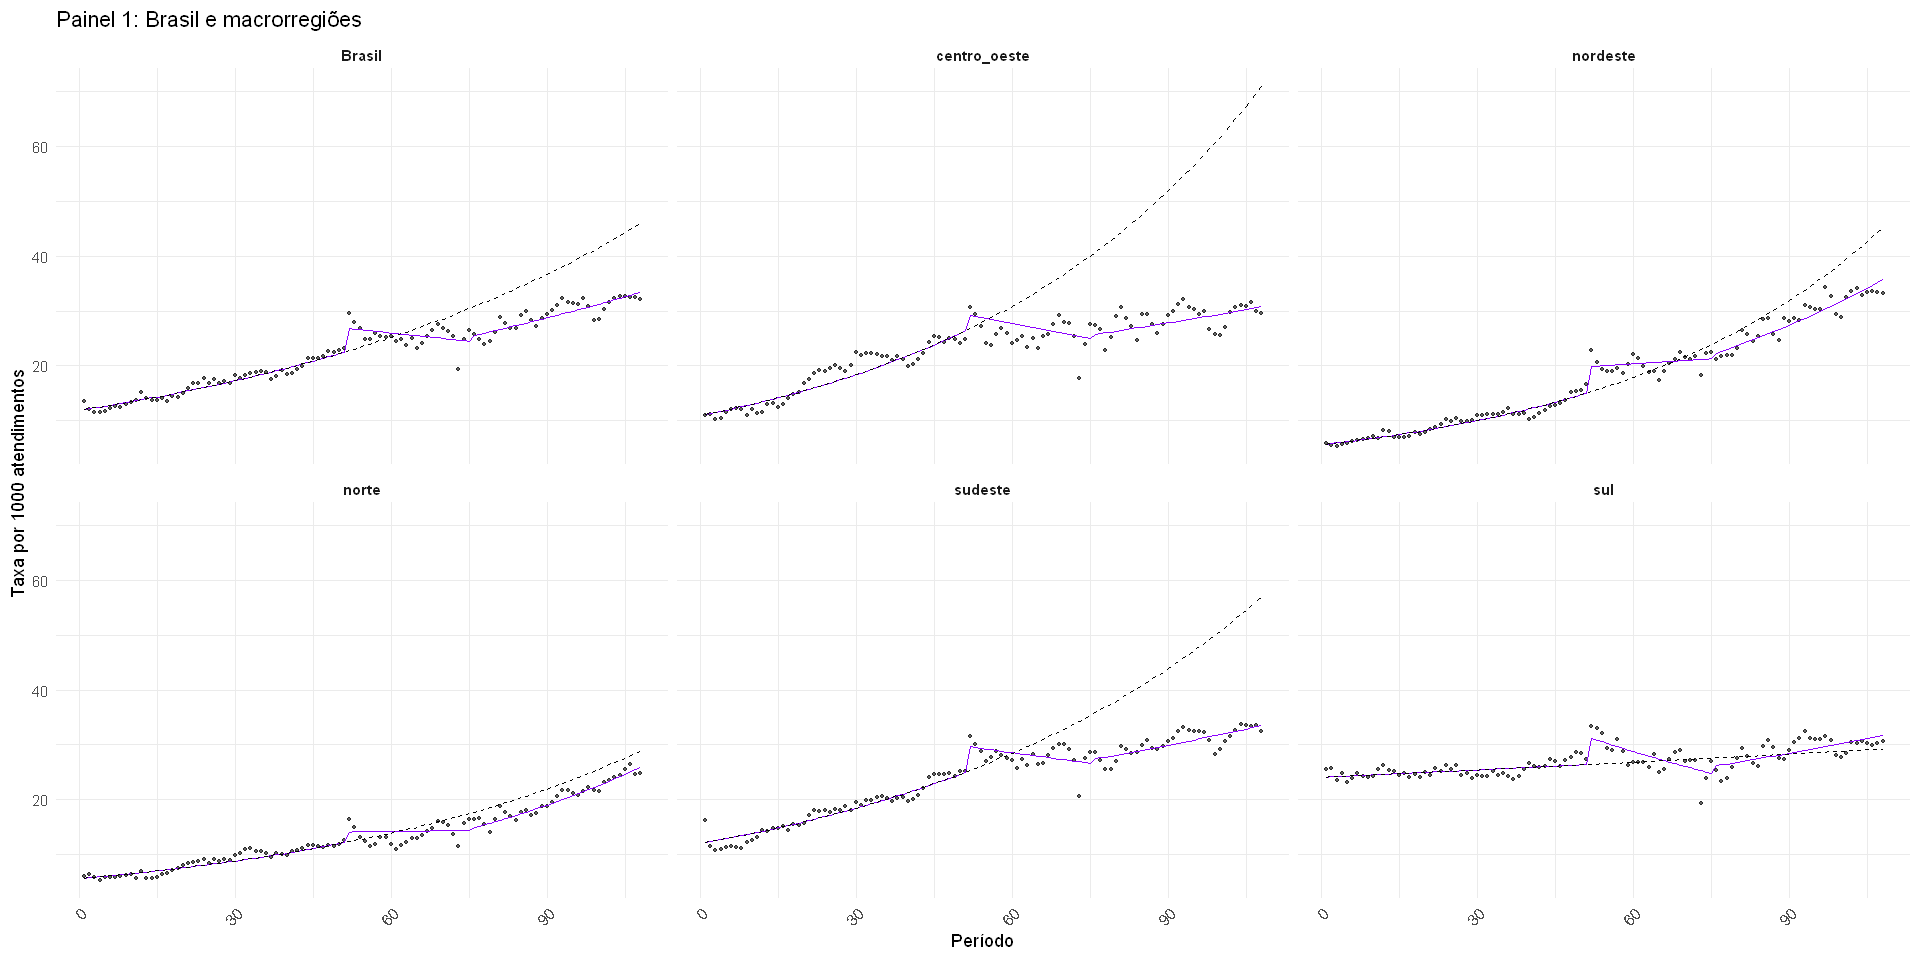

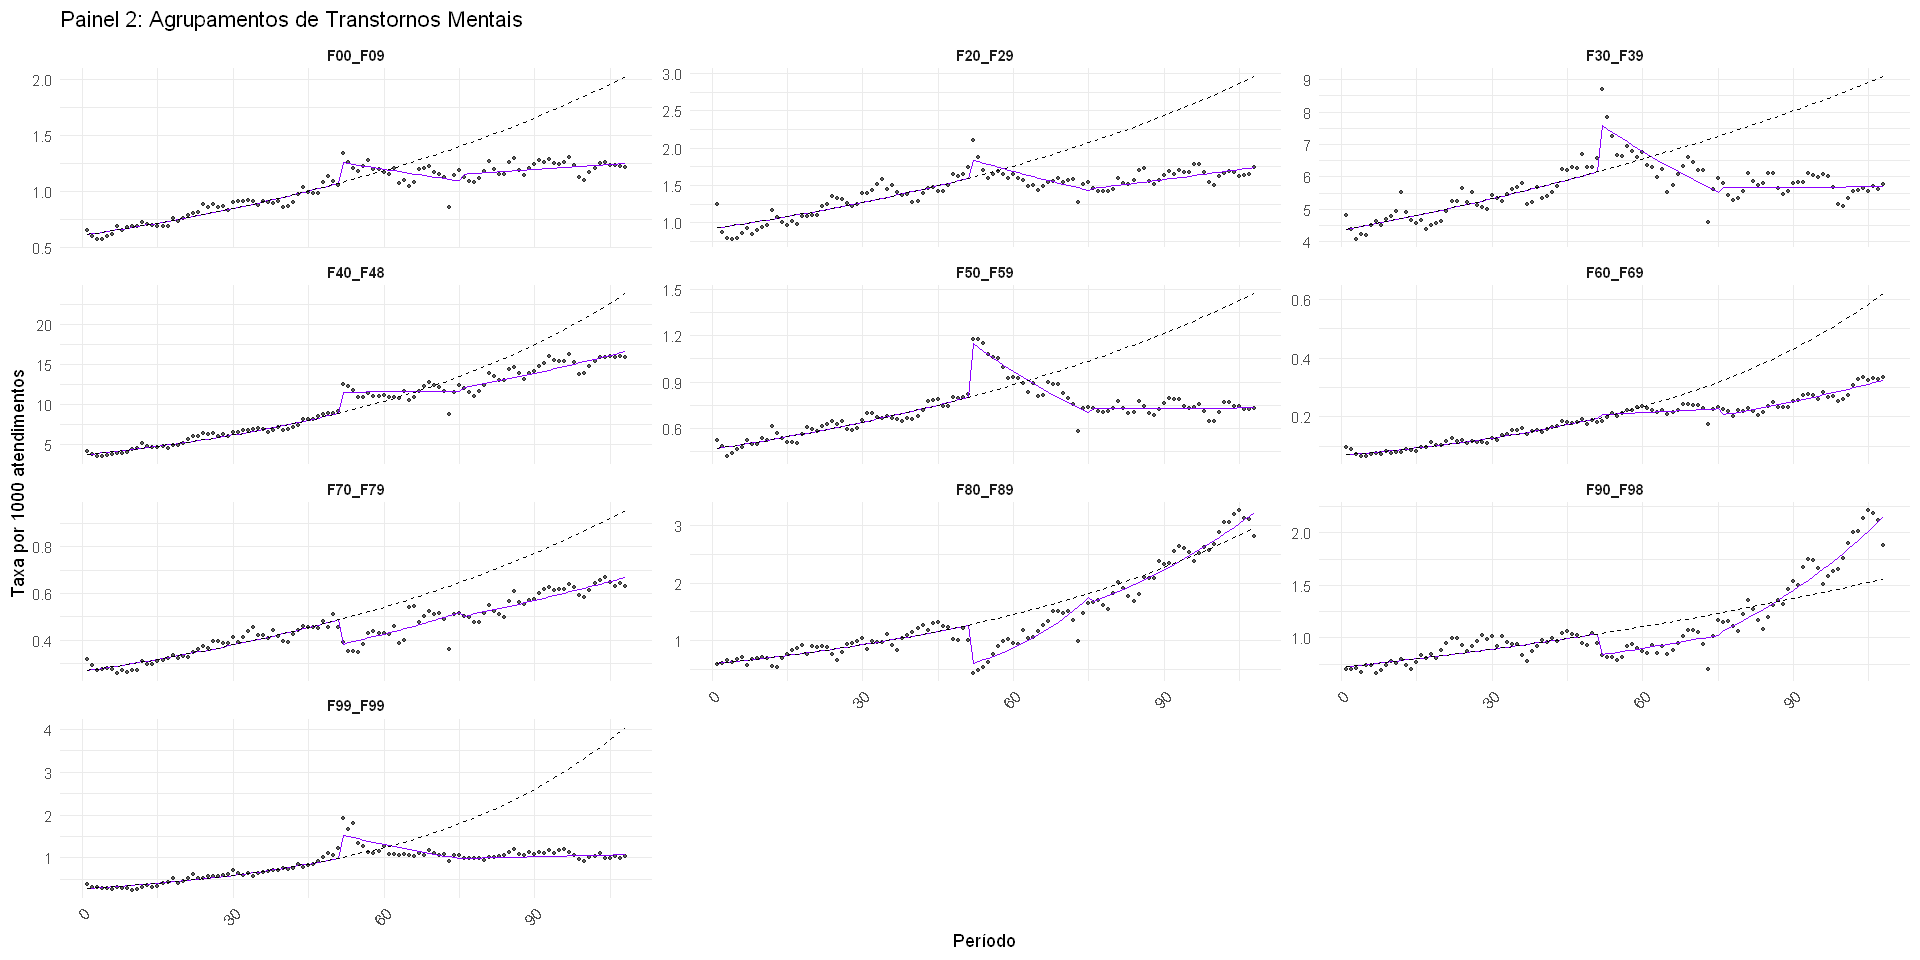

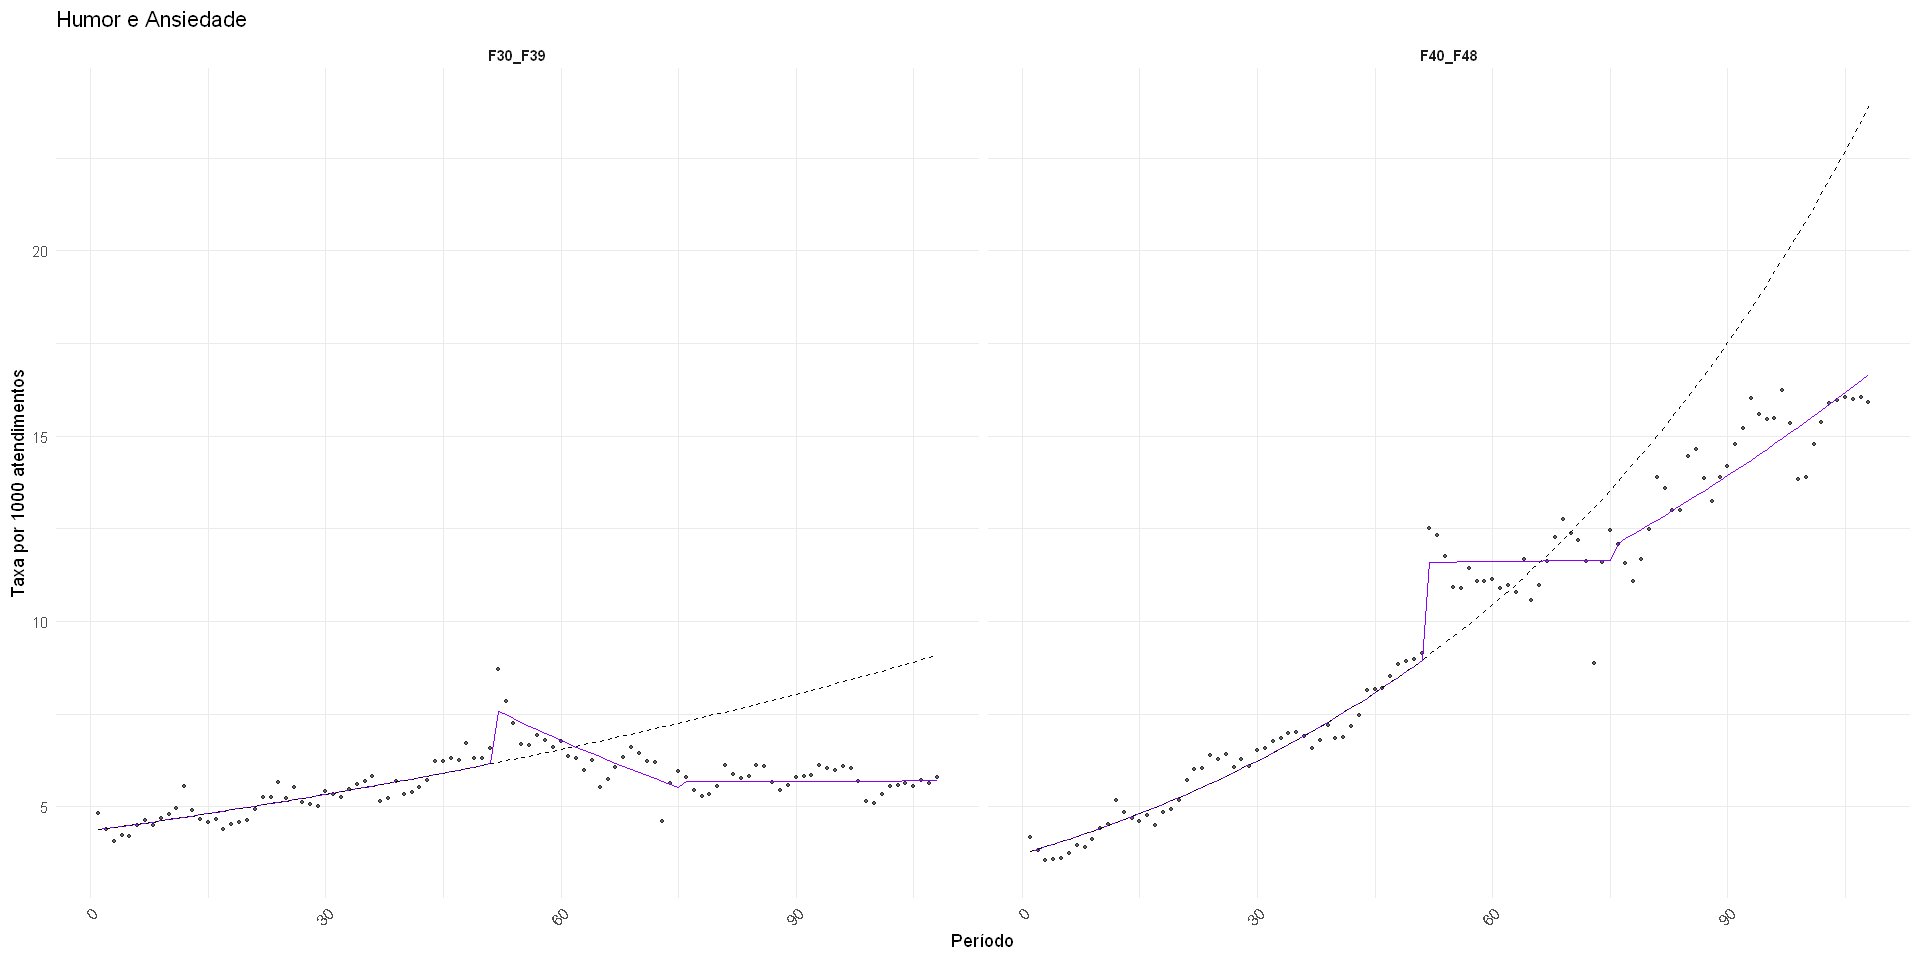

In [60]:
plot_its_painel(painel_1, titulo = "Painel 1: Brasil e macrorregiões", ncol = 3, scales = "fixed")
plot_its_painel(painel_2, titulo = "Painel 2: Agrupamentos de Transtornos Mentais", ncol = 3)
plot_its_painel(painel_neuroticos, titulo = "Humor e Ansiedade", scales = "fixed")


# Plot

Plotando: sul 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Plotando: sudeste 


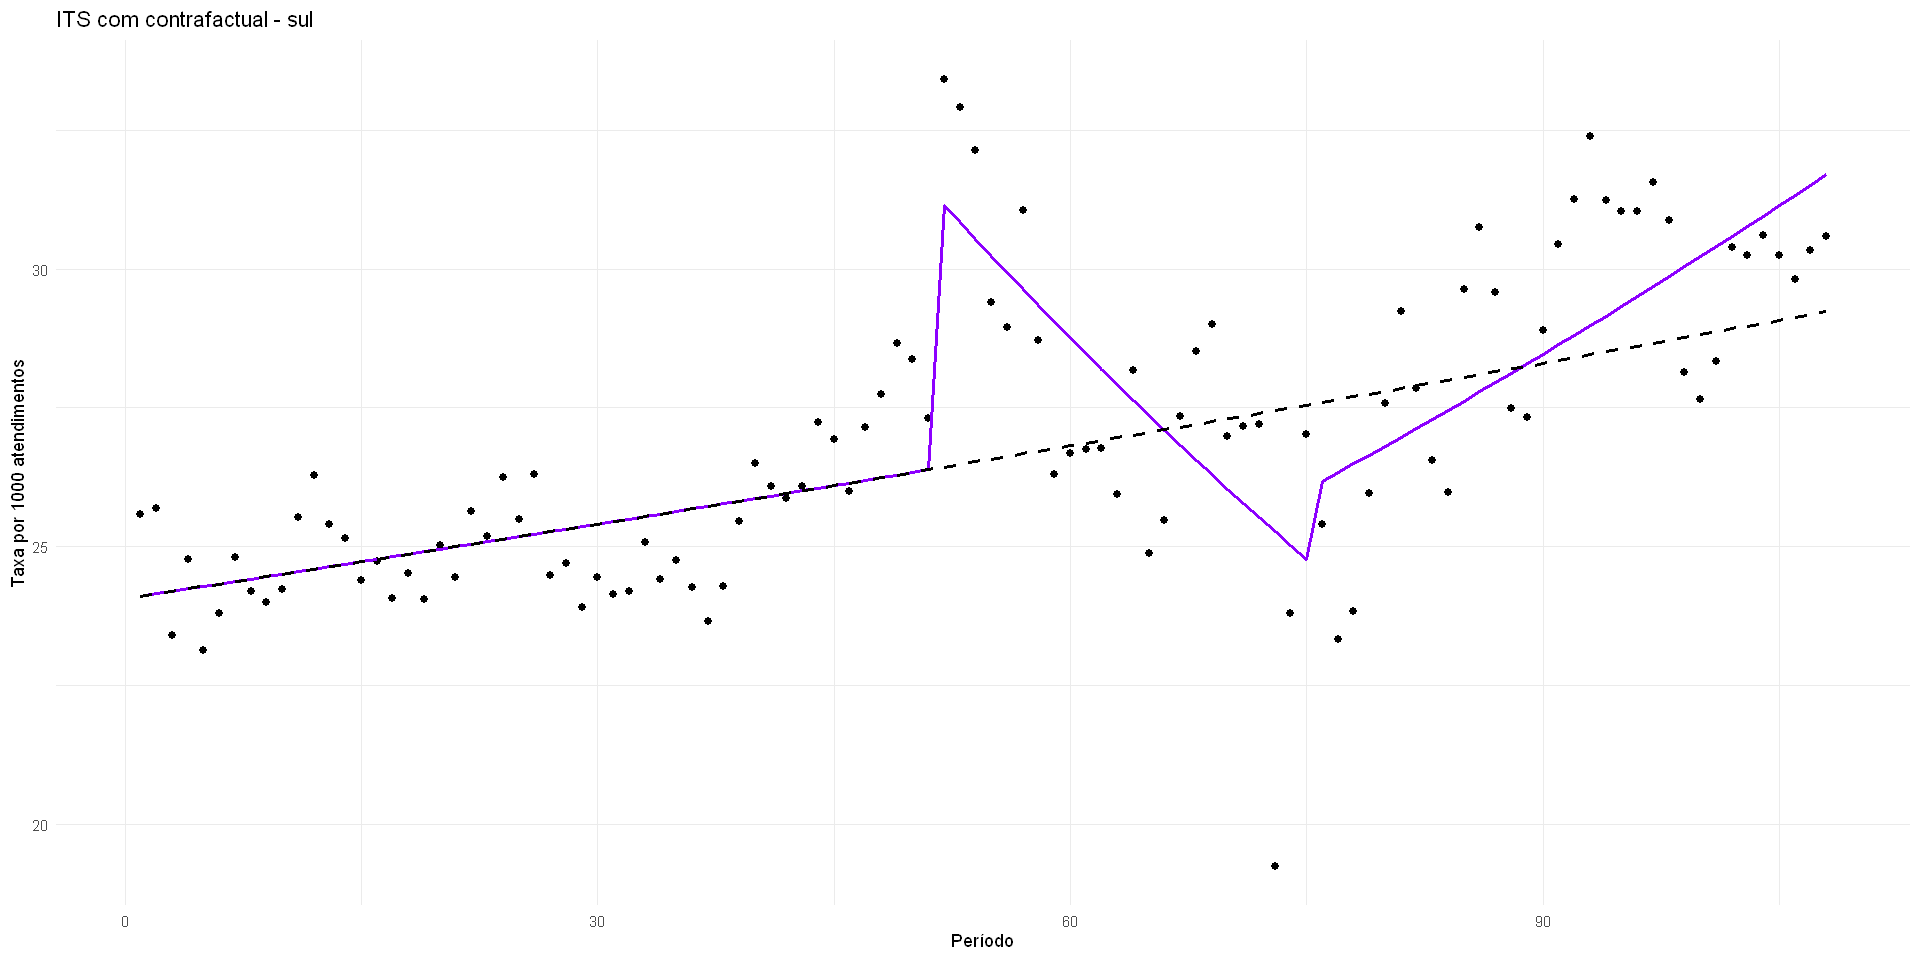

Plotando: norte 


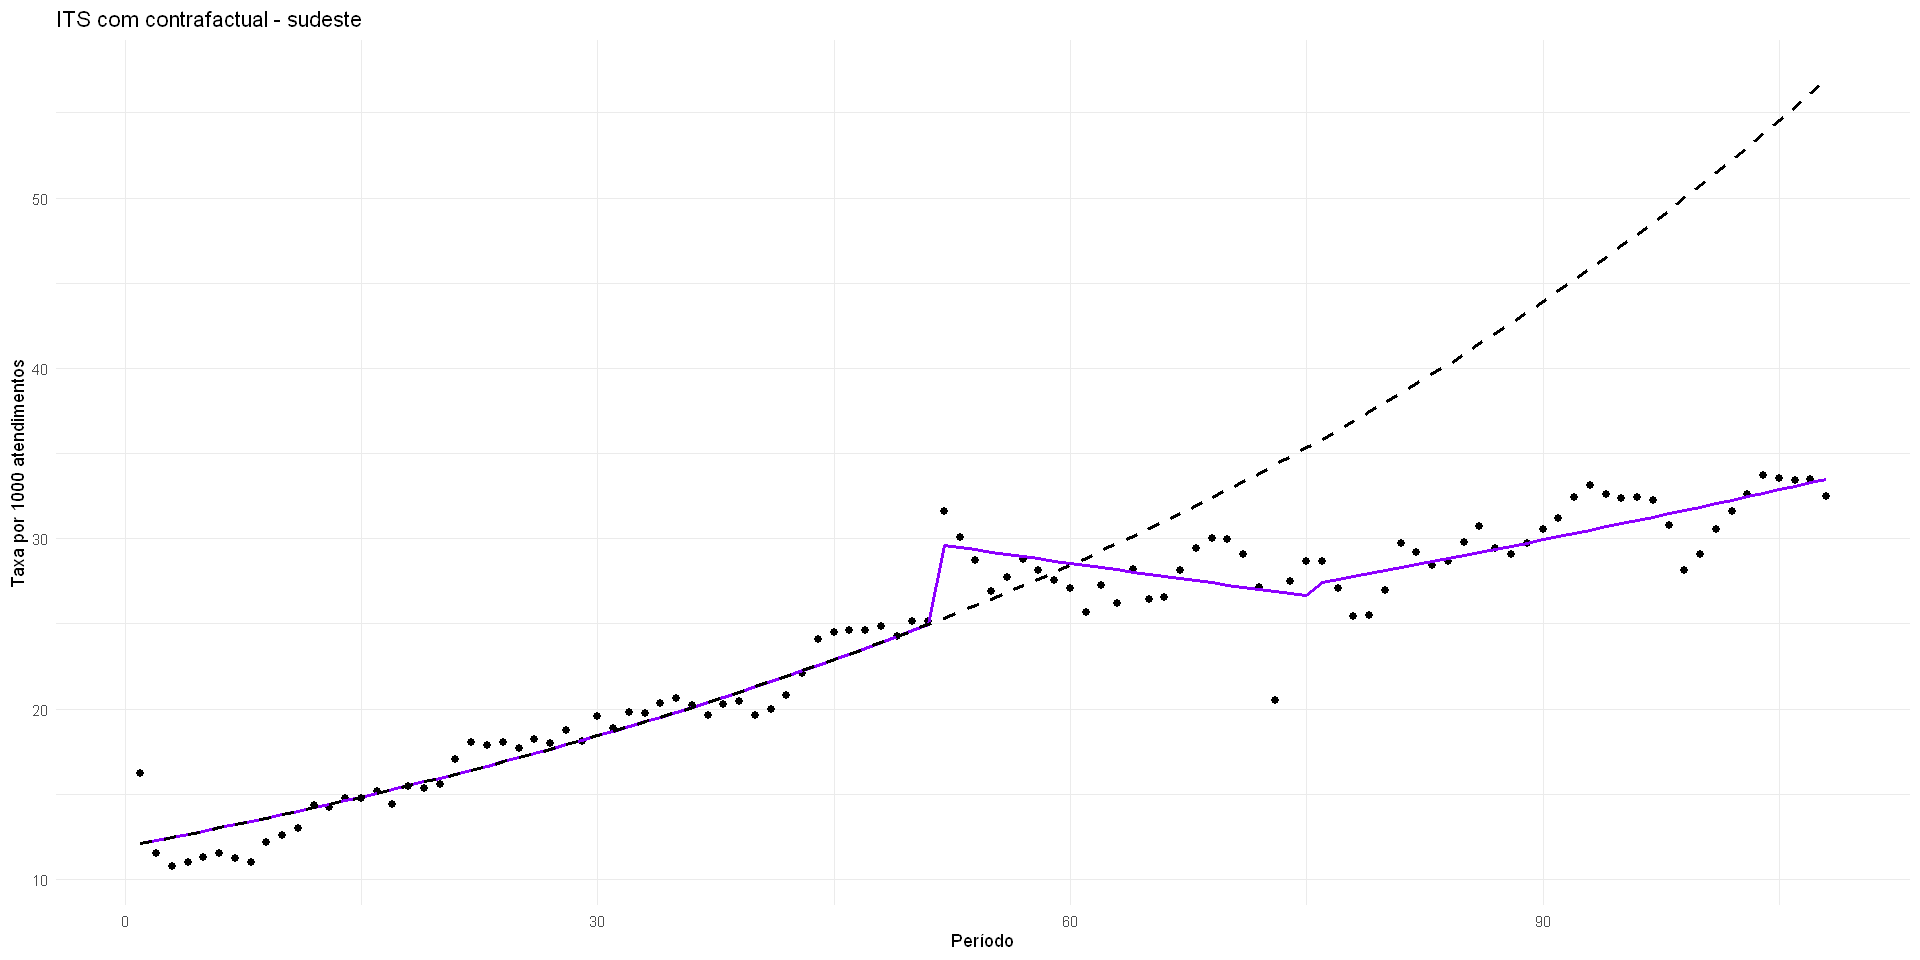

Plotando: nordeste 


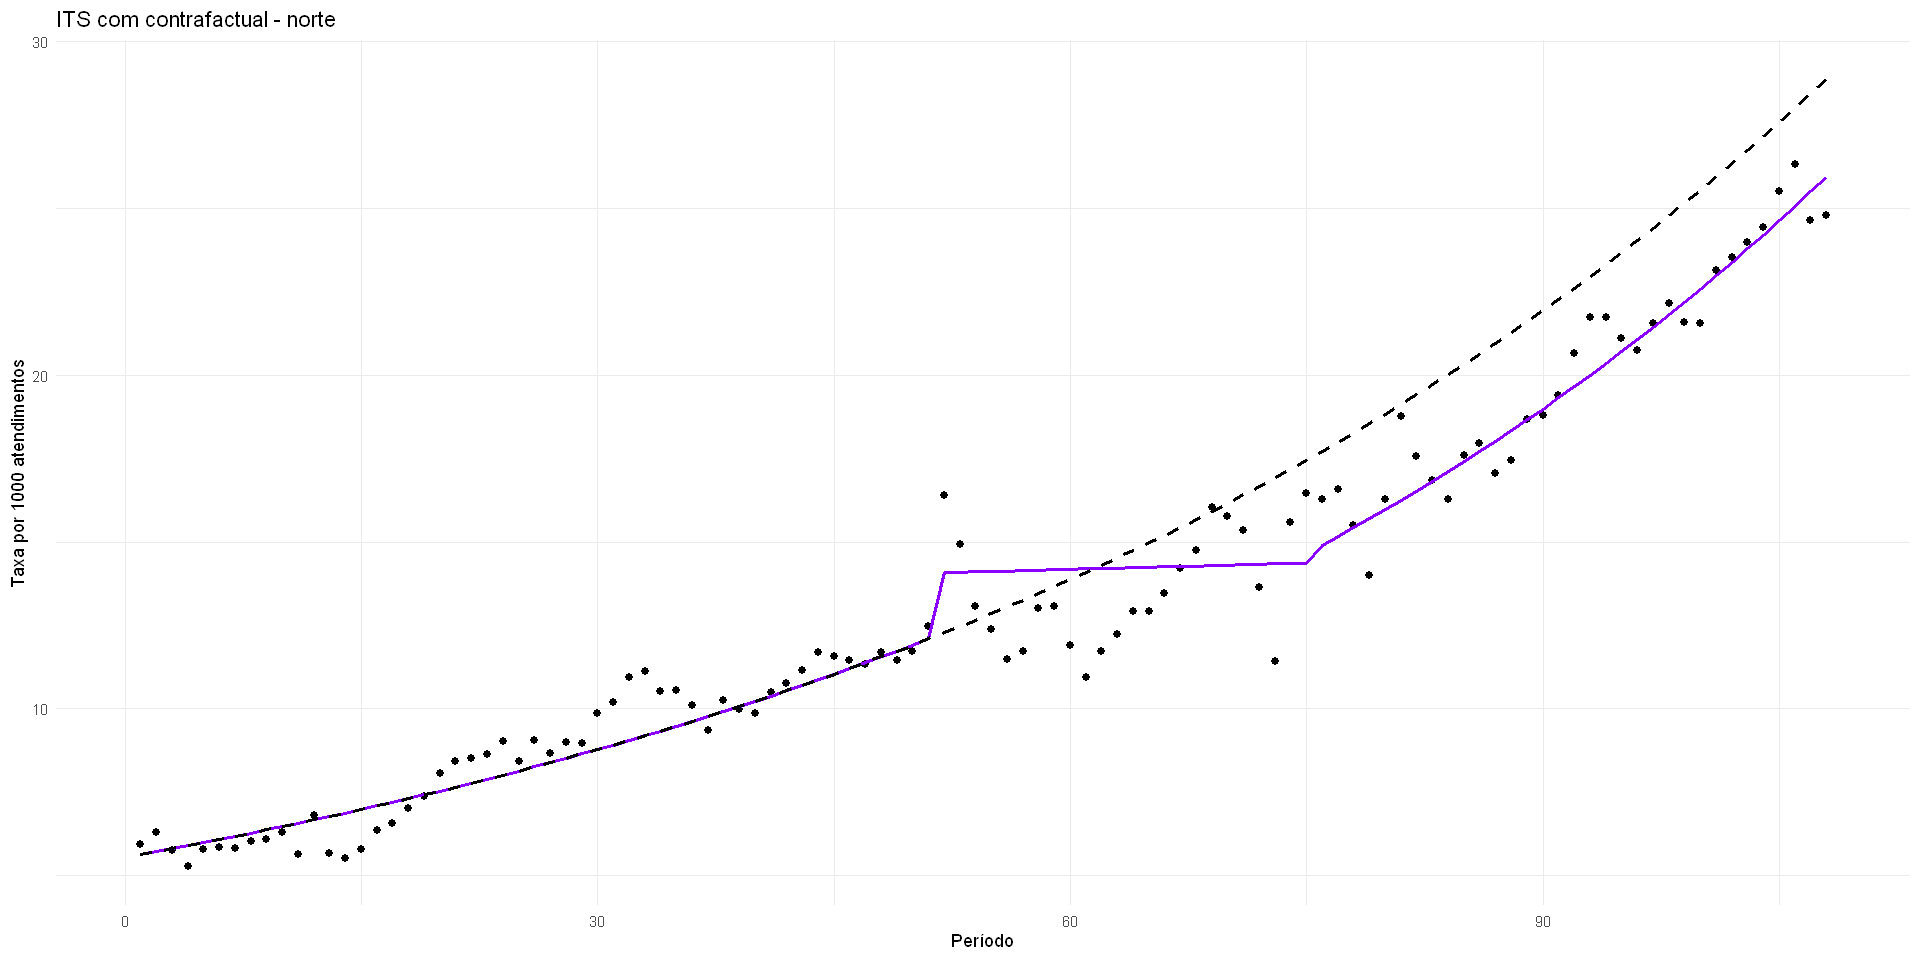

Plotando: centro_oeste 


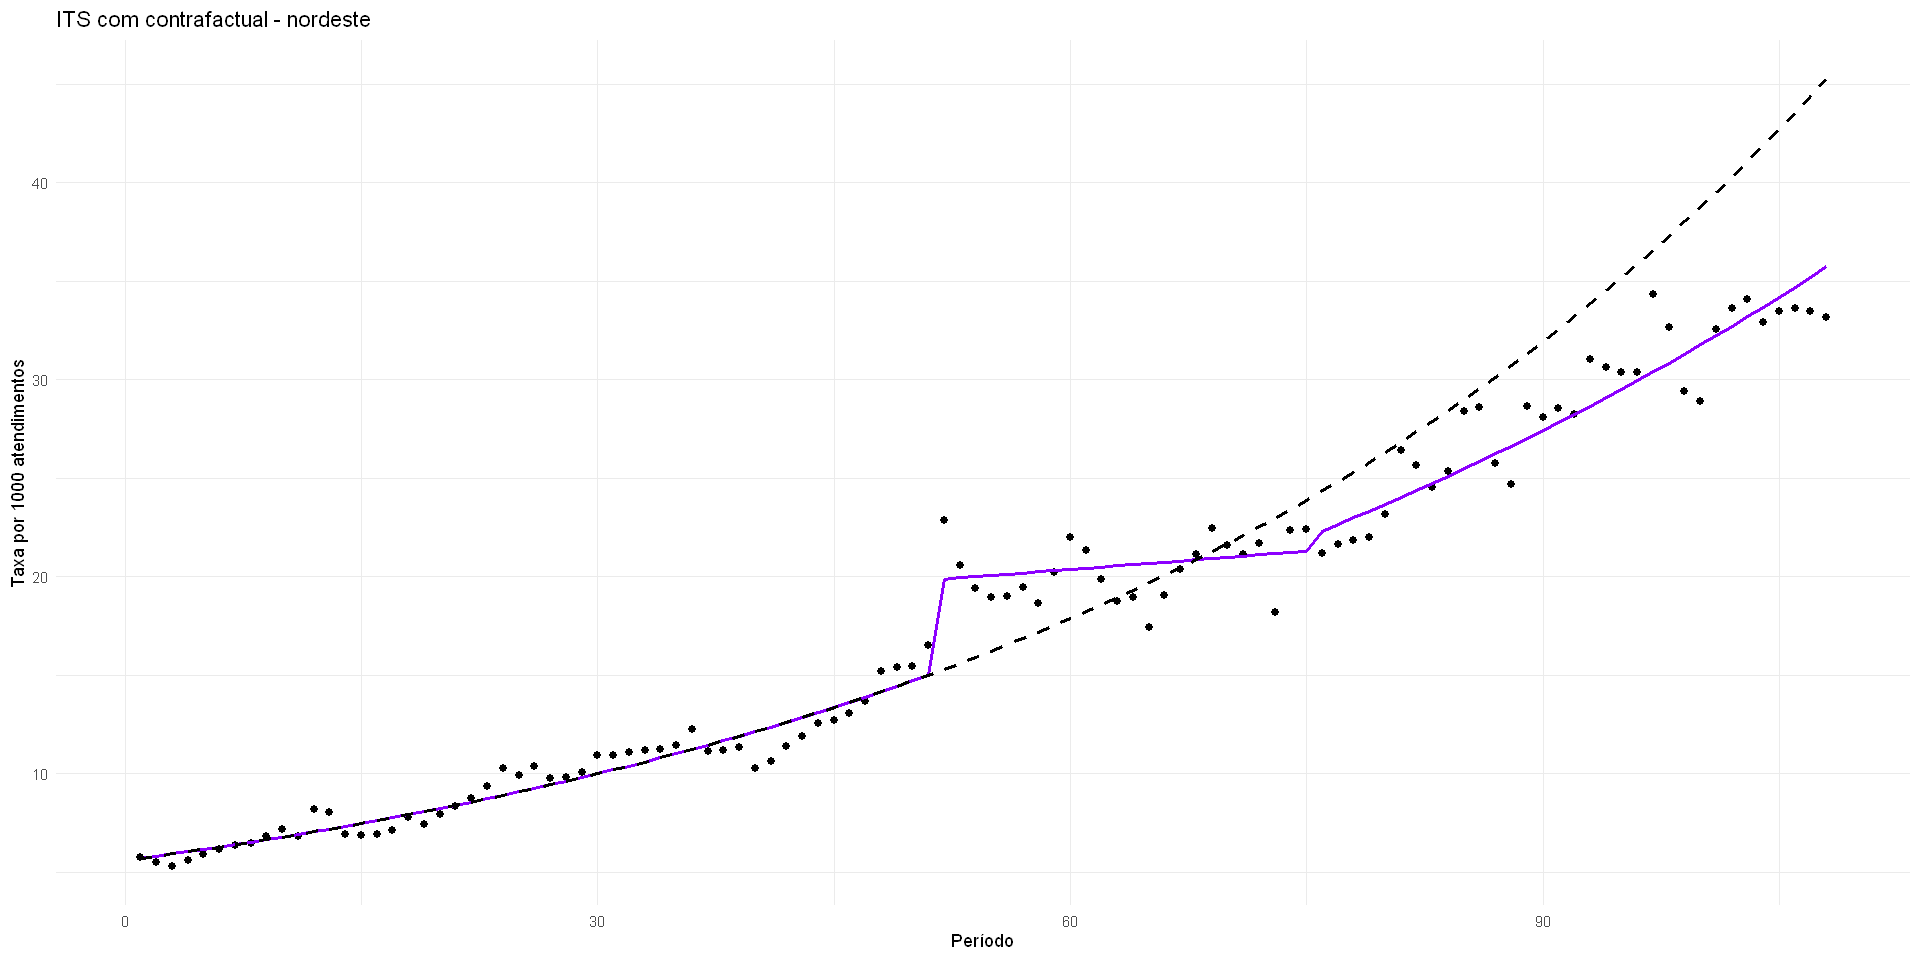

Plotando: F99_F99 


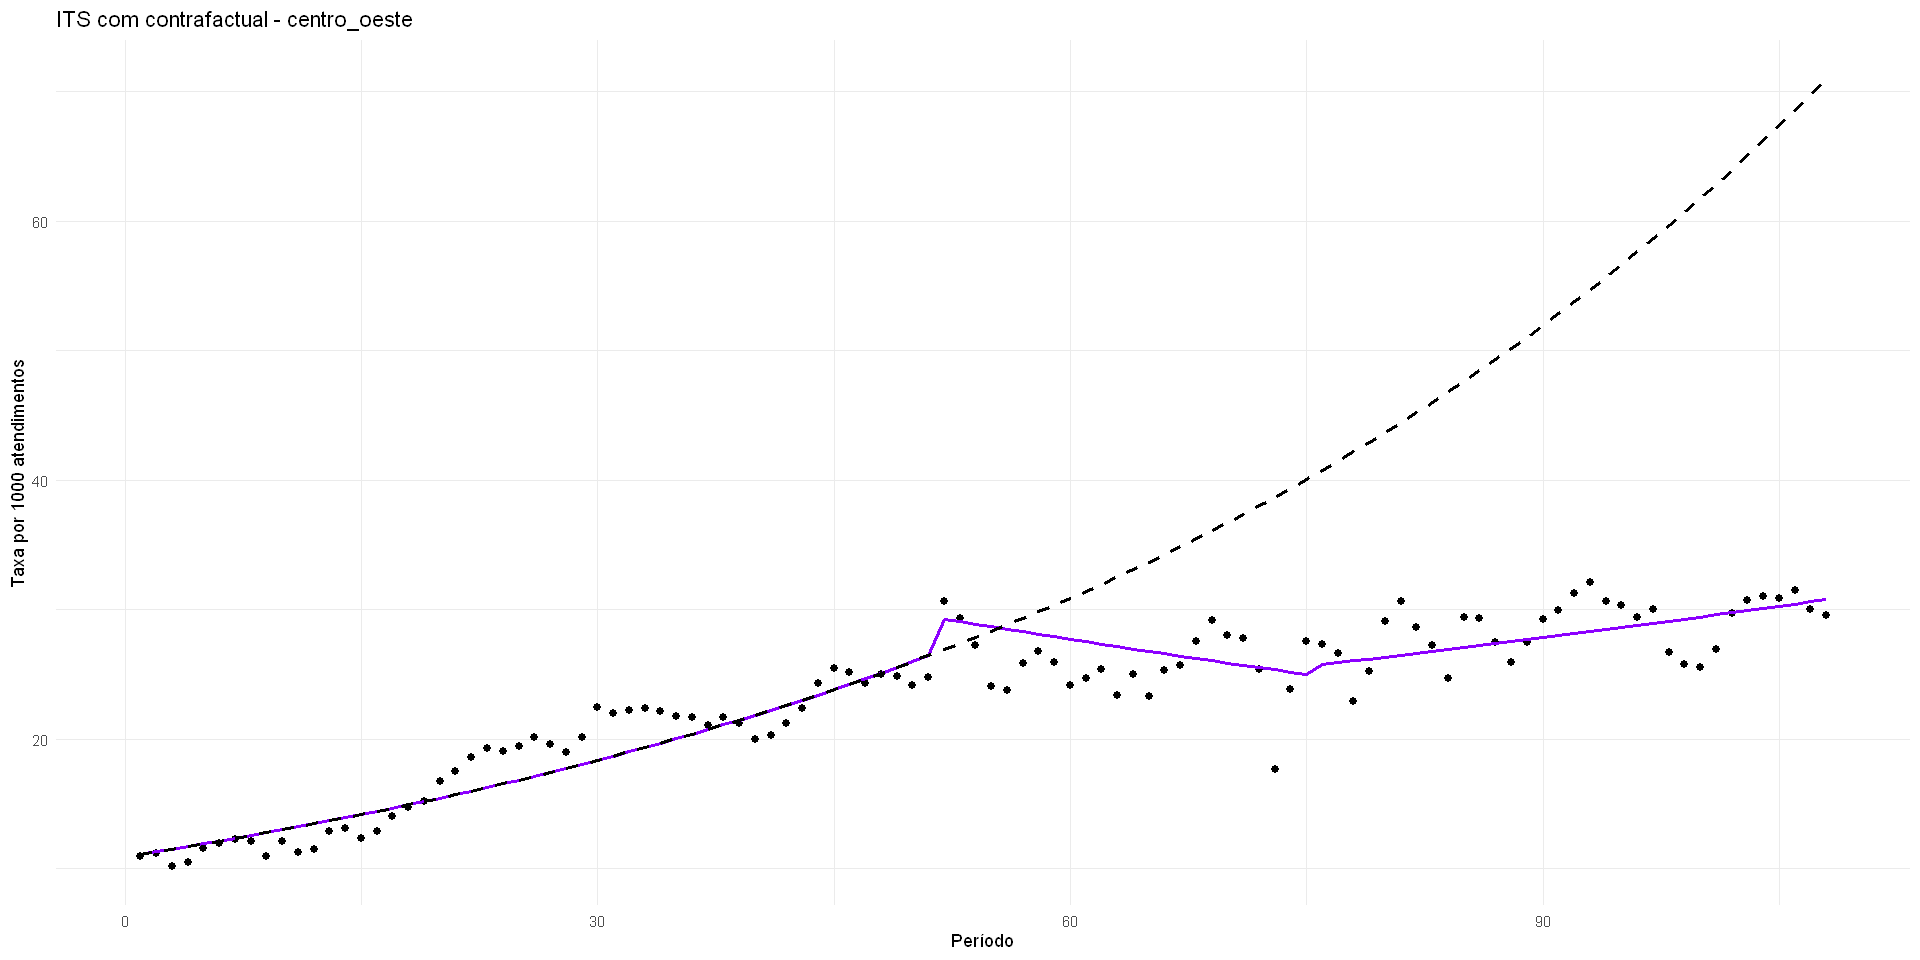

Plotando: F90_F98 


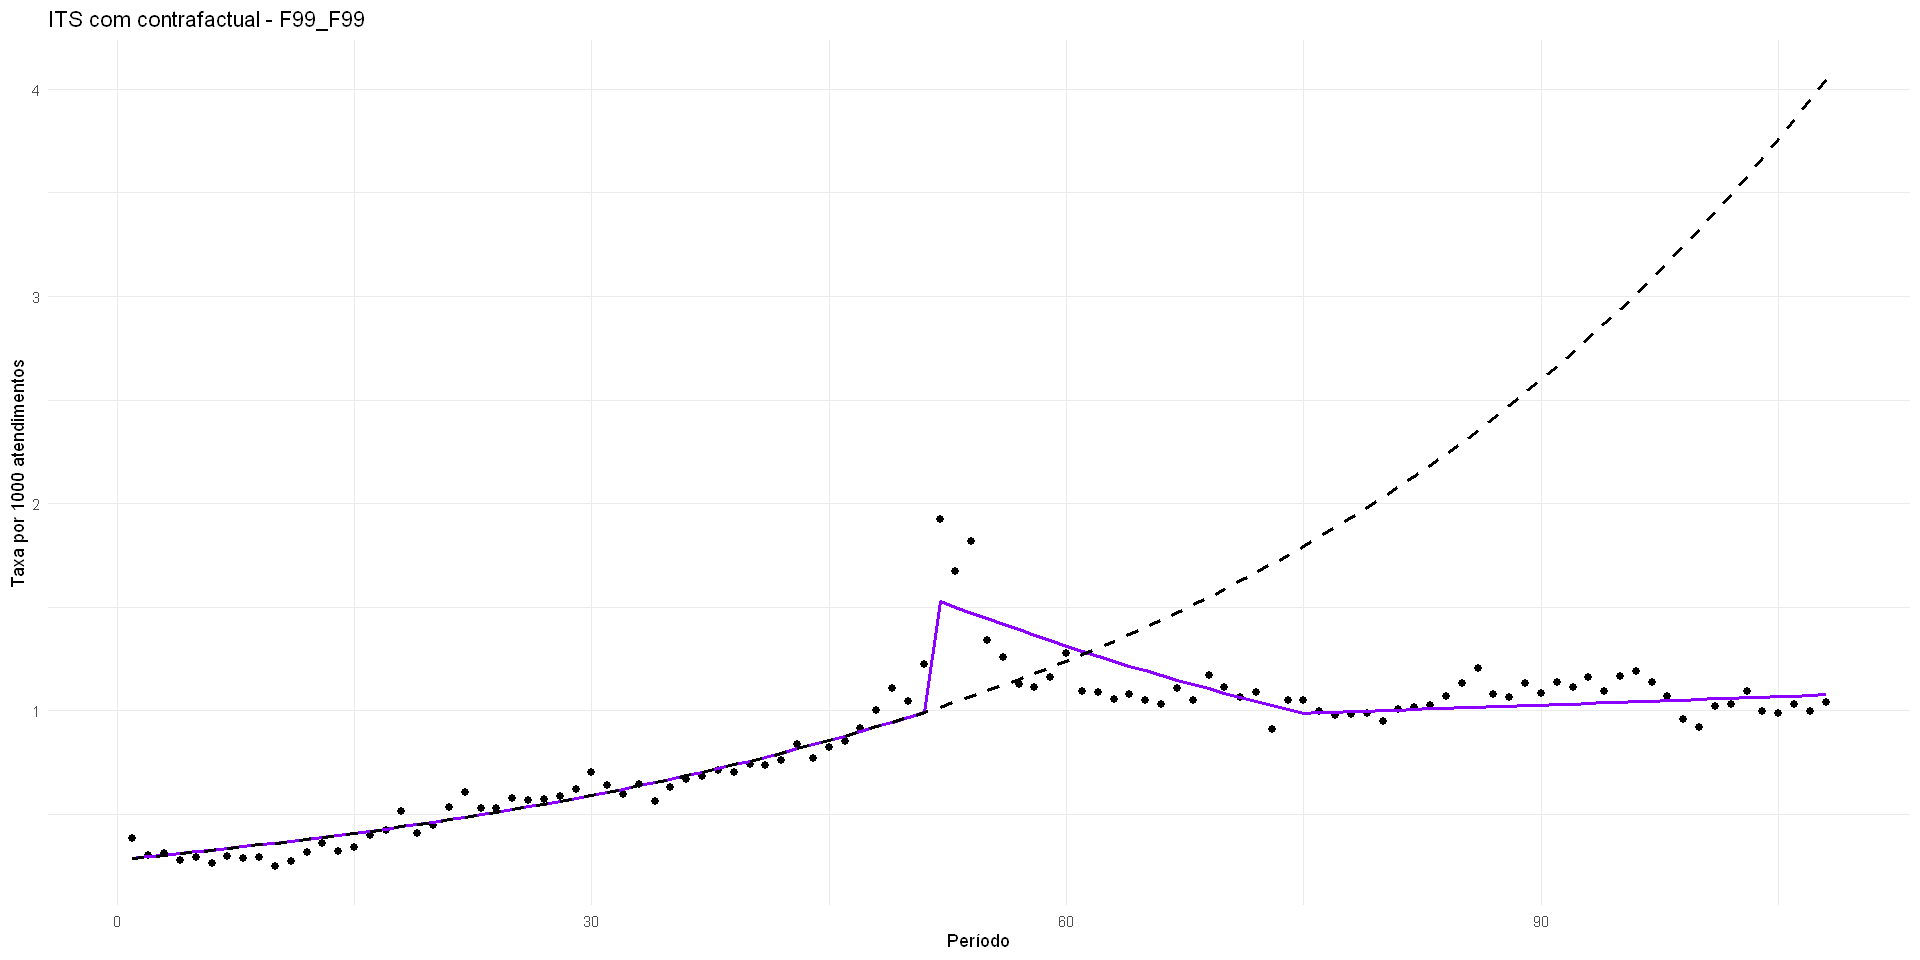

Plotando: F80_F89 


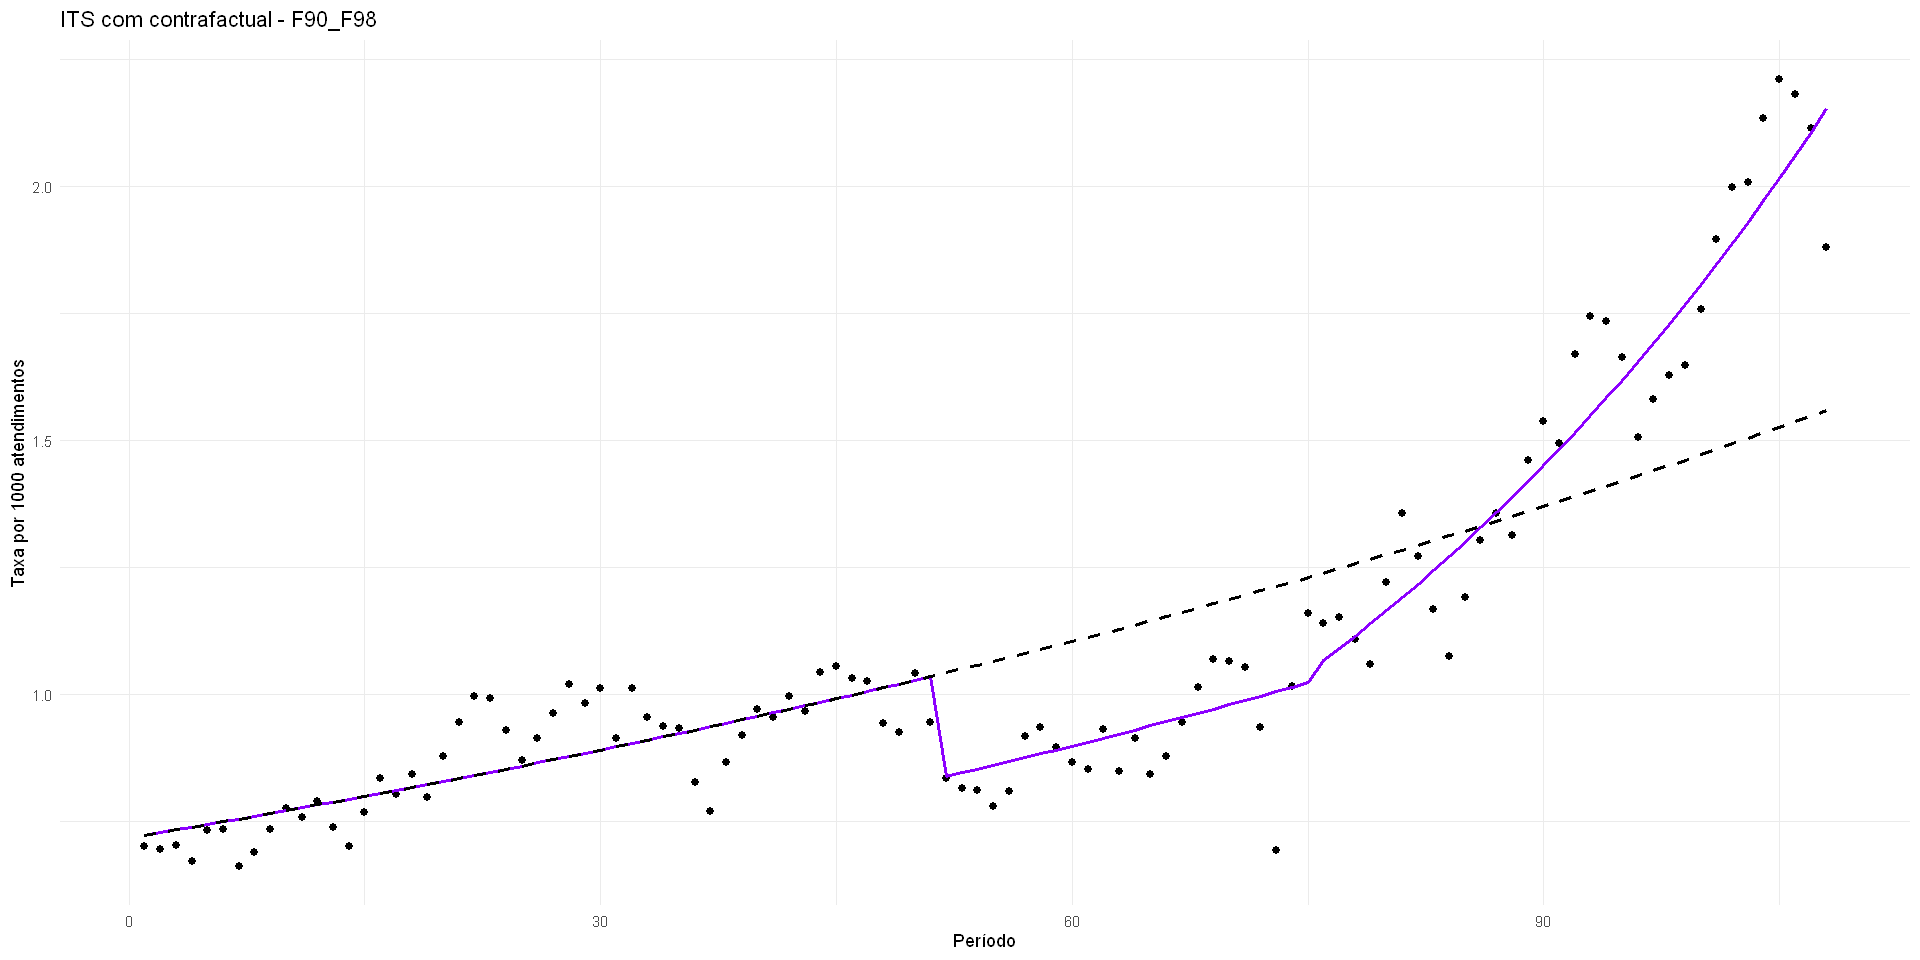

Plotando: F70_F79 


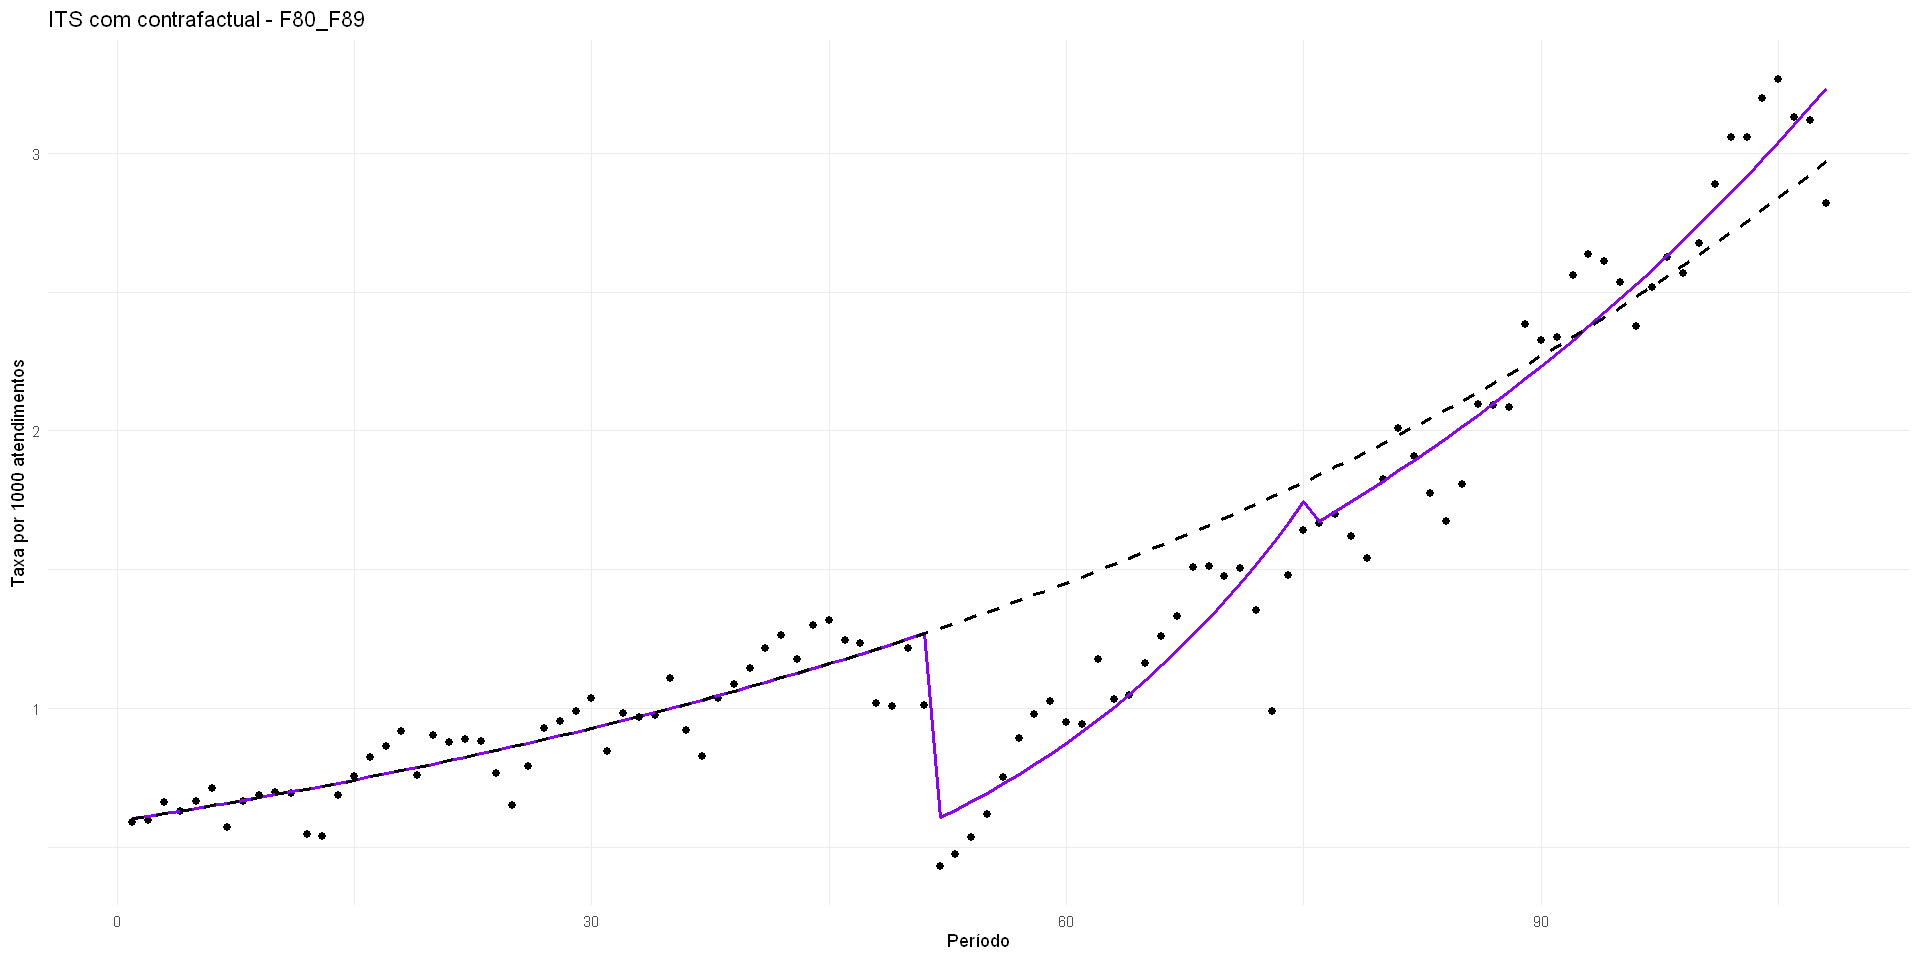

Plotando: F60_F69 


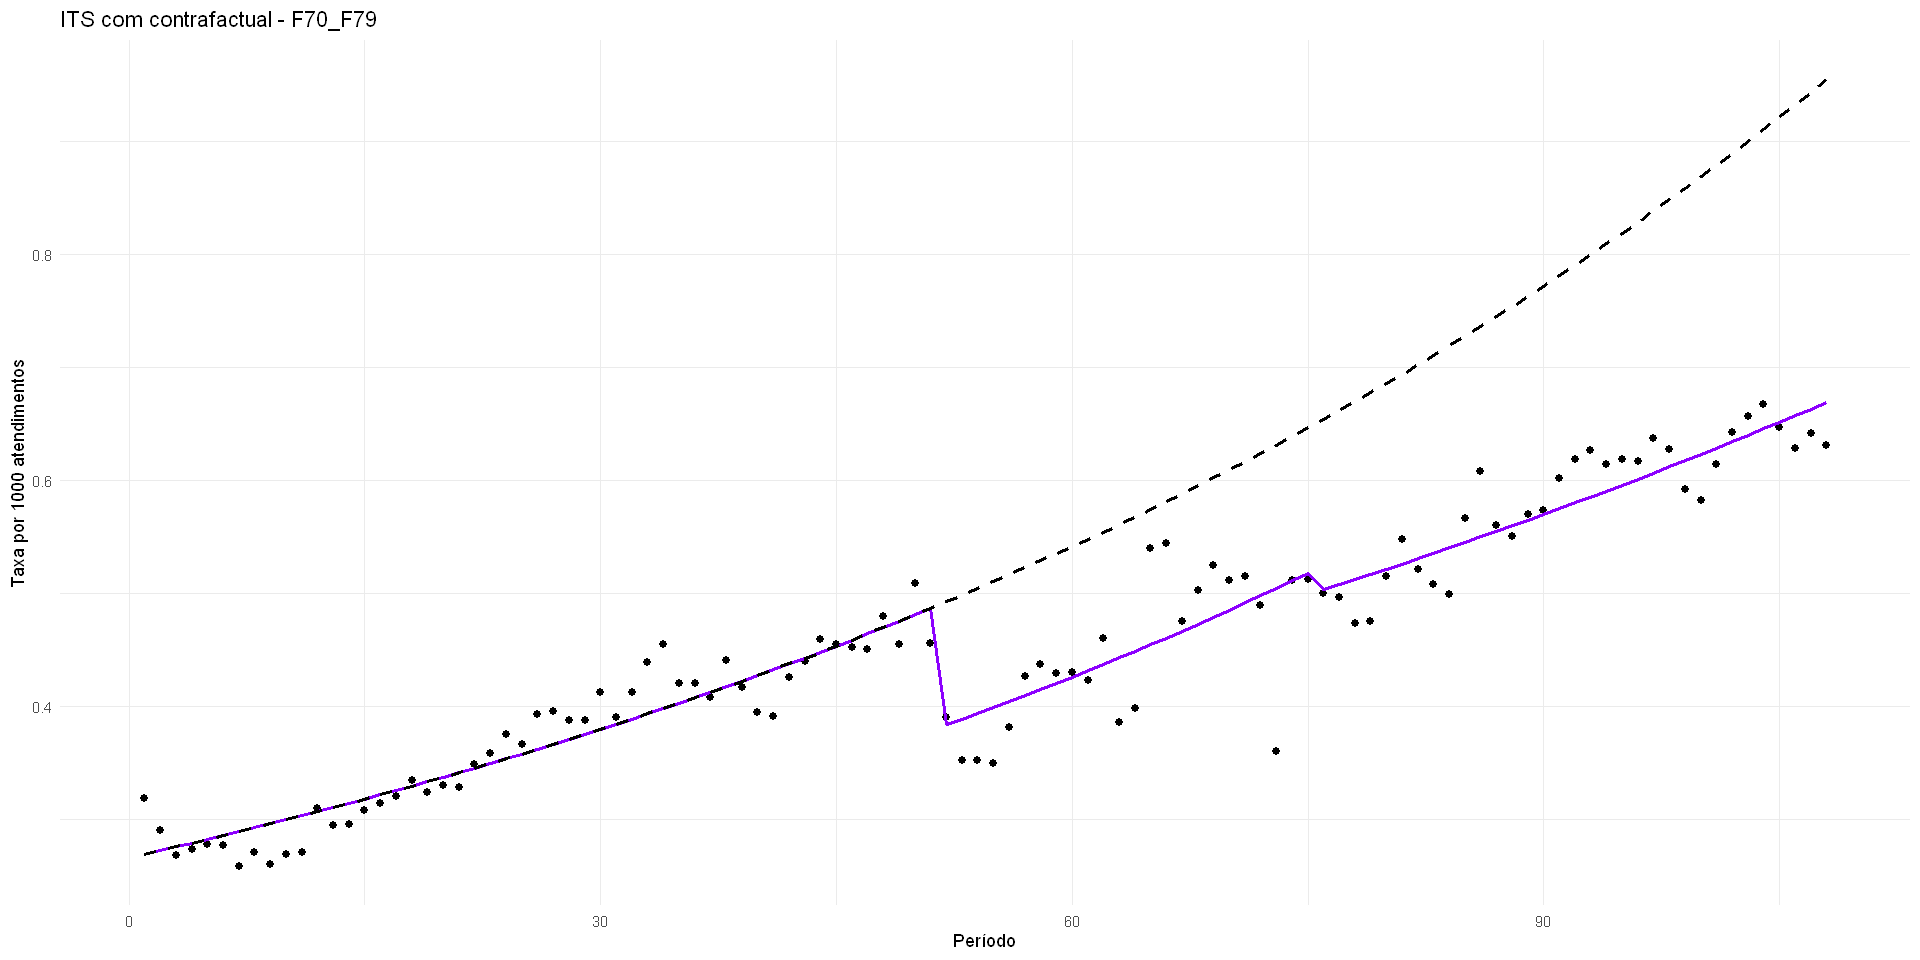

Plotando: F50_F59 


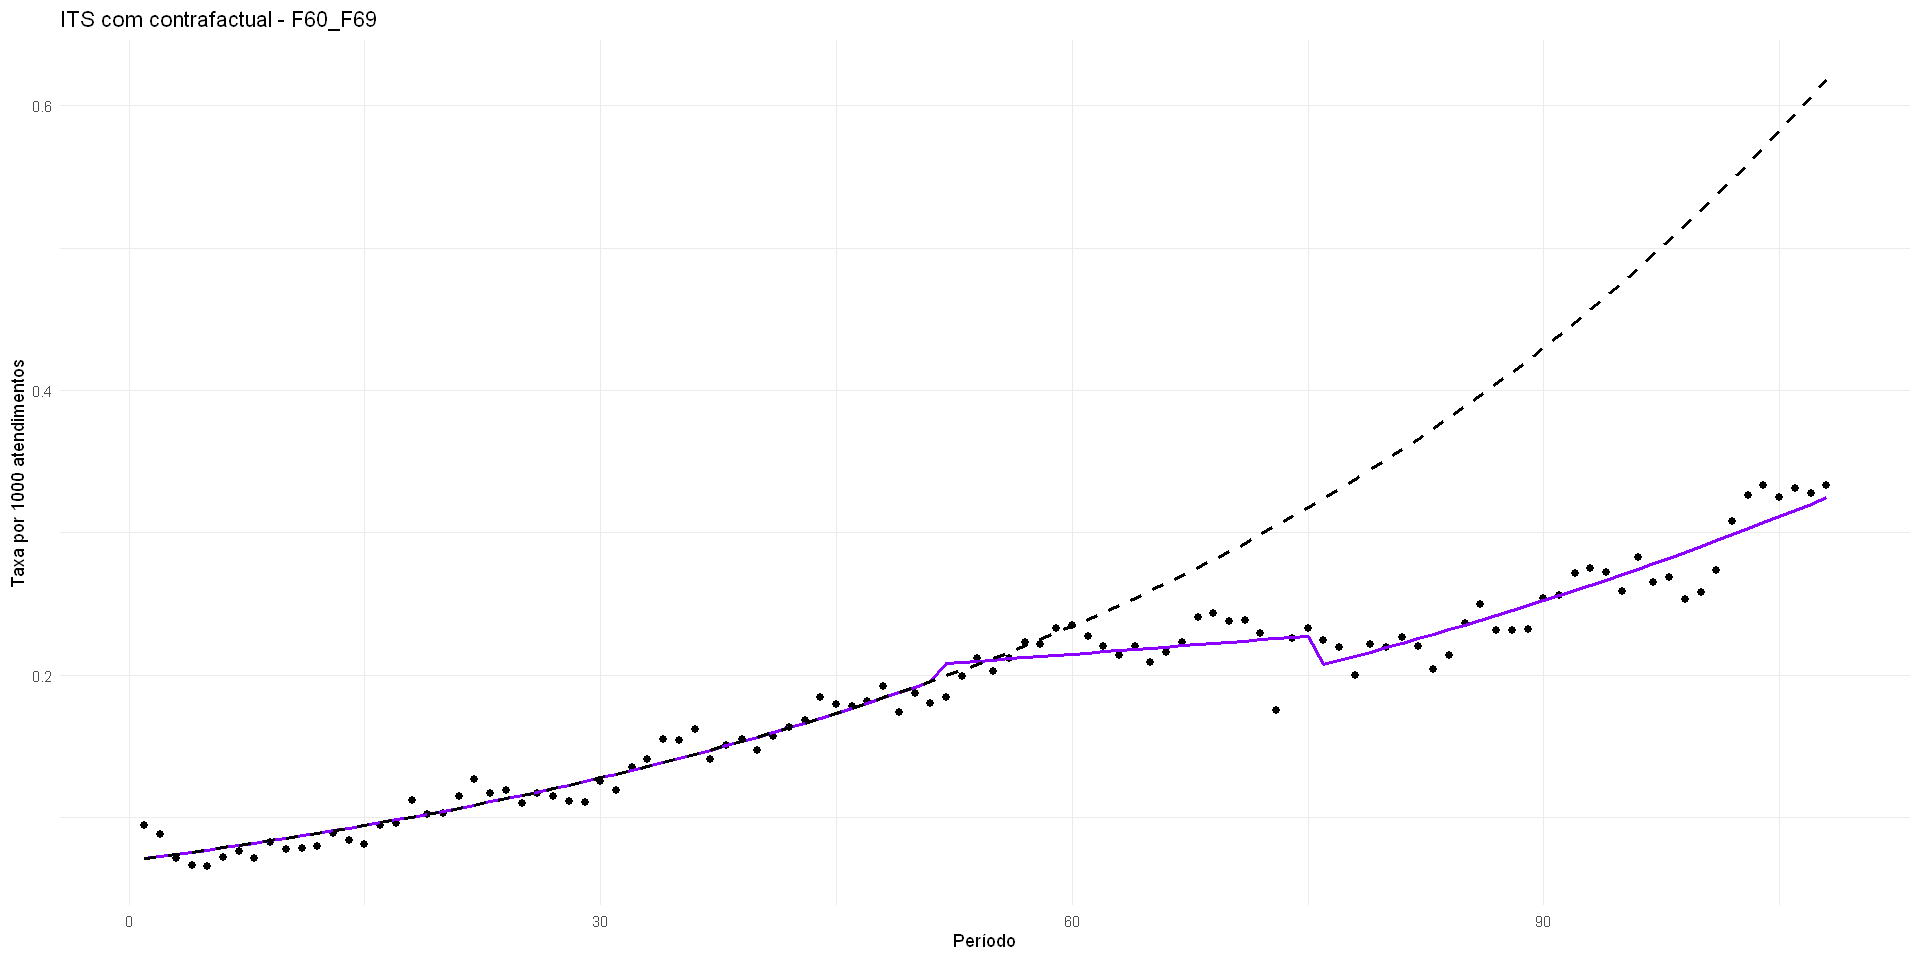

Plotando: F40_F48 


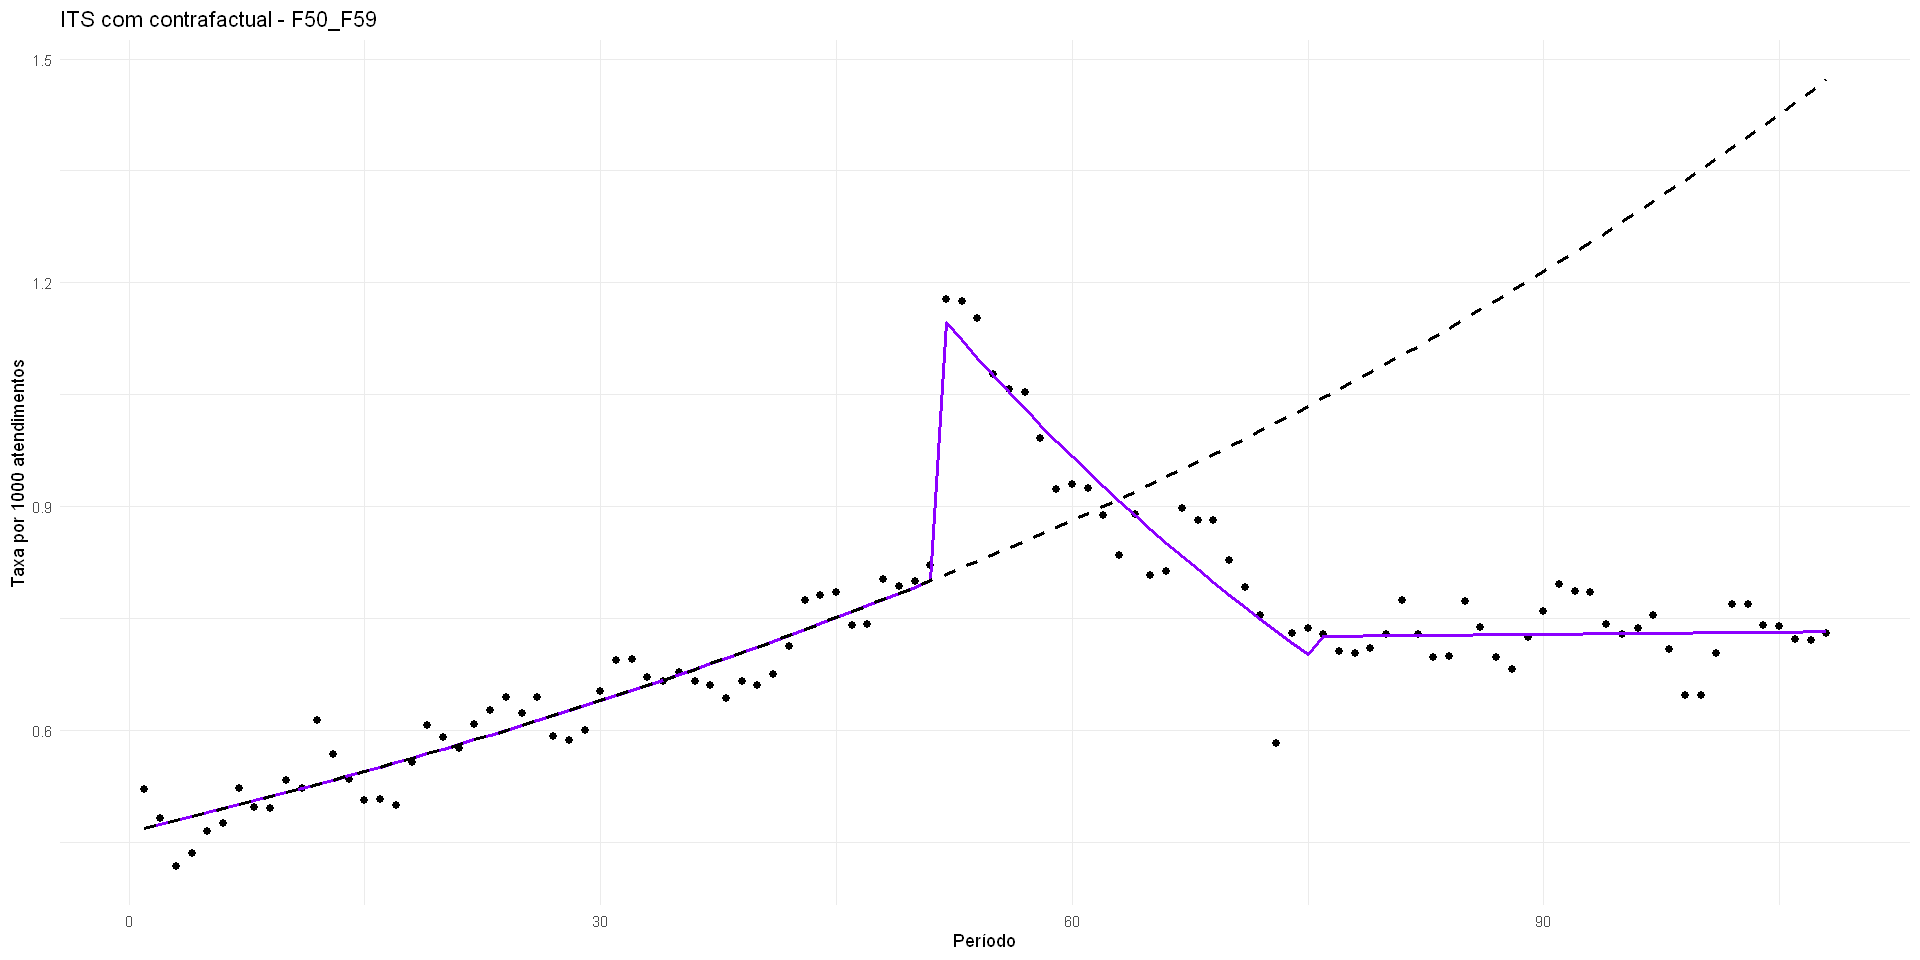

Plotando: F30_F39 


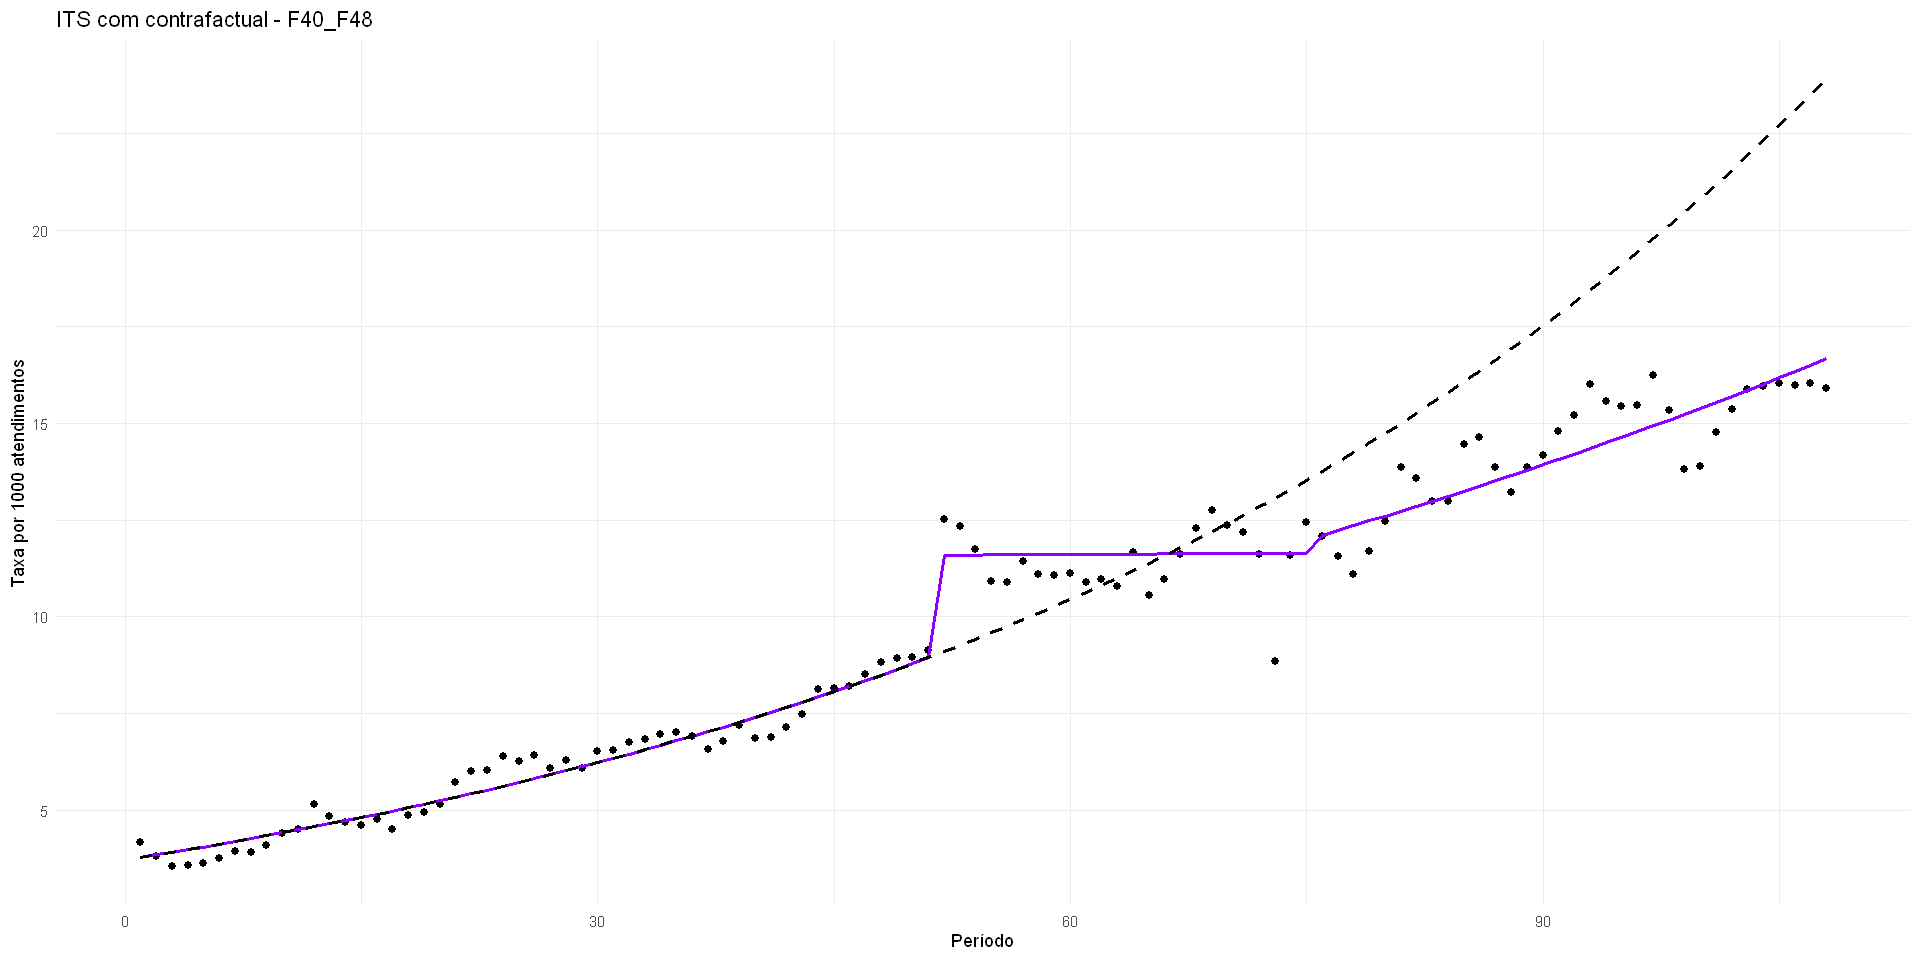

Plotando: F20_F29 


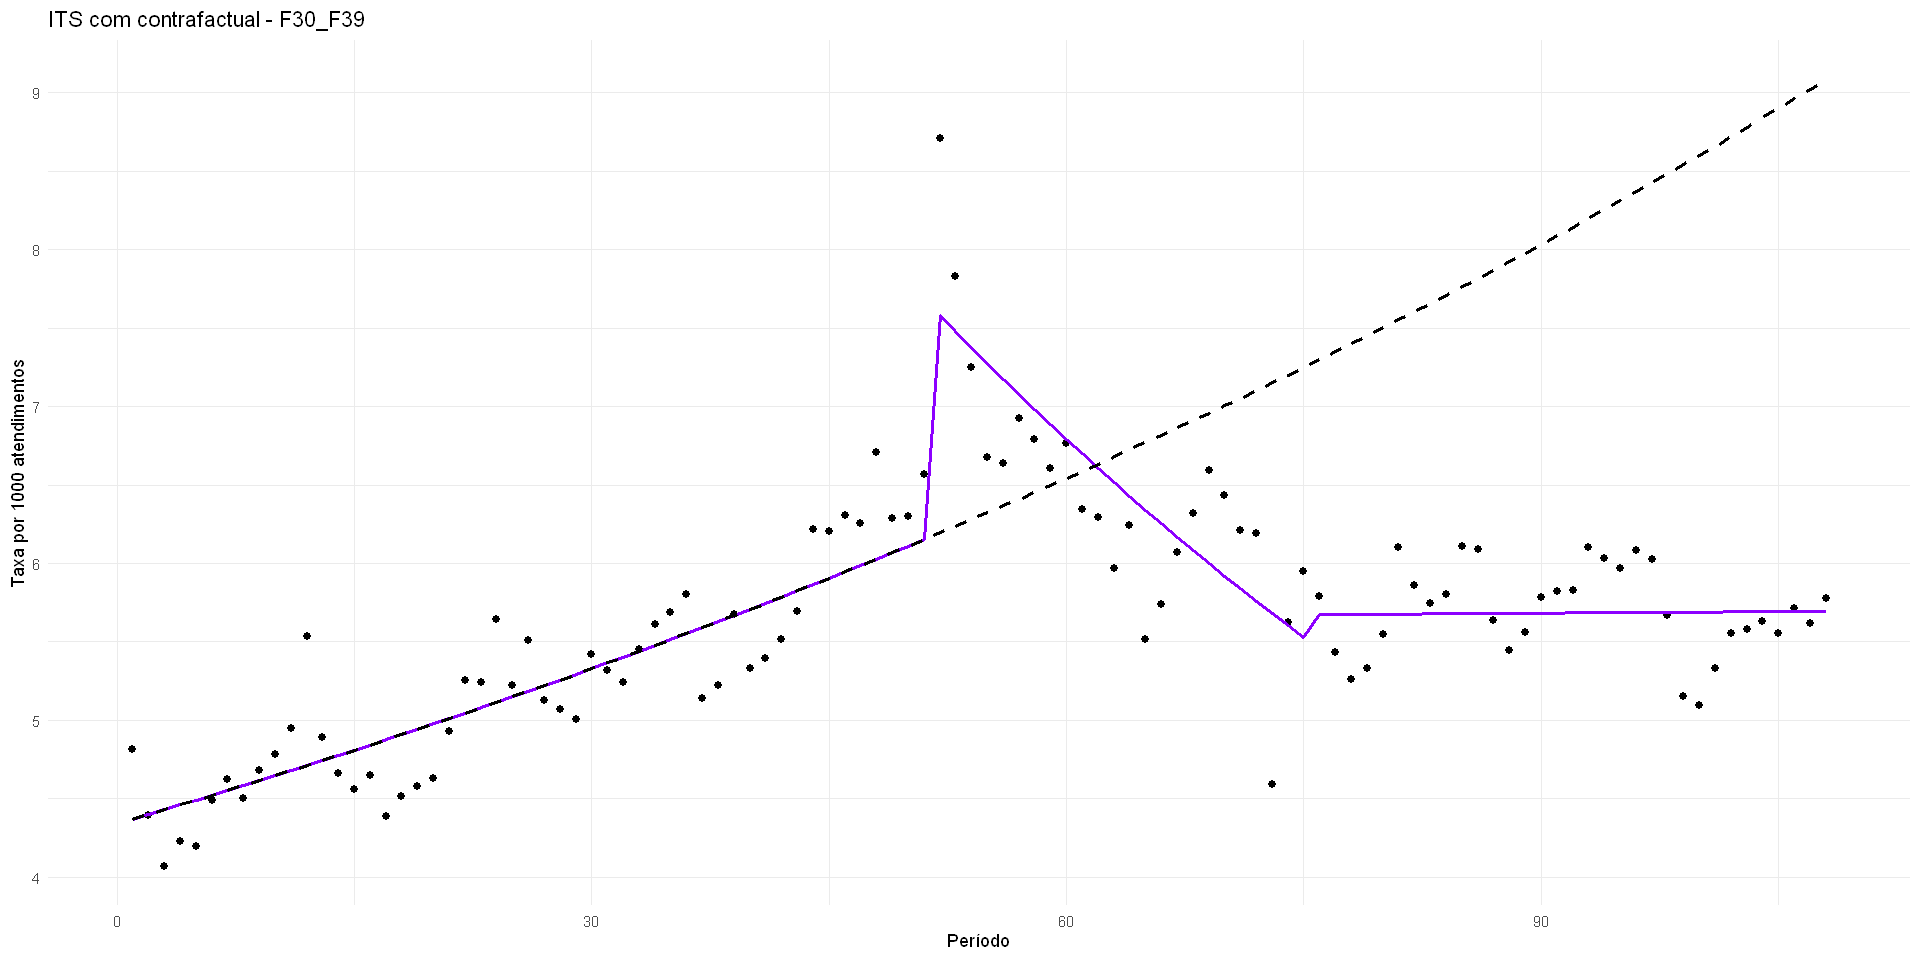

Plotando: F00_F09 


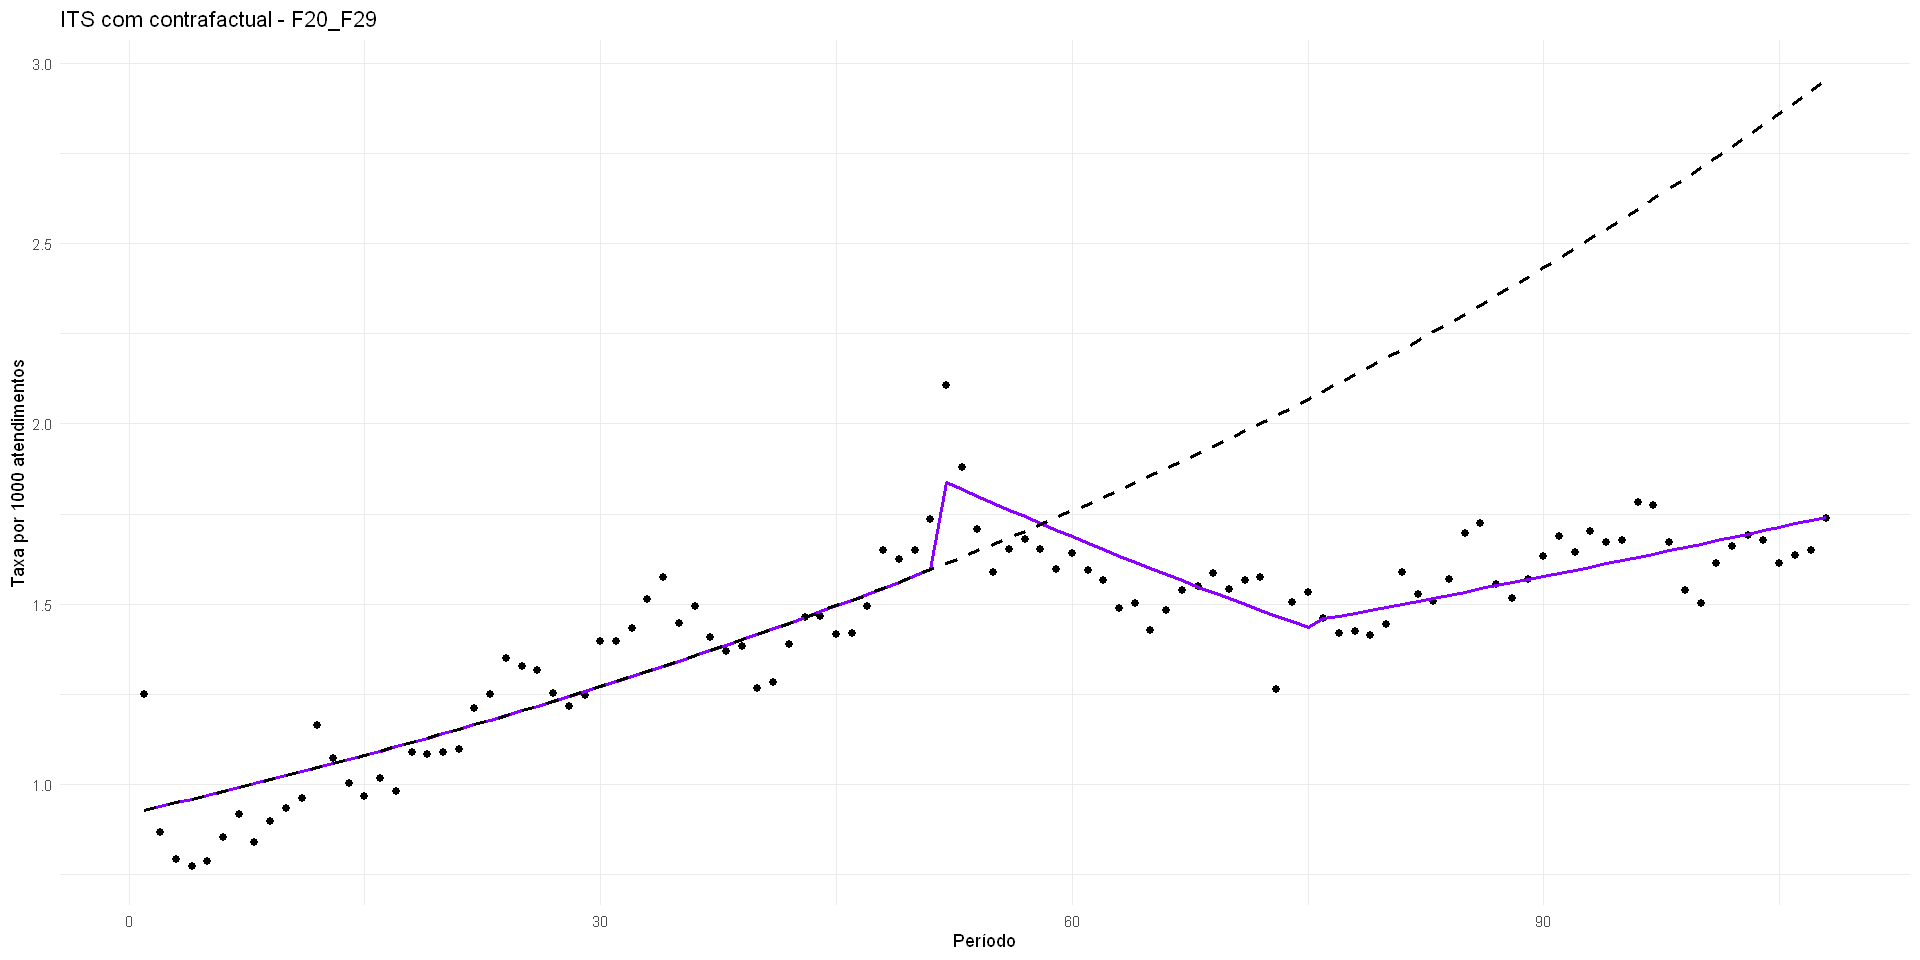

Plotando: Brasil 


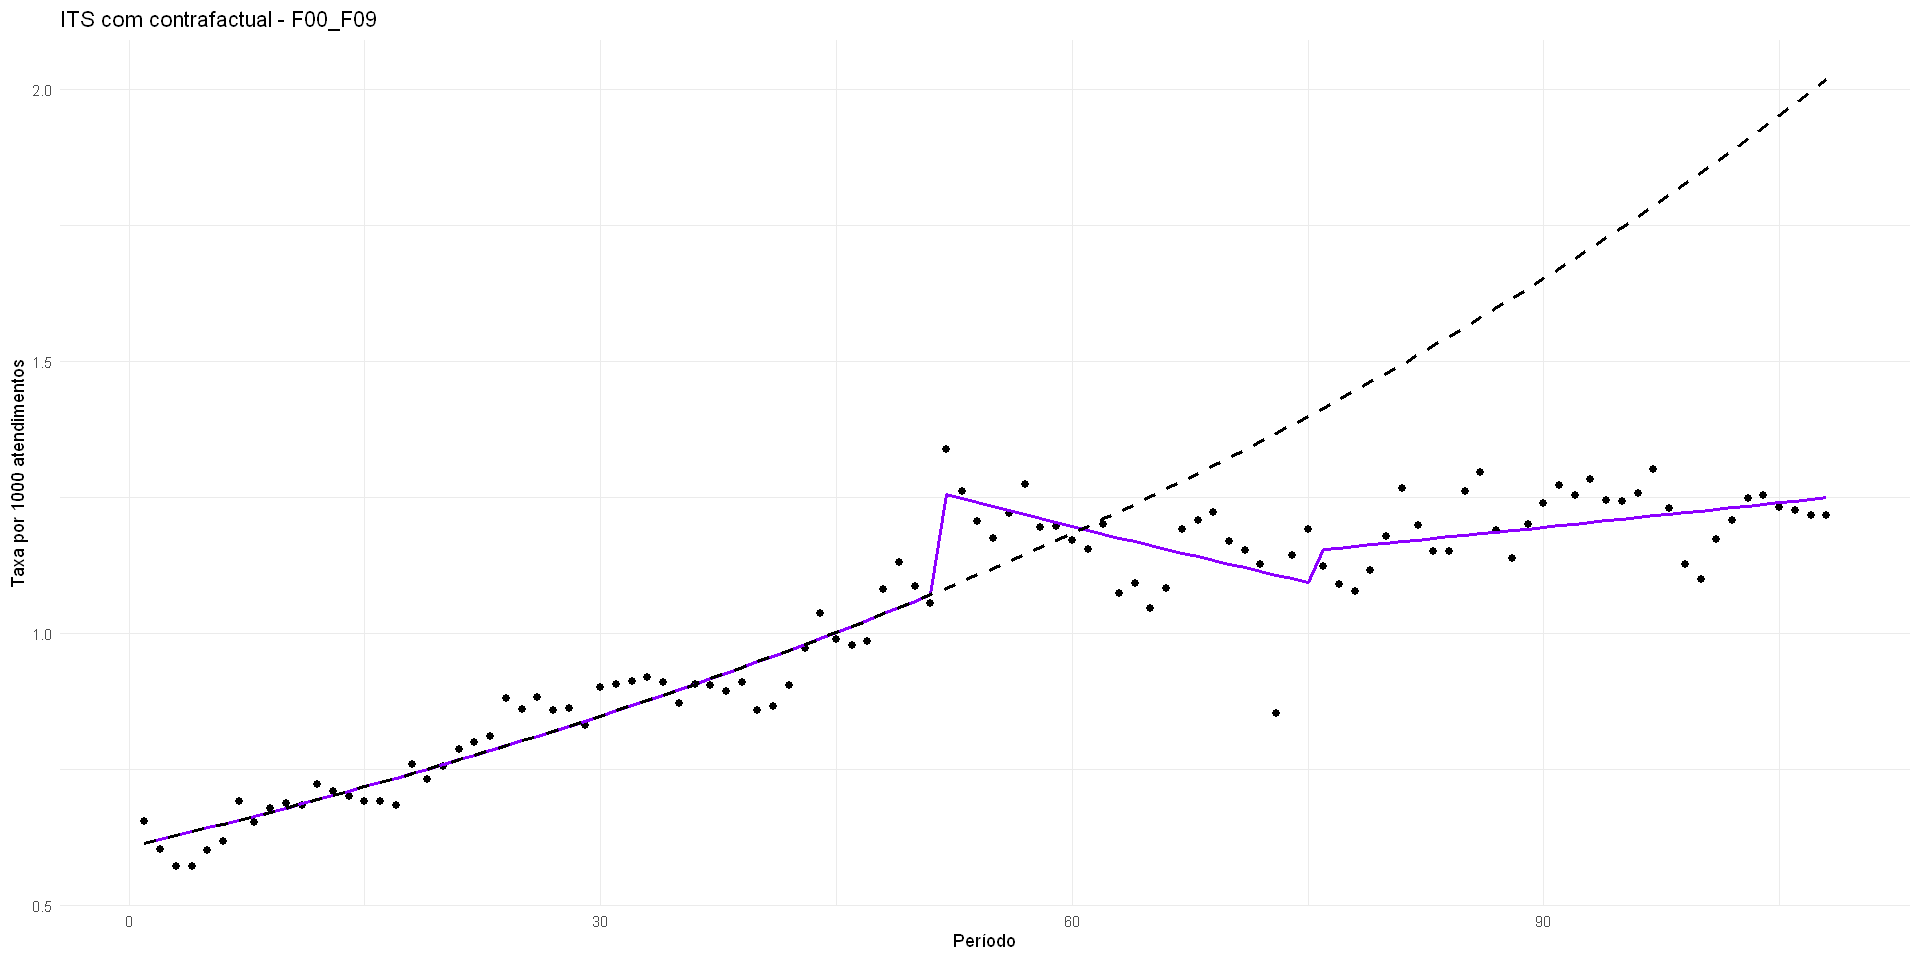

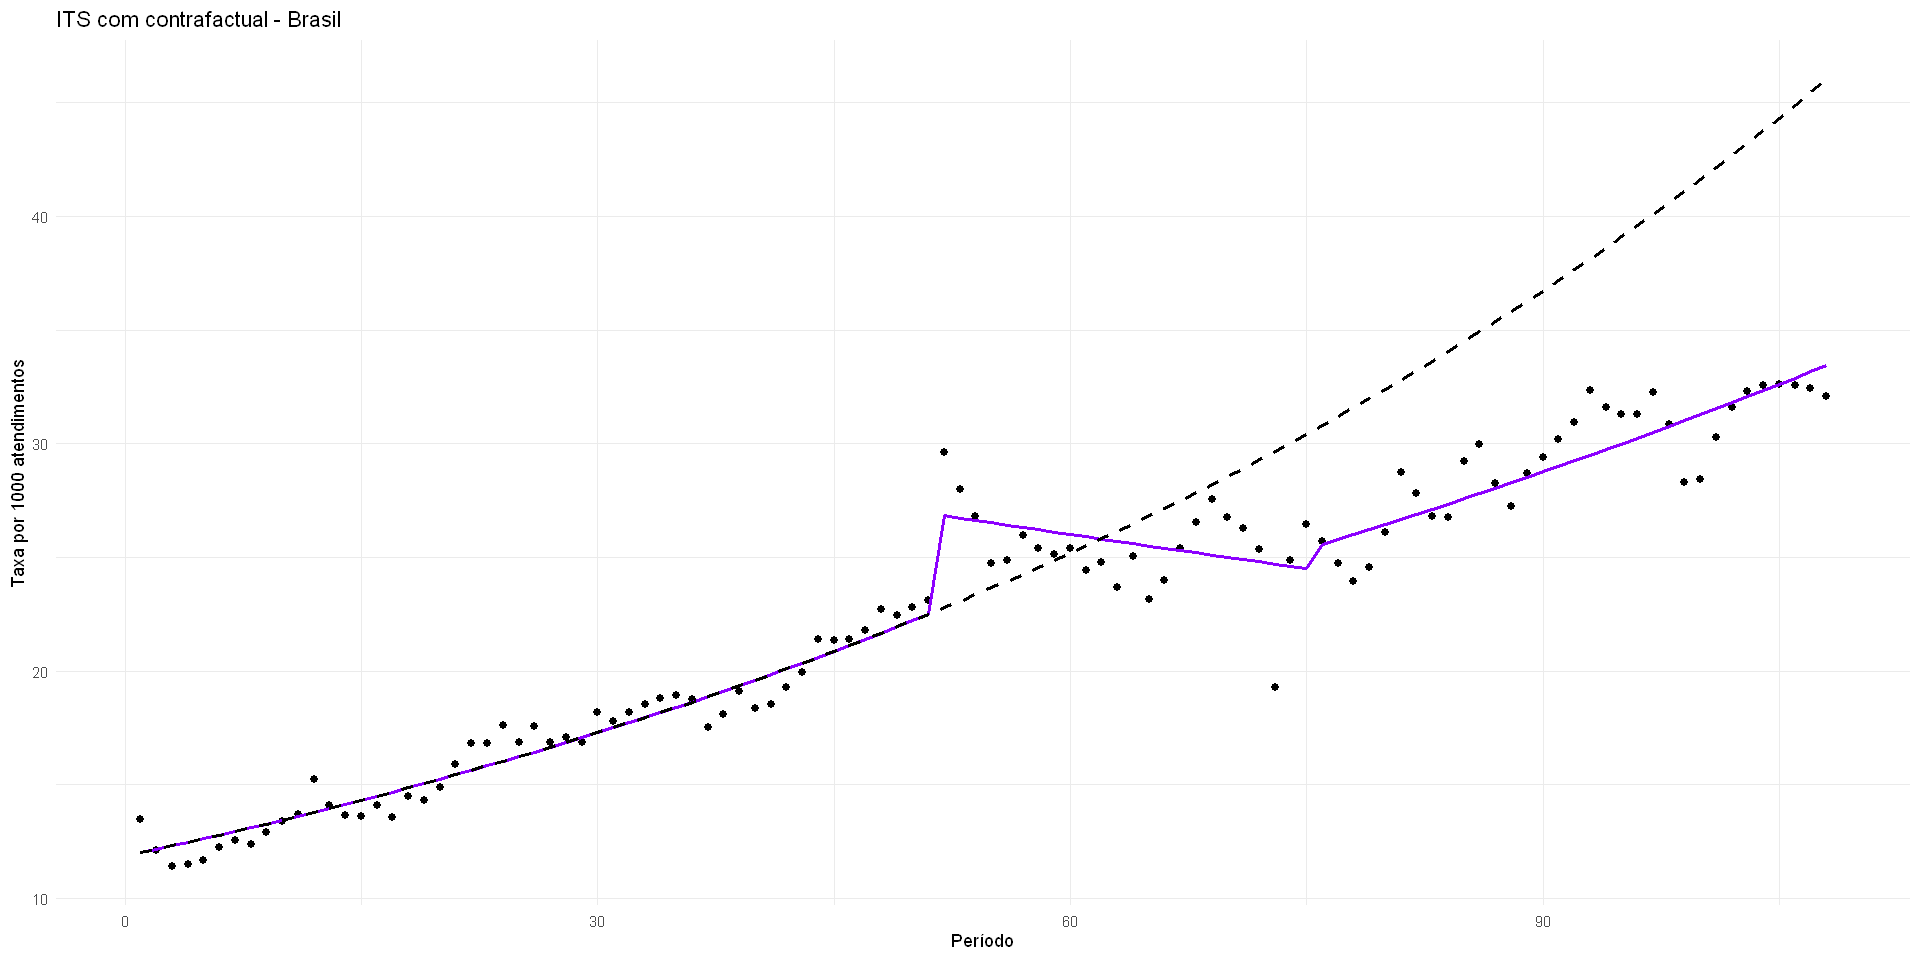

In [61]:
library(ggplot2)
library(dplyr)

for (reg in names(models_list)) {
  cat("Plotando:", reg, "\n")

  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        # fase == "pos" ~ exp(intercept + b_pstep + b_poststep + b_time * periodo +
        #                      b_ptrend * Pandemia_Trend + b_posttrend * PosPandemia_Trend)
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          +b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  p <- ggplot(reg_data, aes(x = periodo)) +
    geom_point(aes(y = IR), color = "black", size = 2) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff", size = 1) +
    geom_line(aes(y = predicted_counterfactual), color = "#000000", linetype = "dashed", size = 1) +
    labs(
      title = paste("ITS com contrafactual -", reg),
      y = "Taxa por 1000 atendimentos",
      x = "Período"
    ) +
    theme_minimal()

  print(p)
}


Plotando: sul 
Plotando: sudeste 


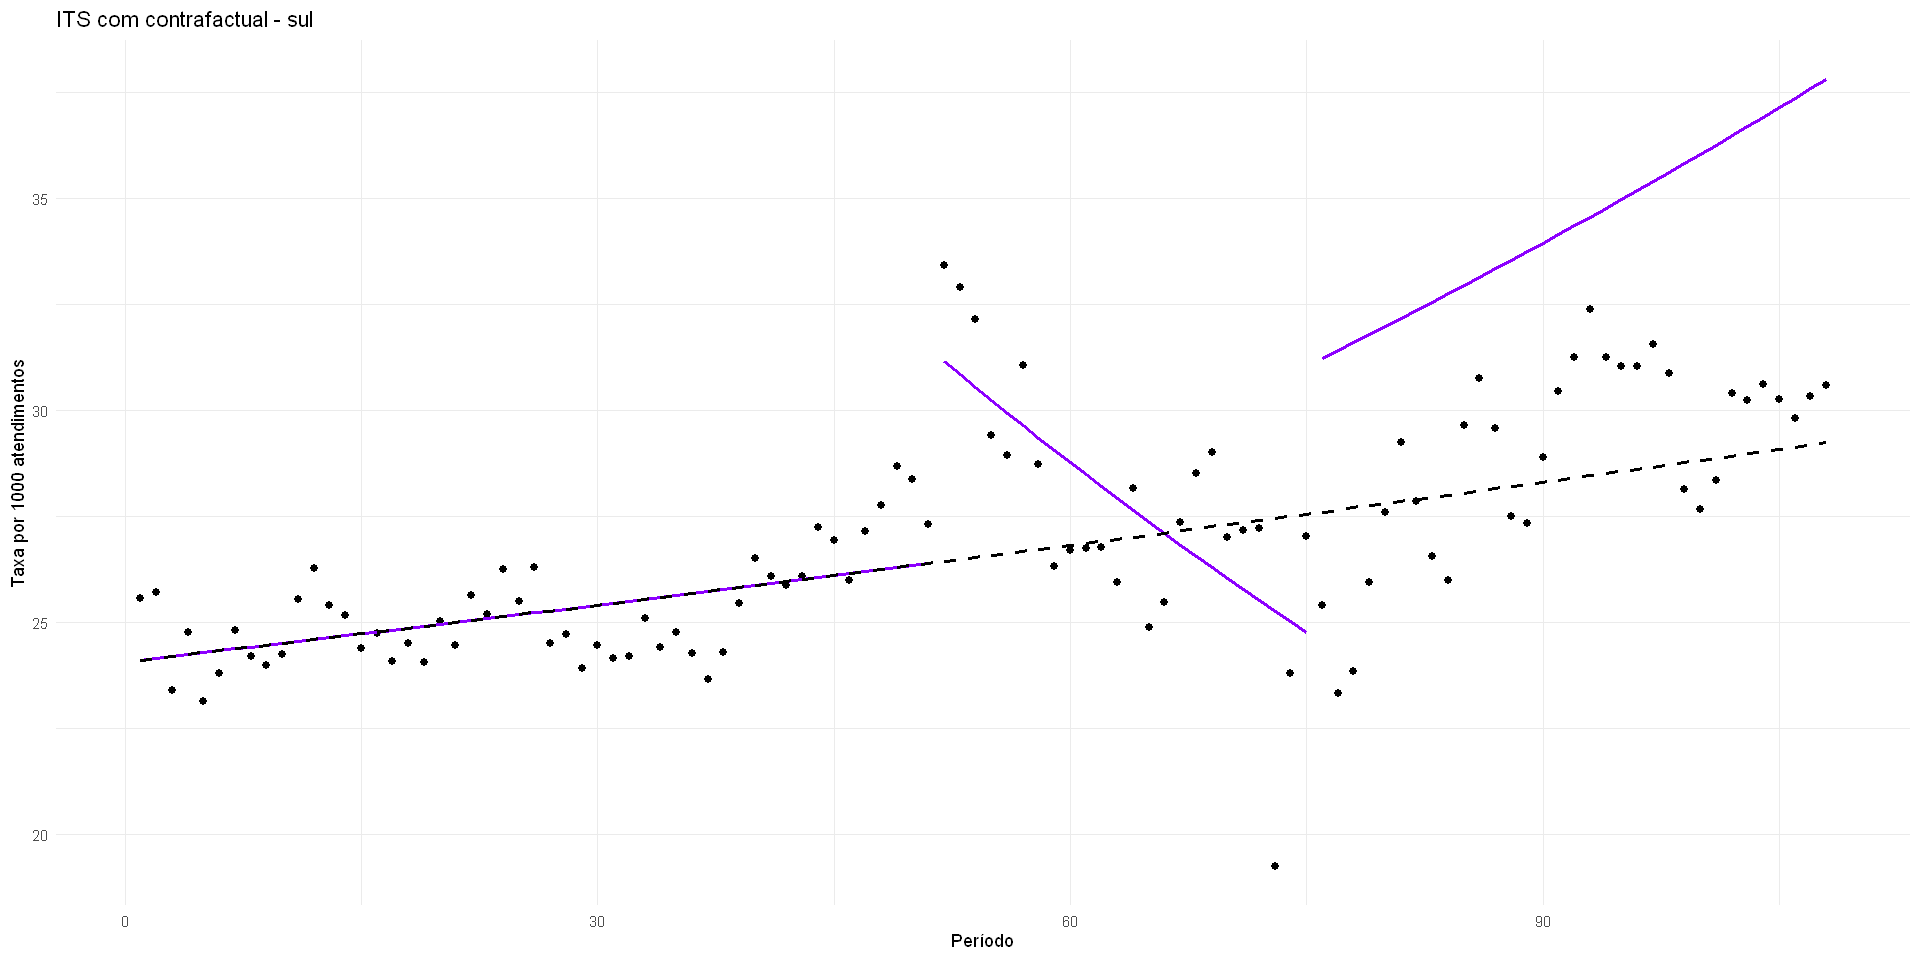

Plotando: norte 


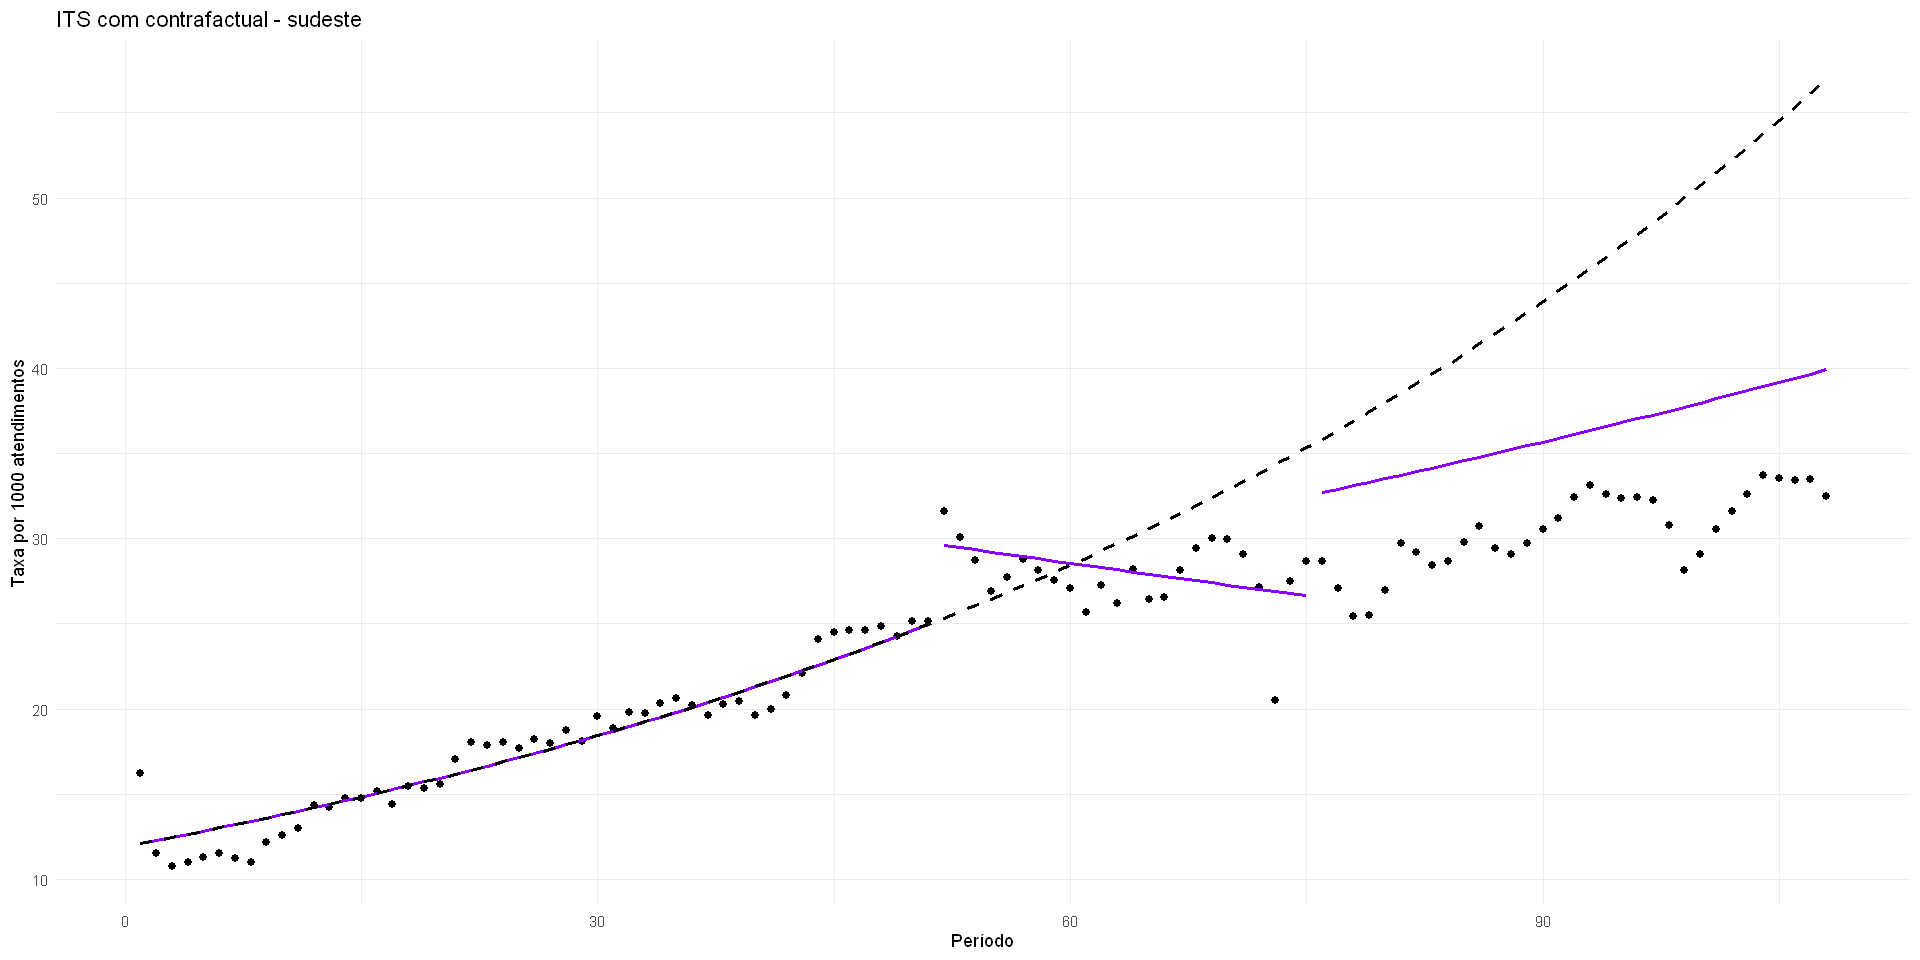

Plotando: nordeste 


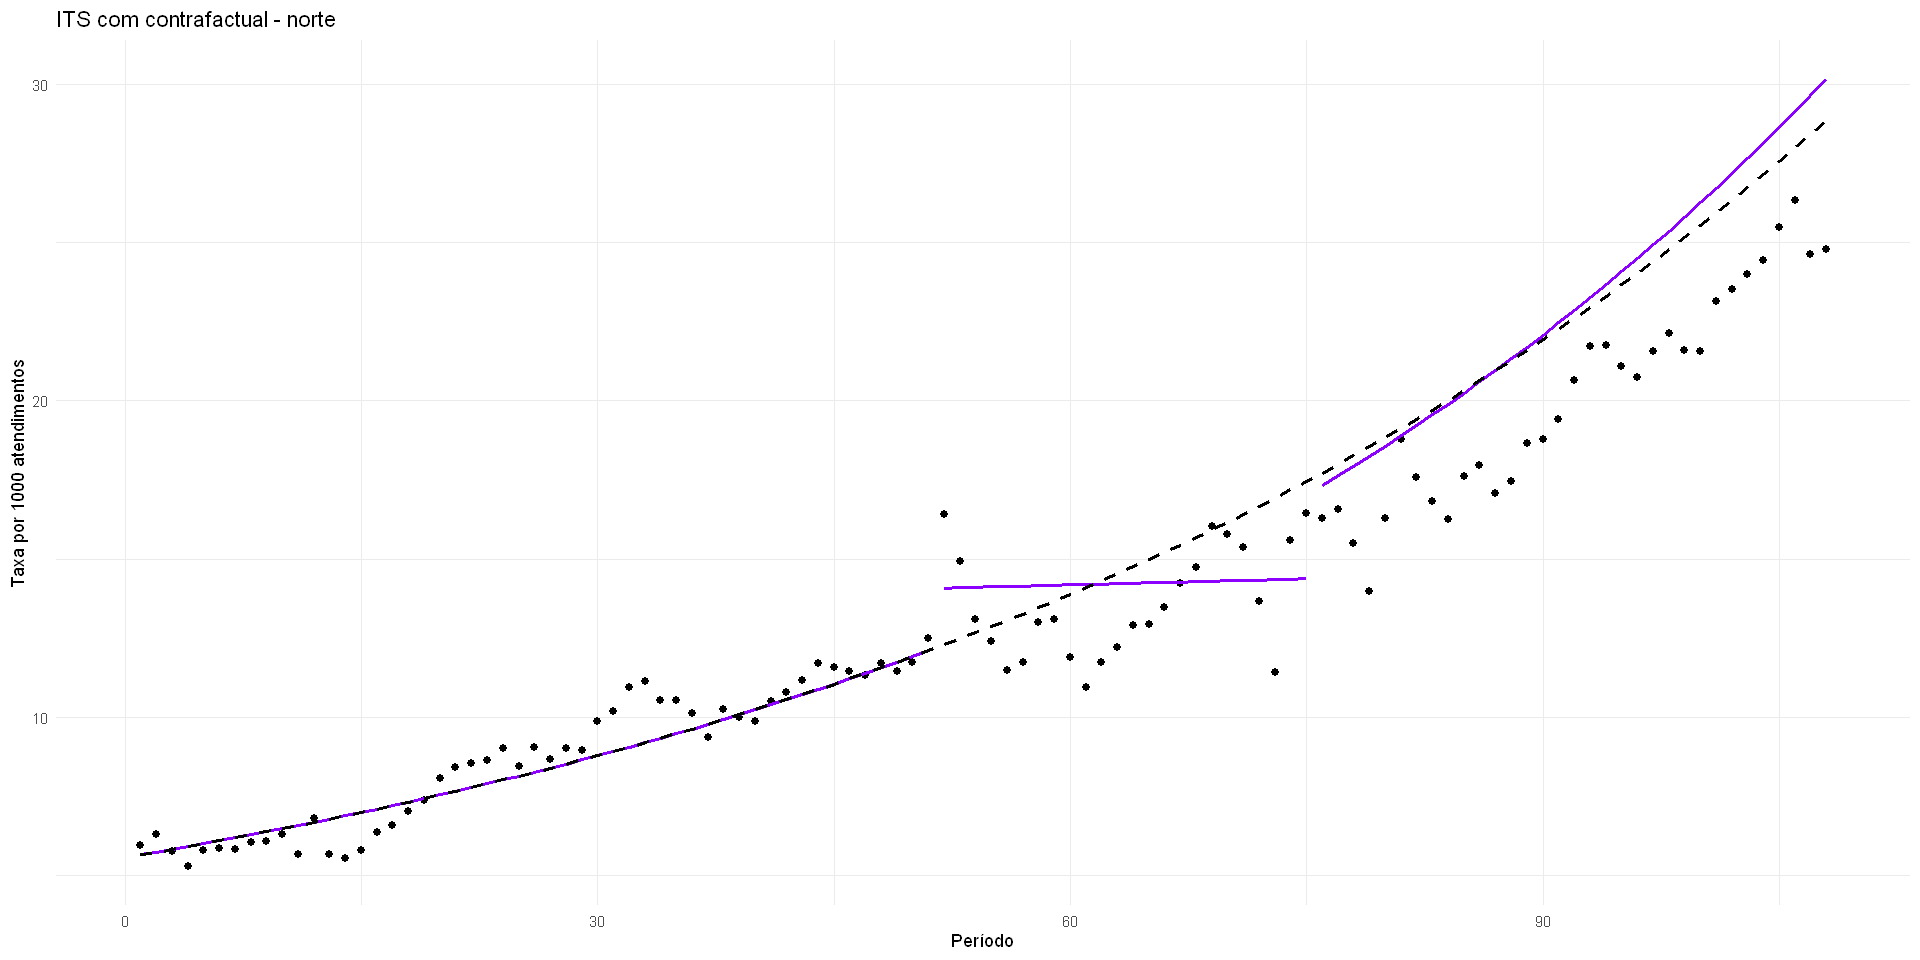

Plotando: centro_oeste 


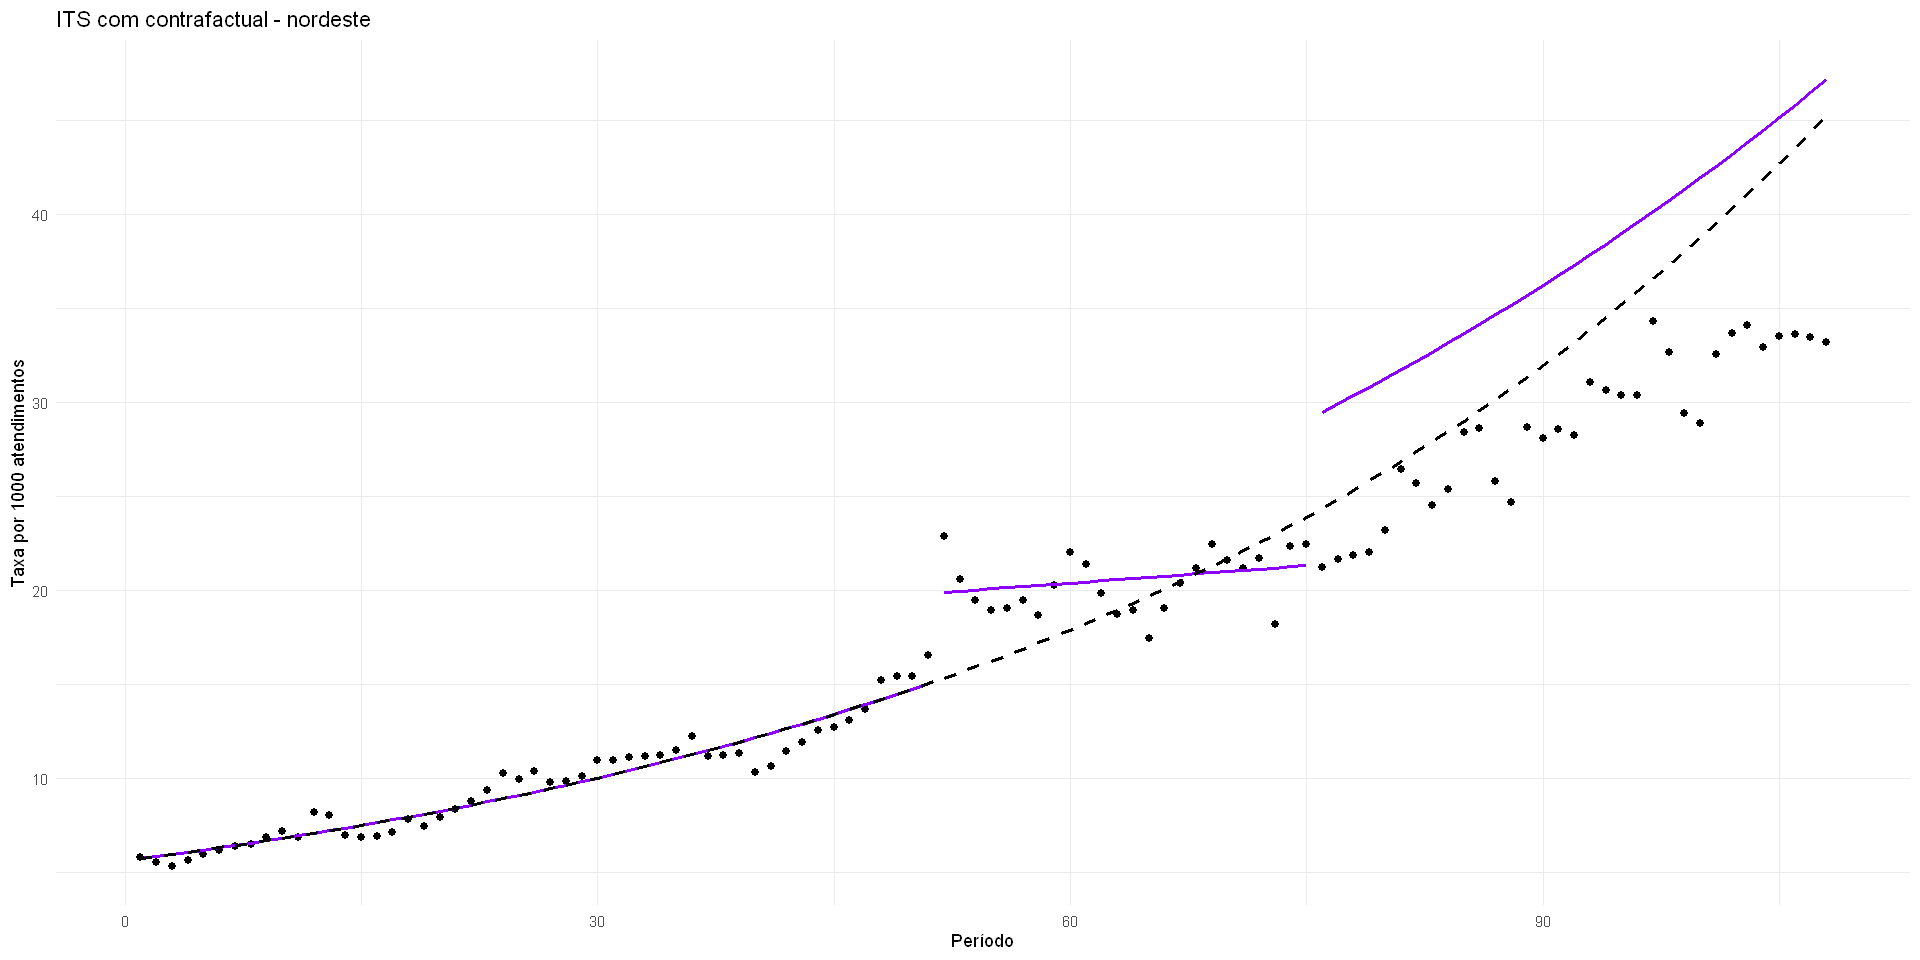

Plotando: F99_F99 


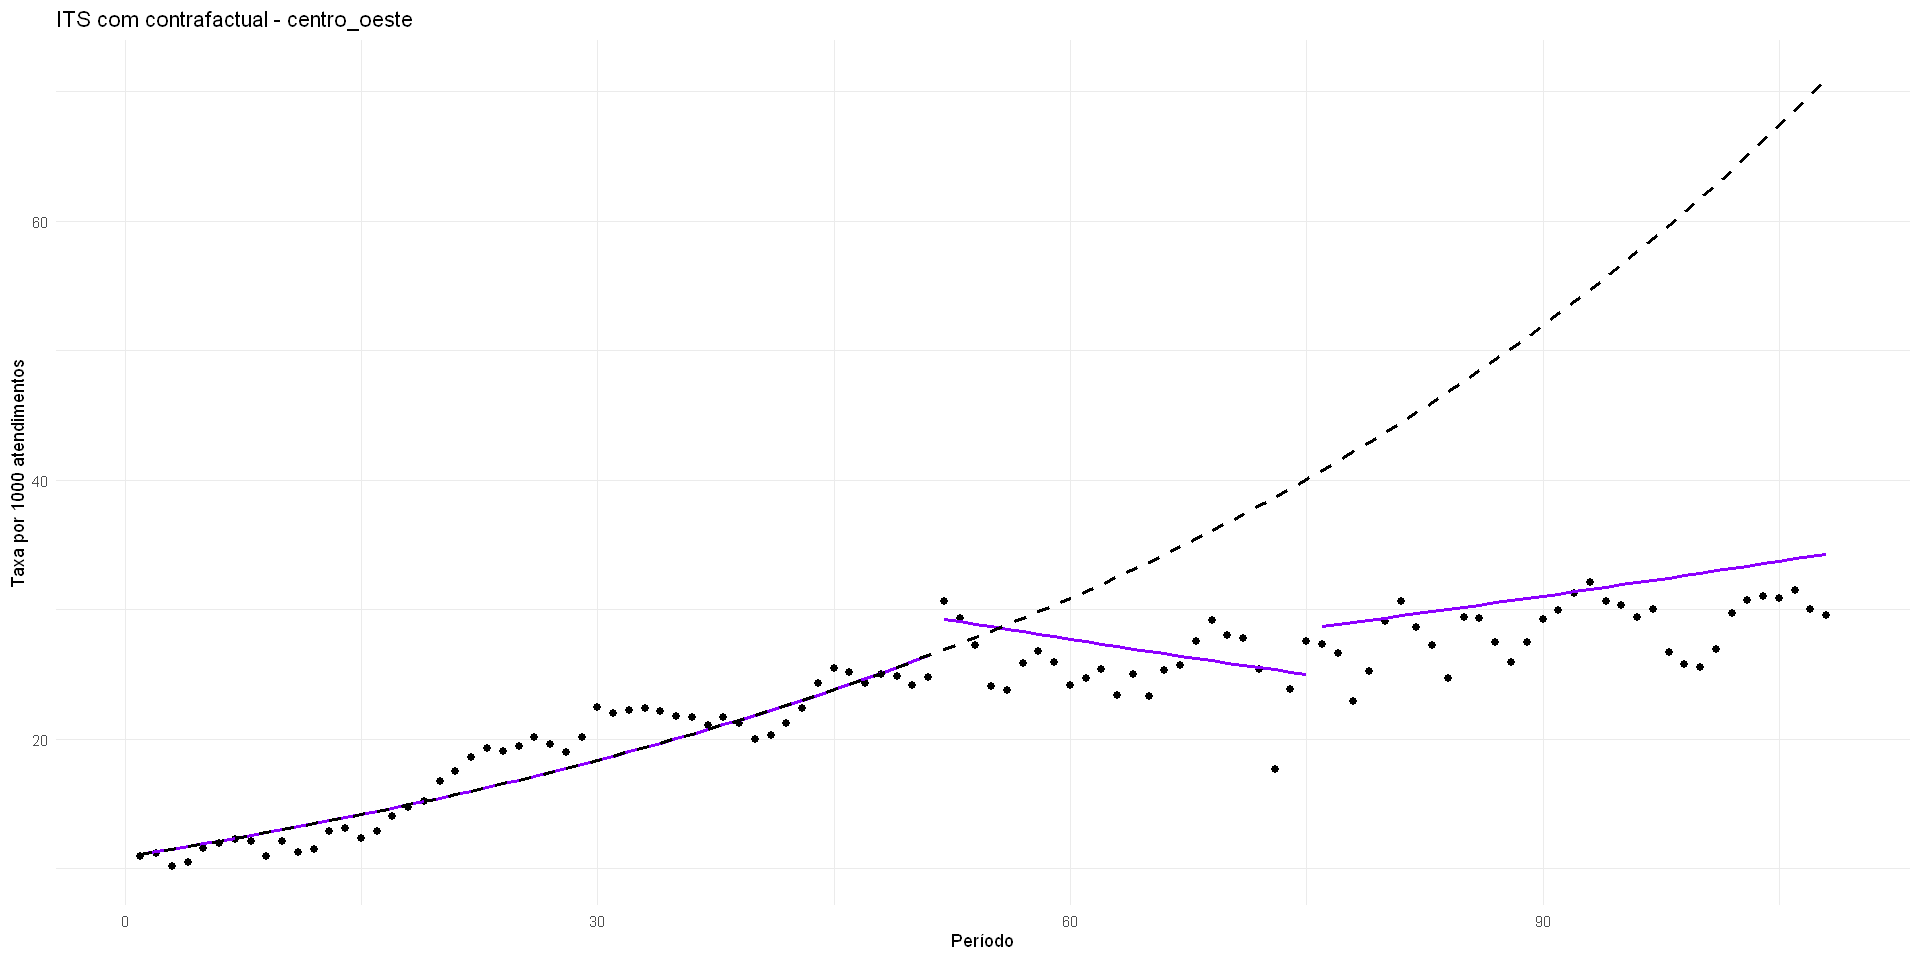

Plotando: F90_F98 


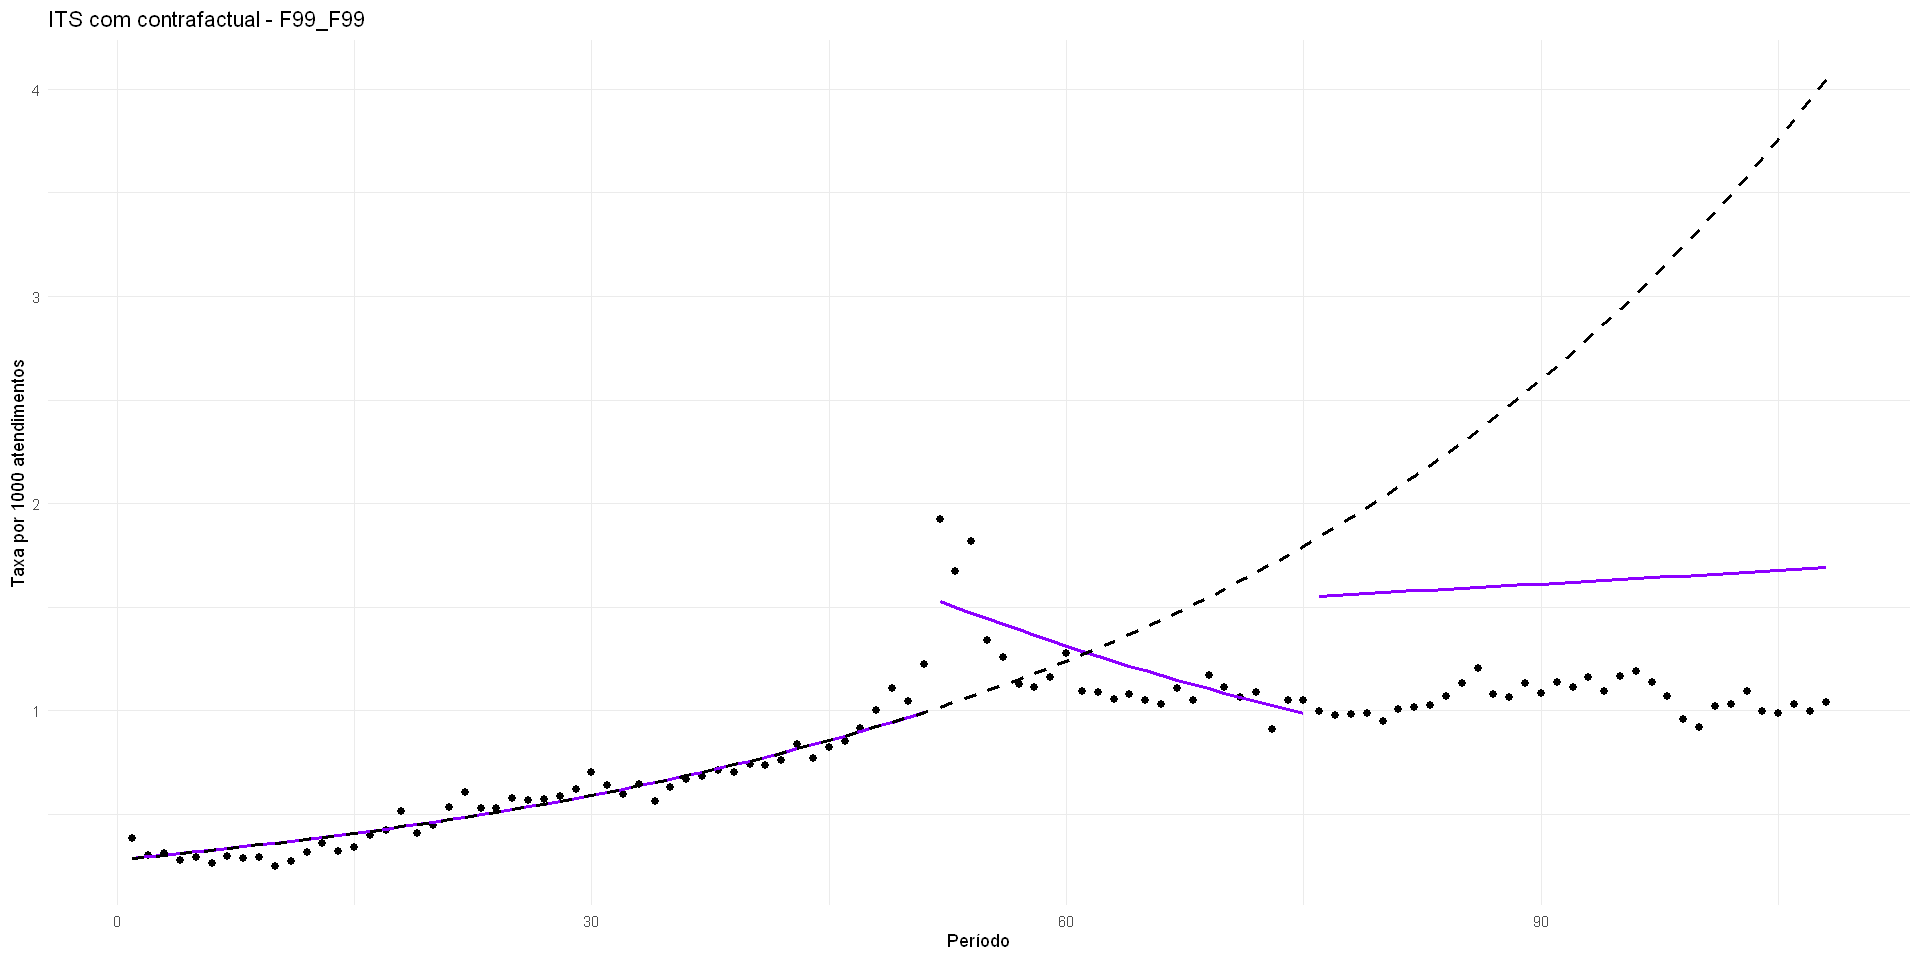

Plotando: F80_F89 


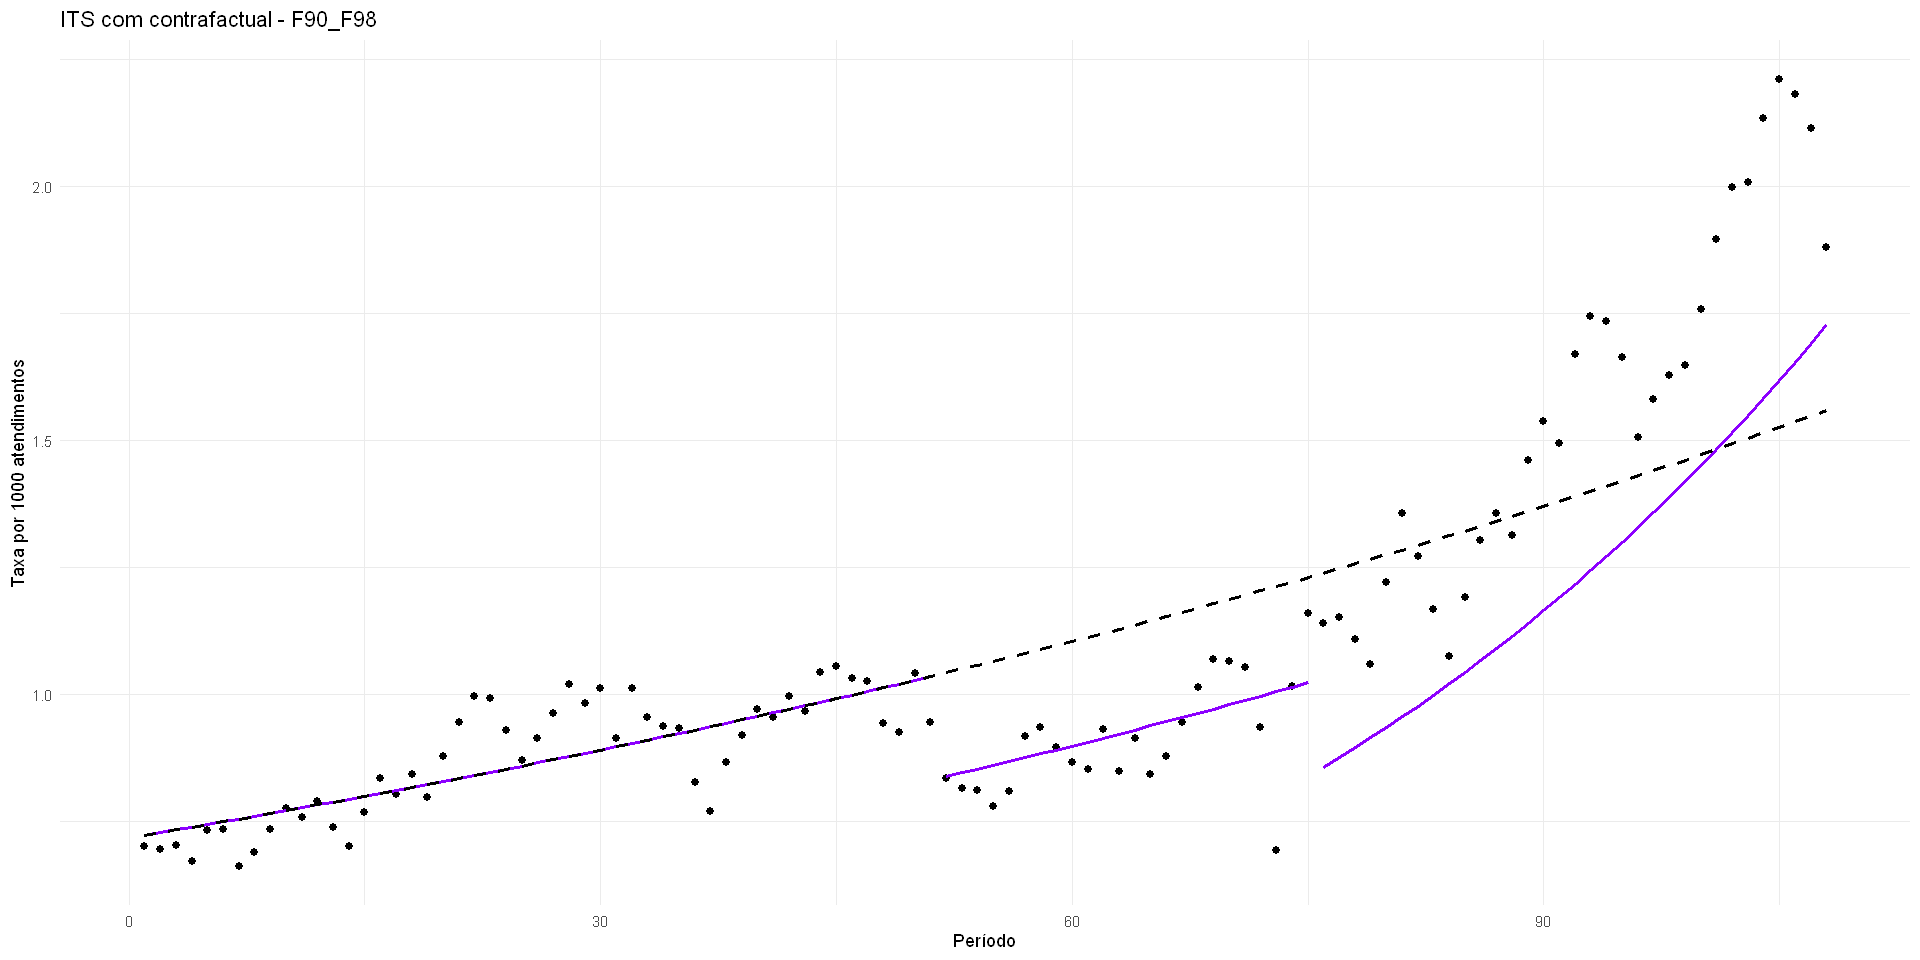

Plotando: F70_F79 


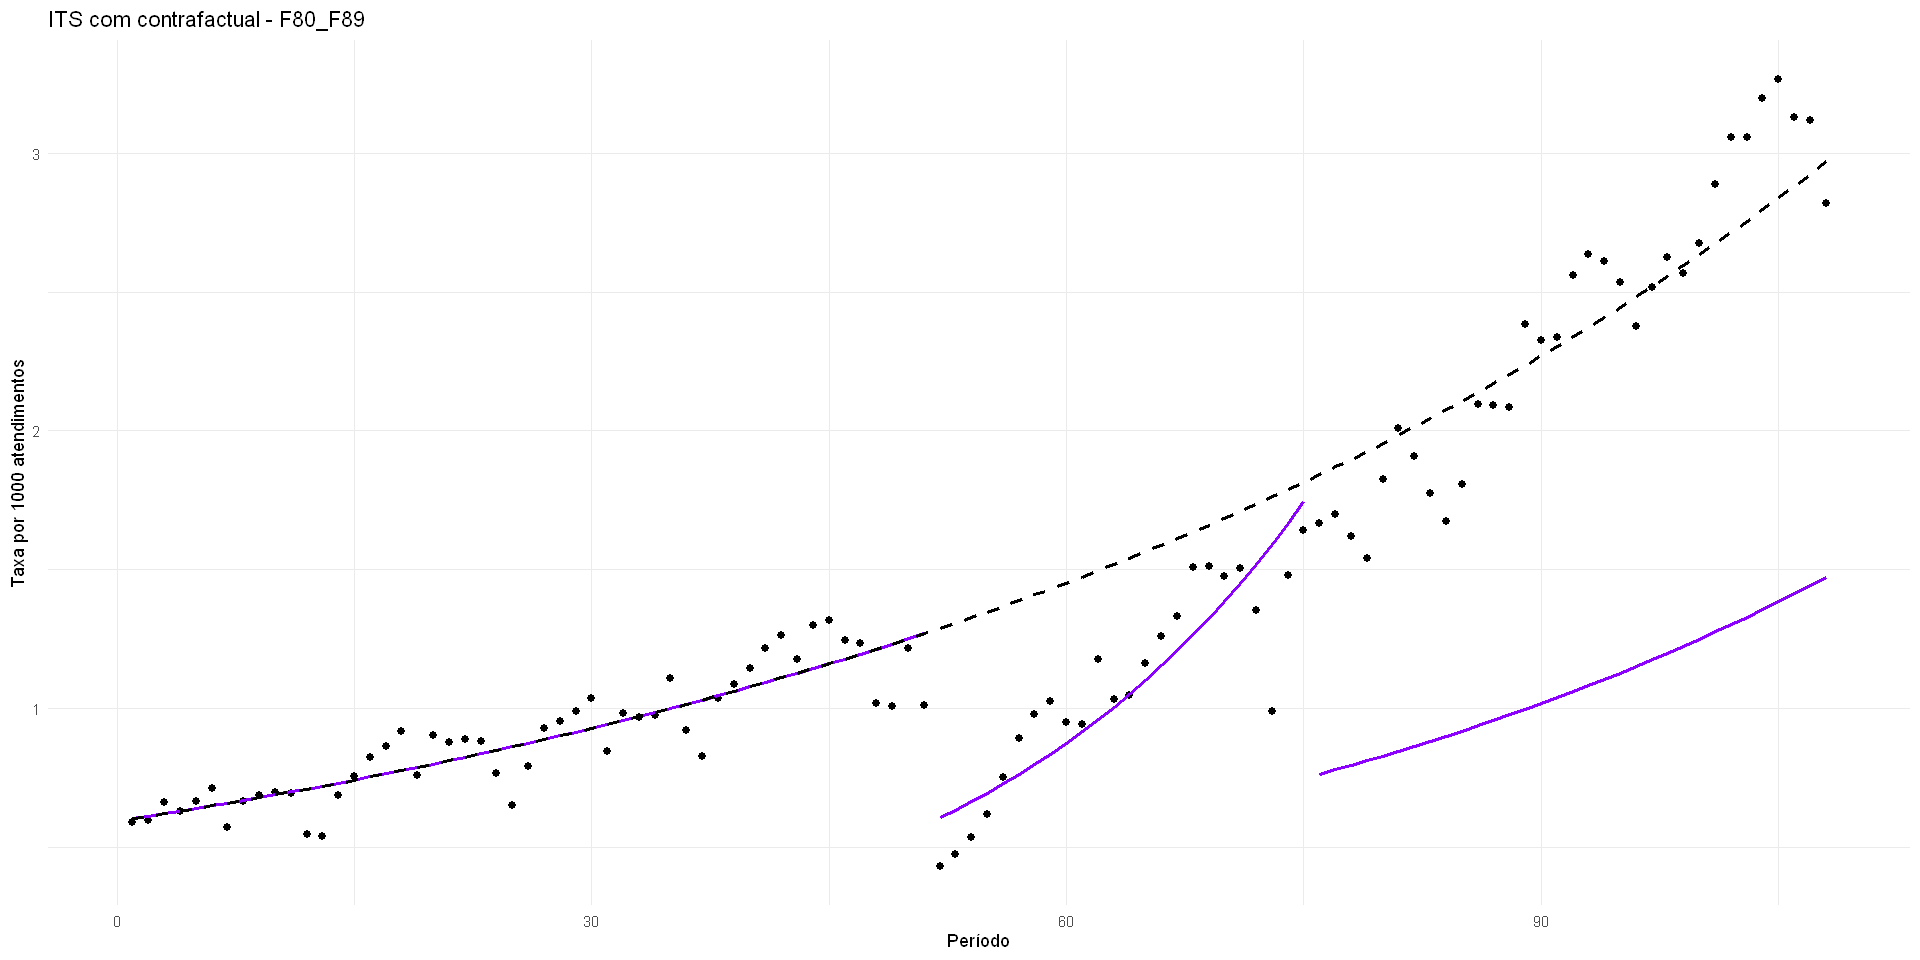

Plotando: F60_F69 


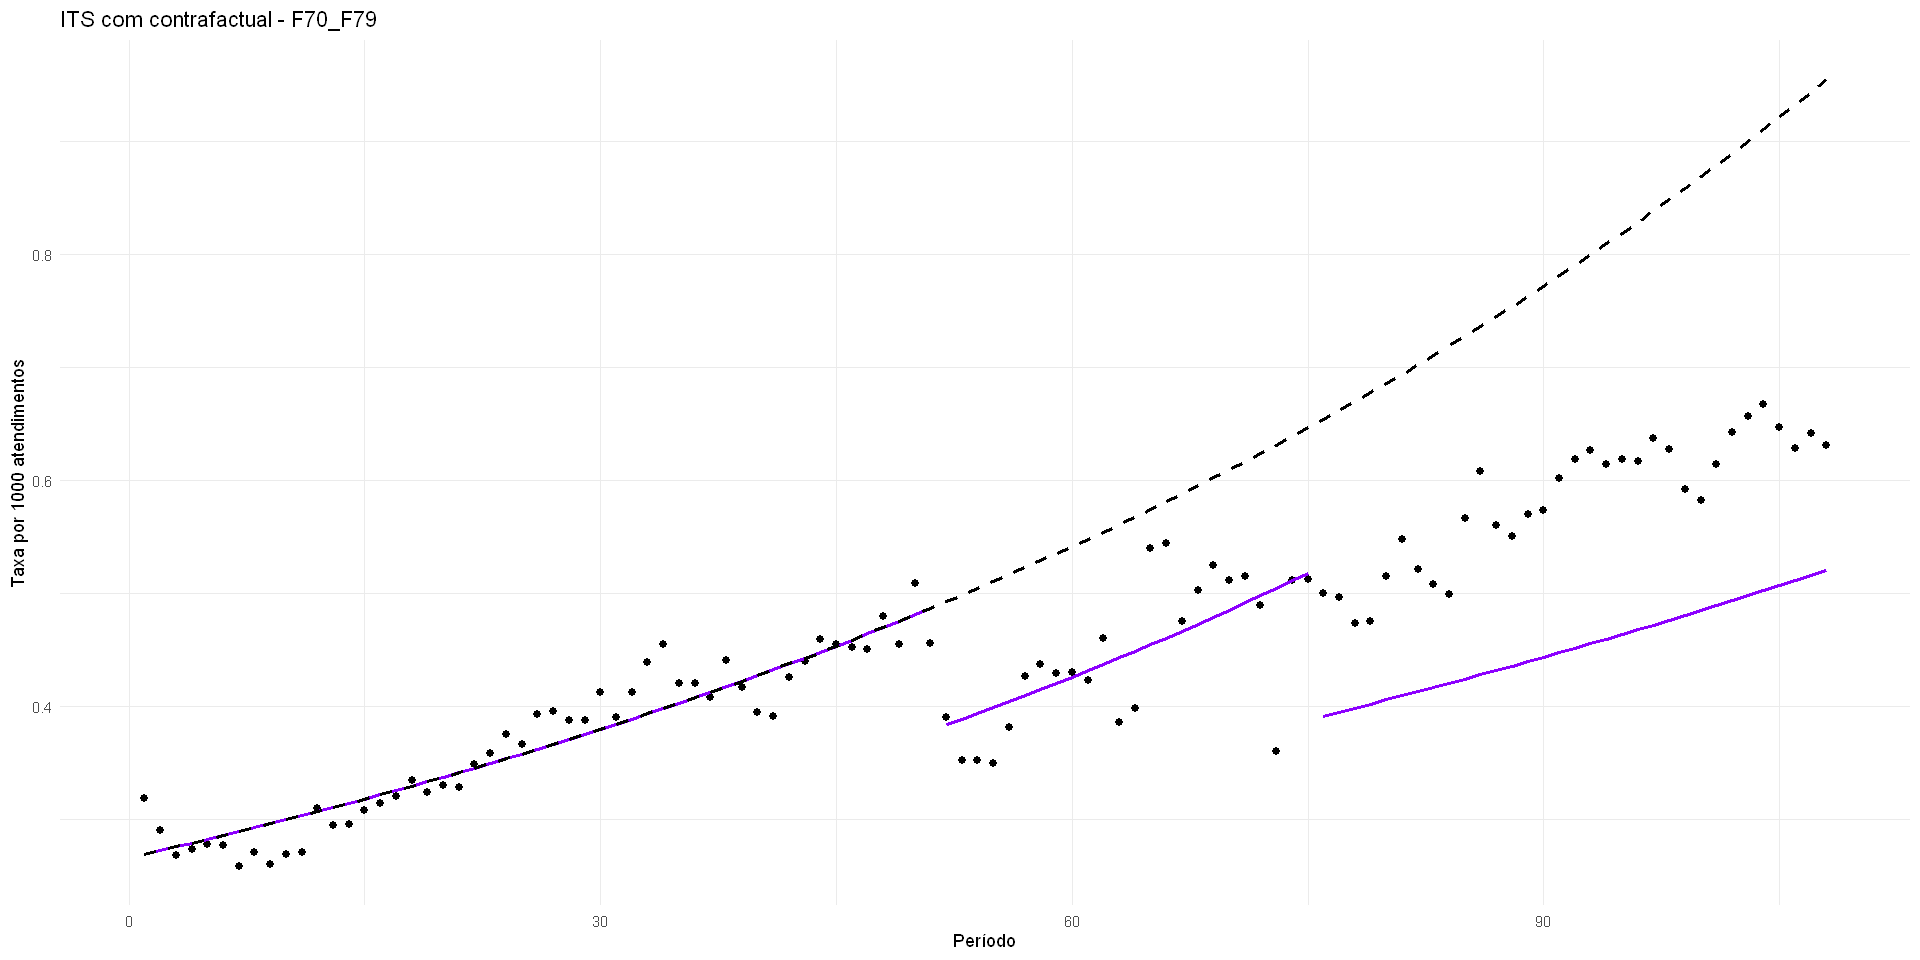

Plotando: F50_F59 


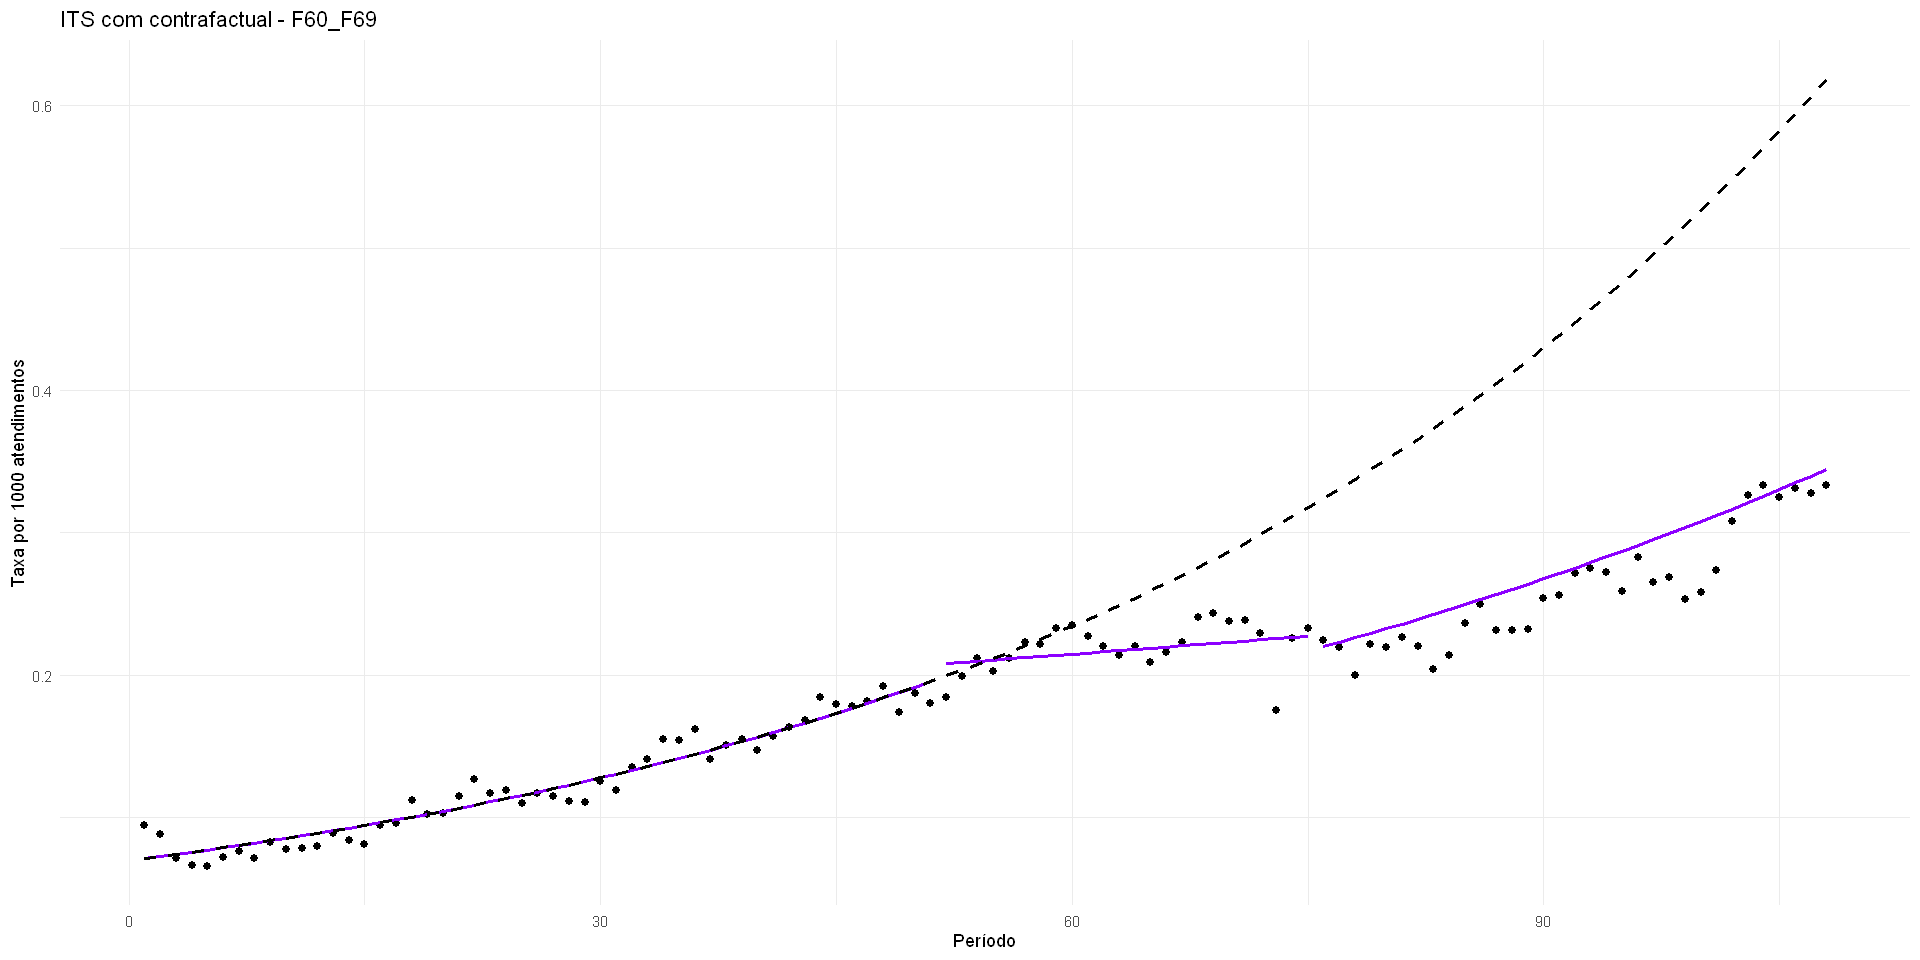

Plotando: F40_F48 


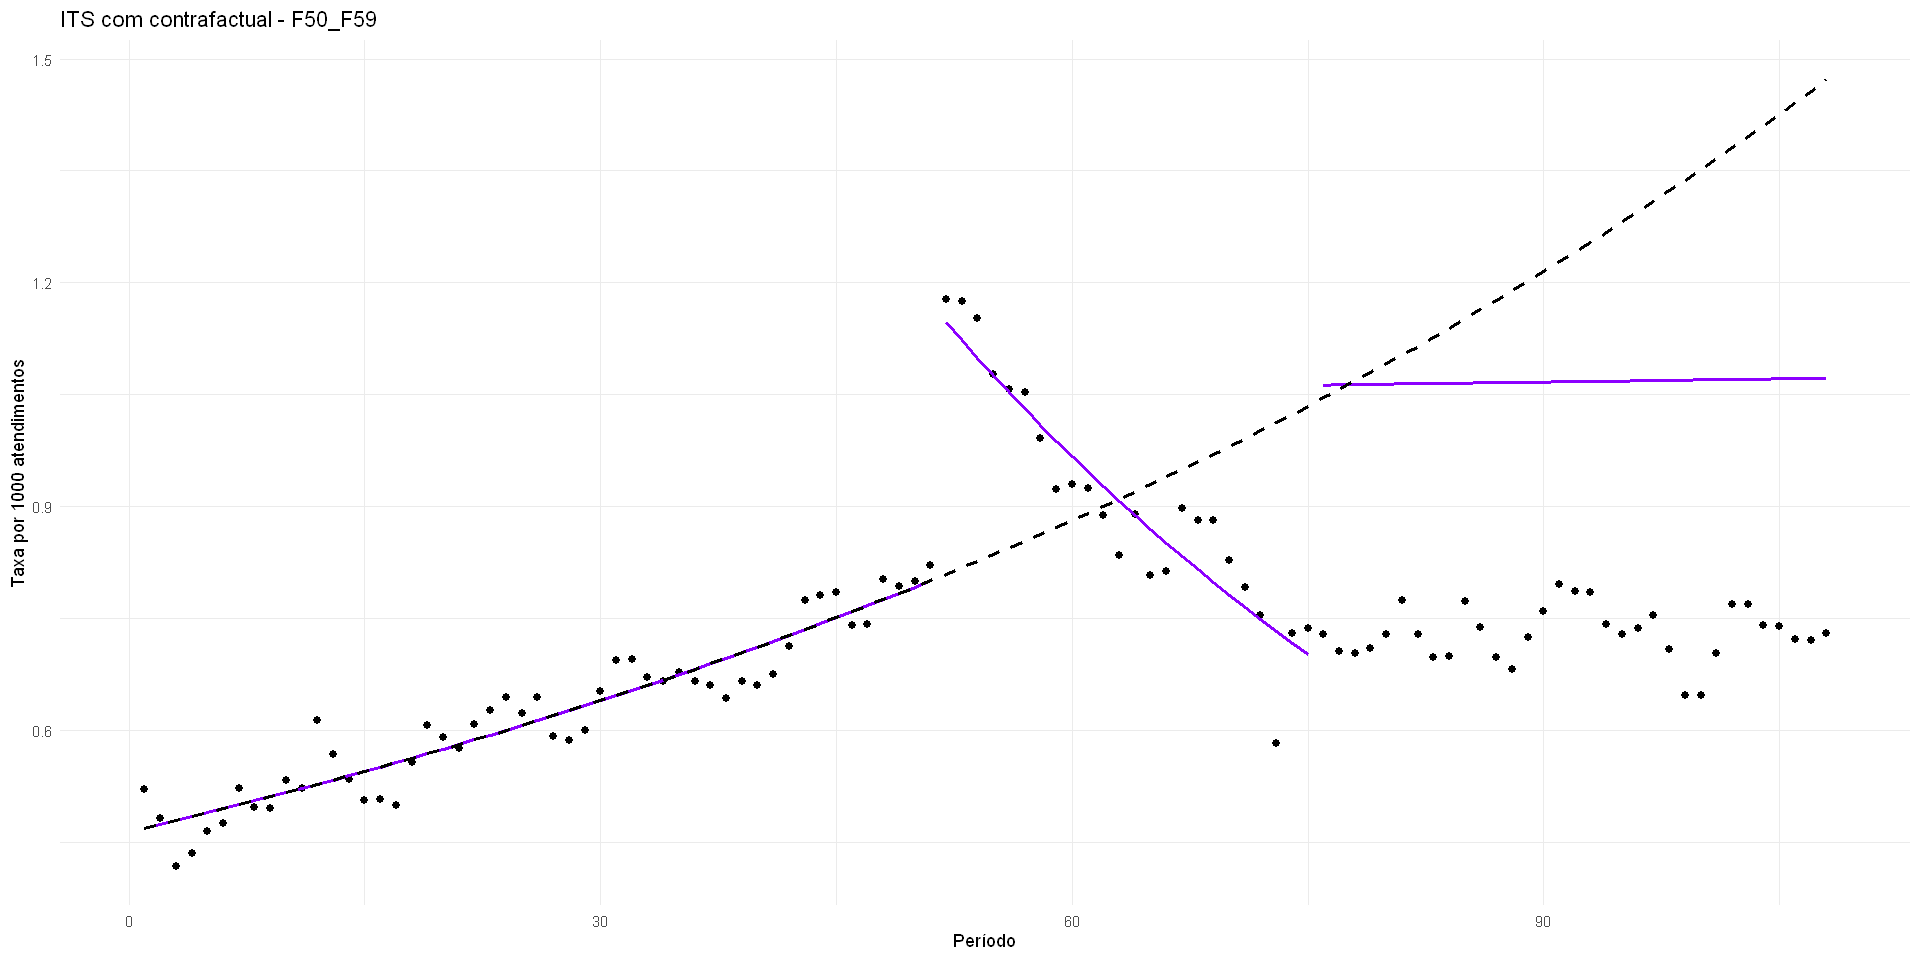

Plotando: F30_F39 


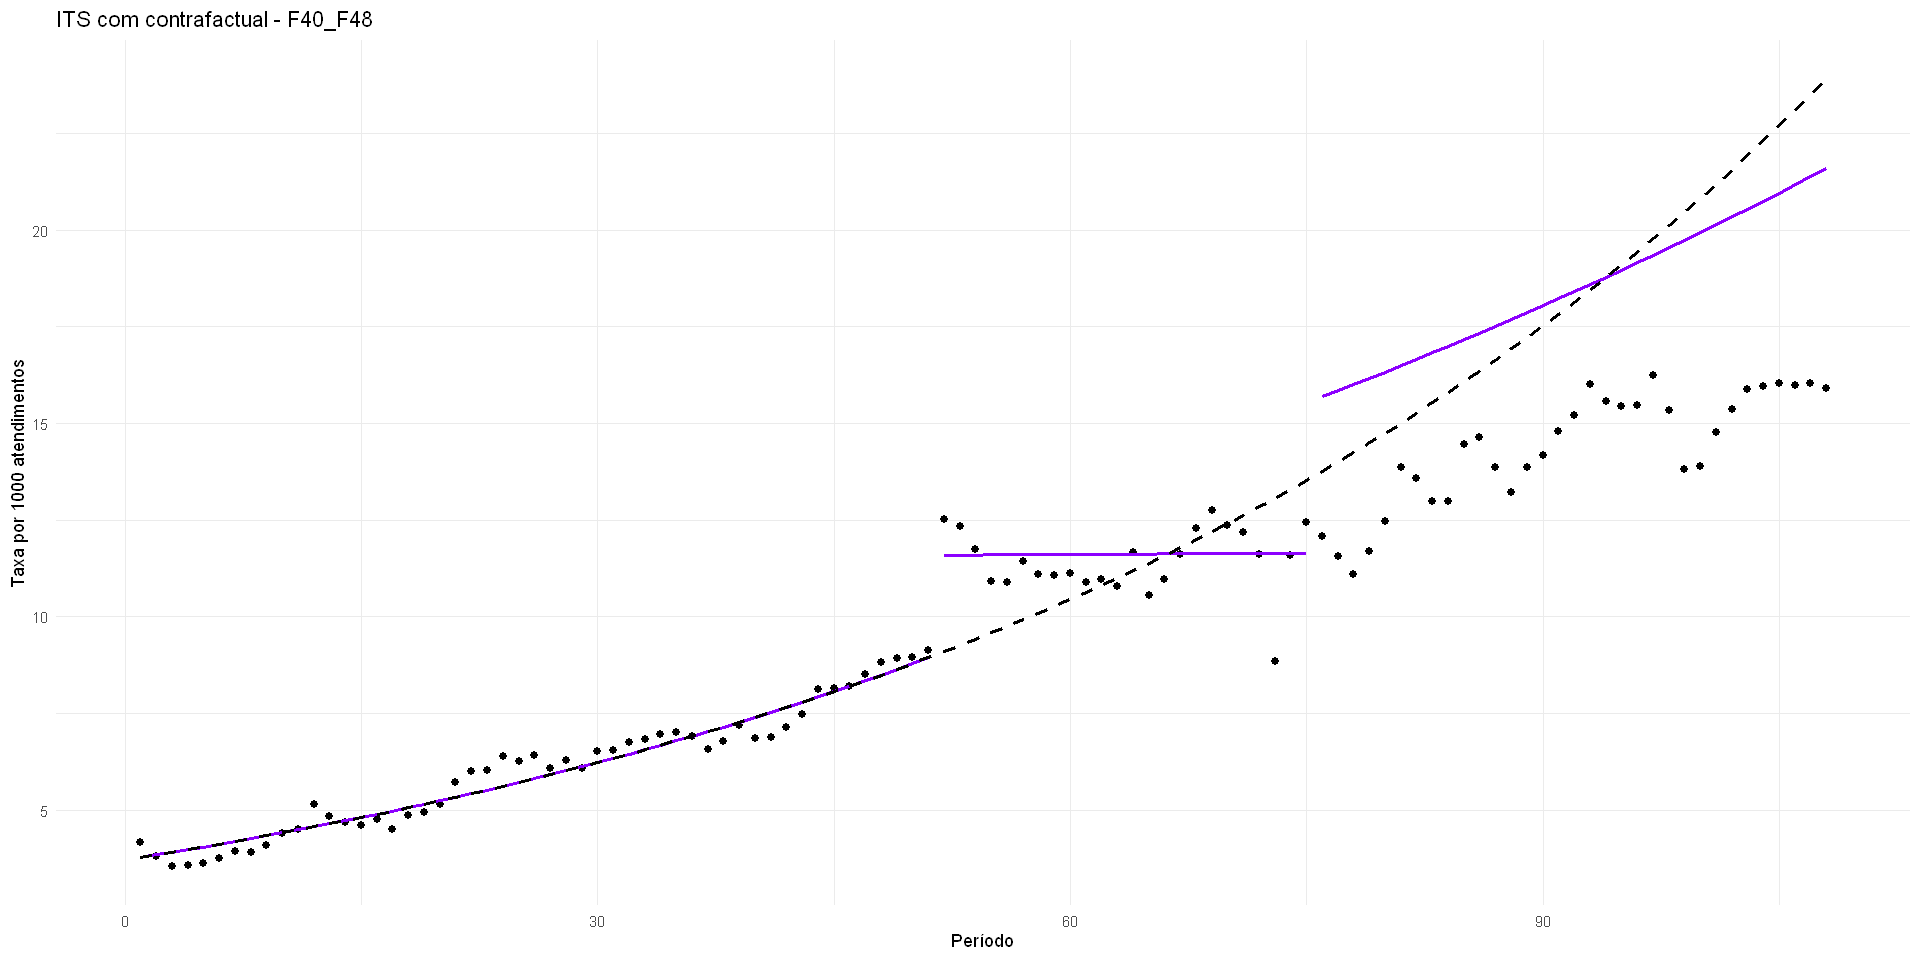

Plotando: F20_F29 


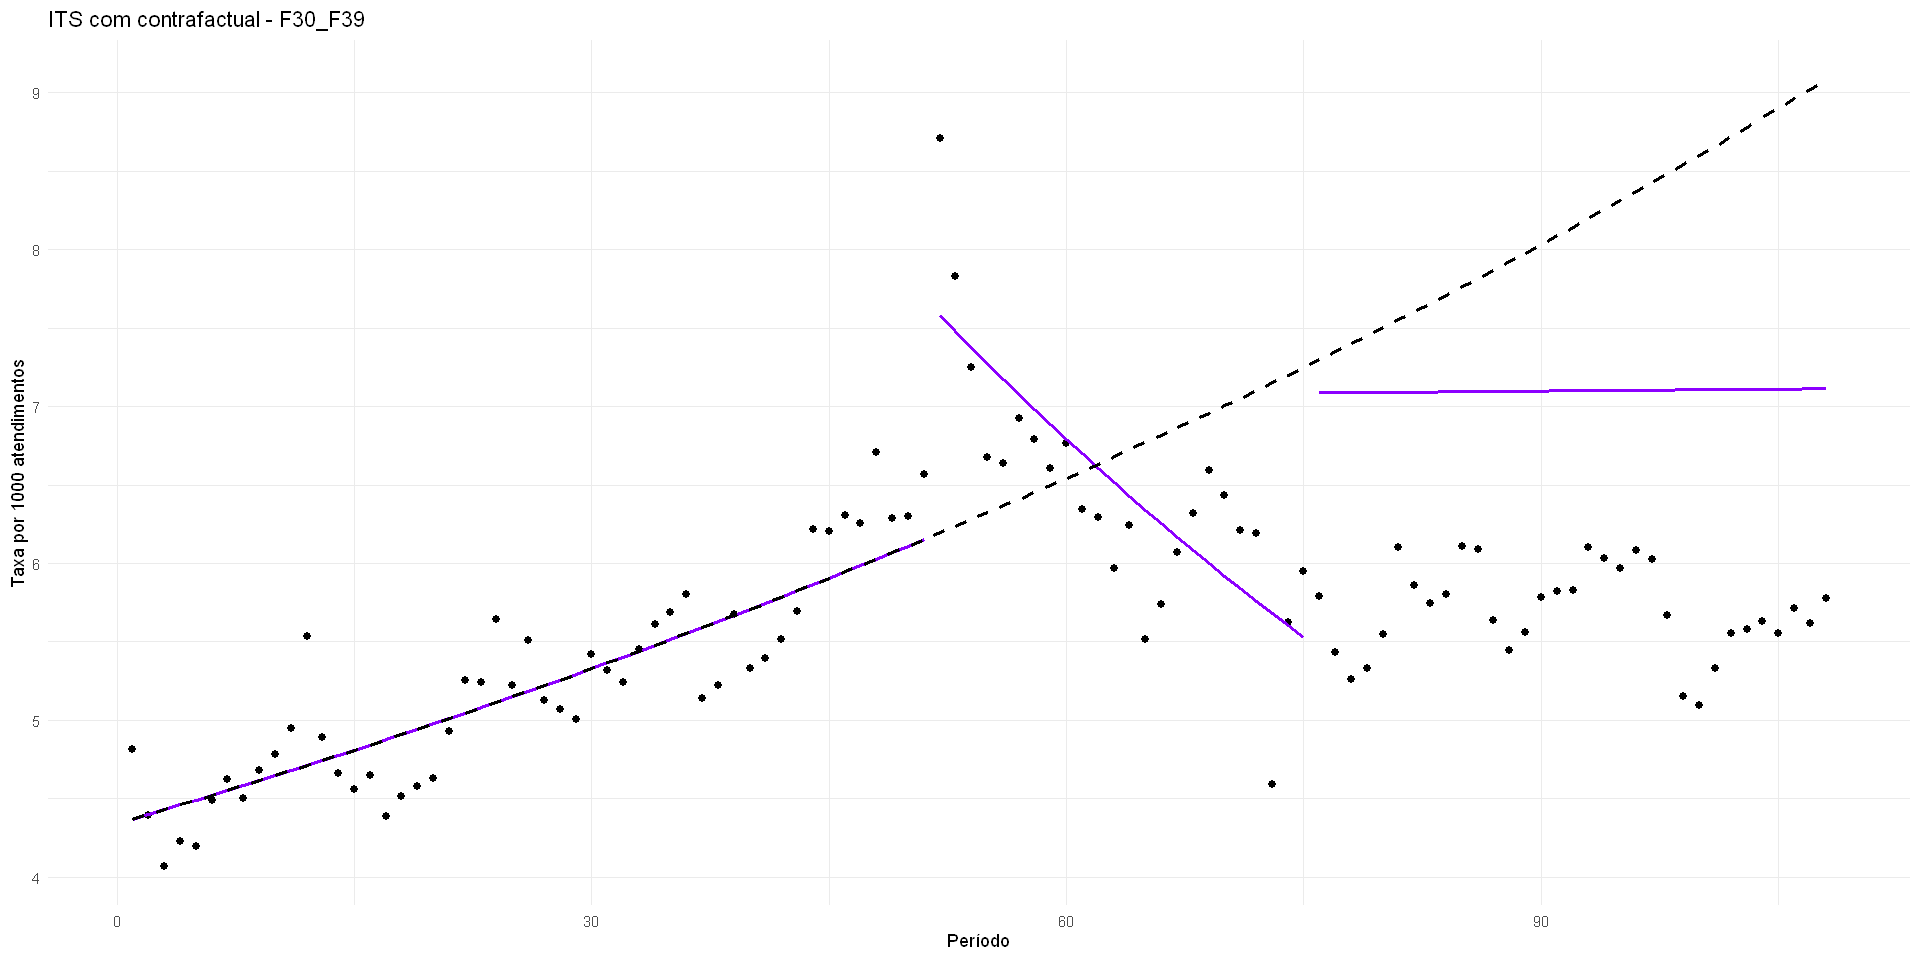

Plotando: F00_F09 


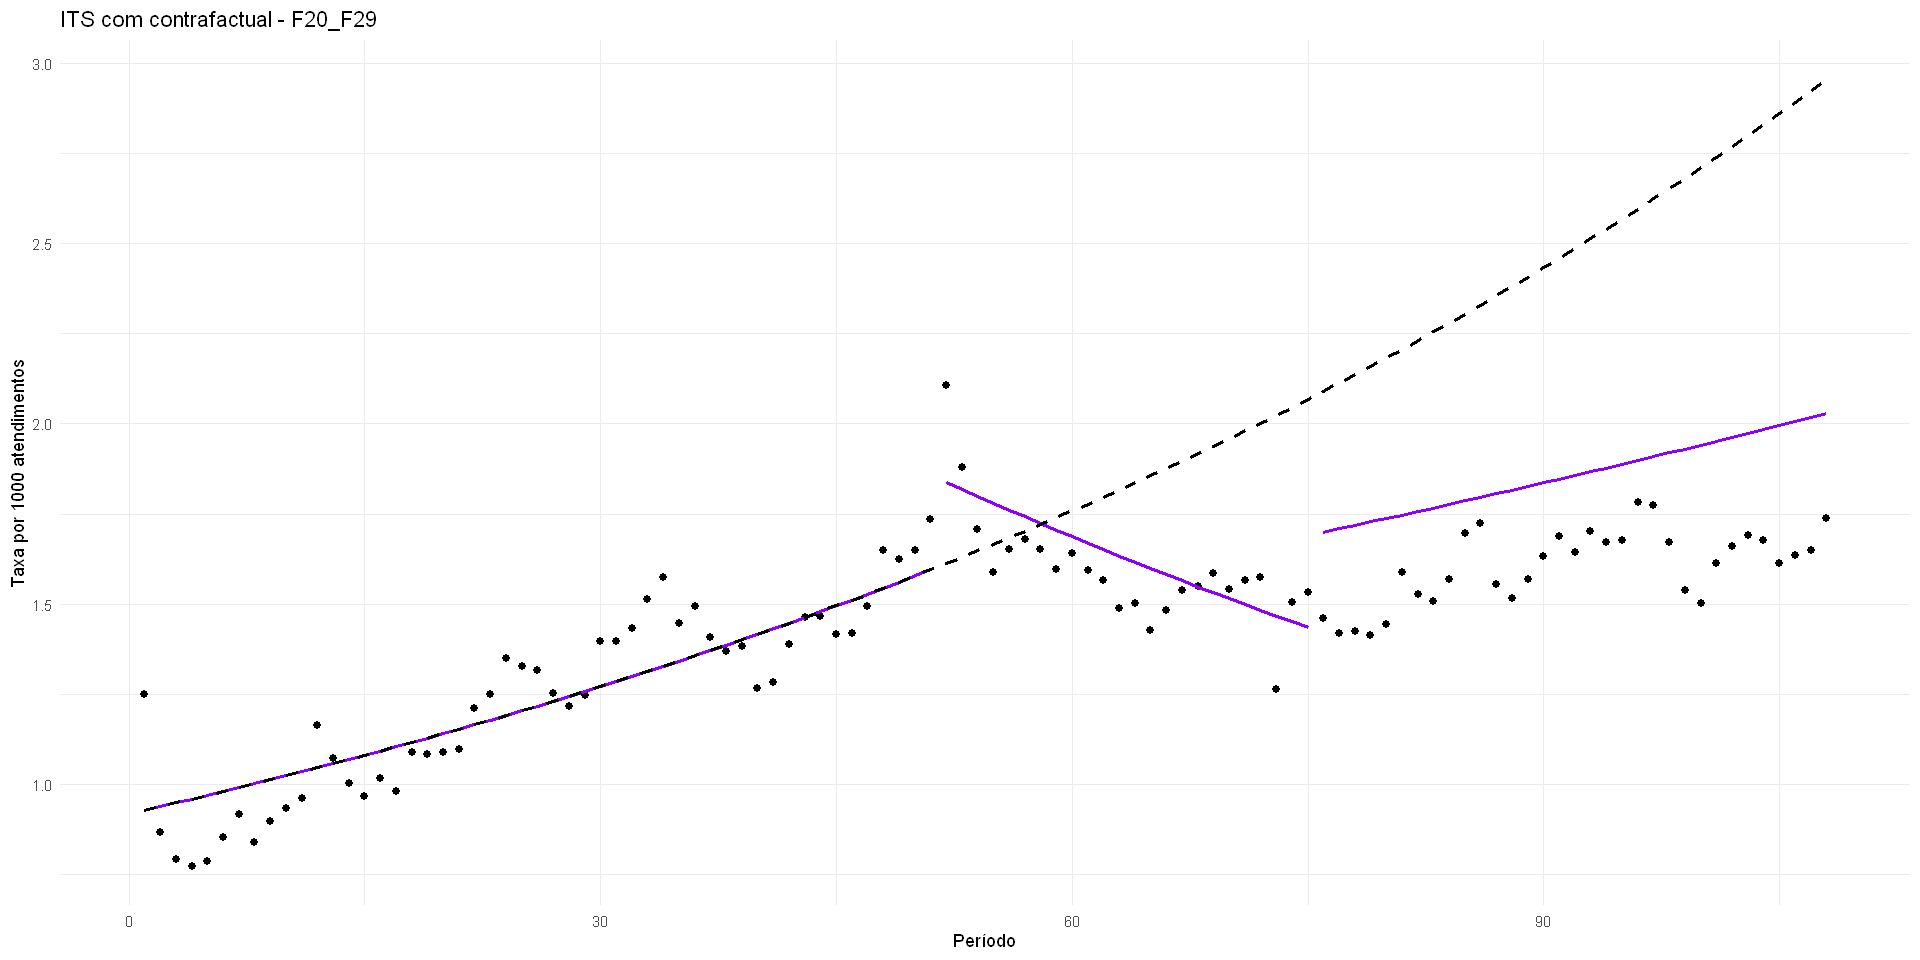

Plotando: Brasil 


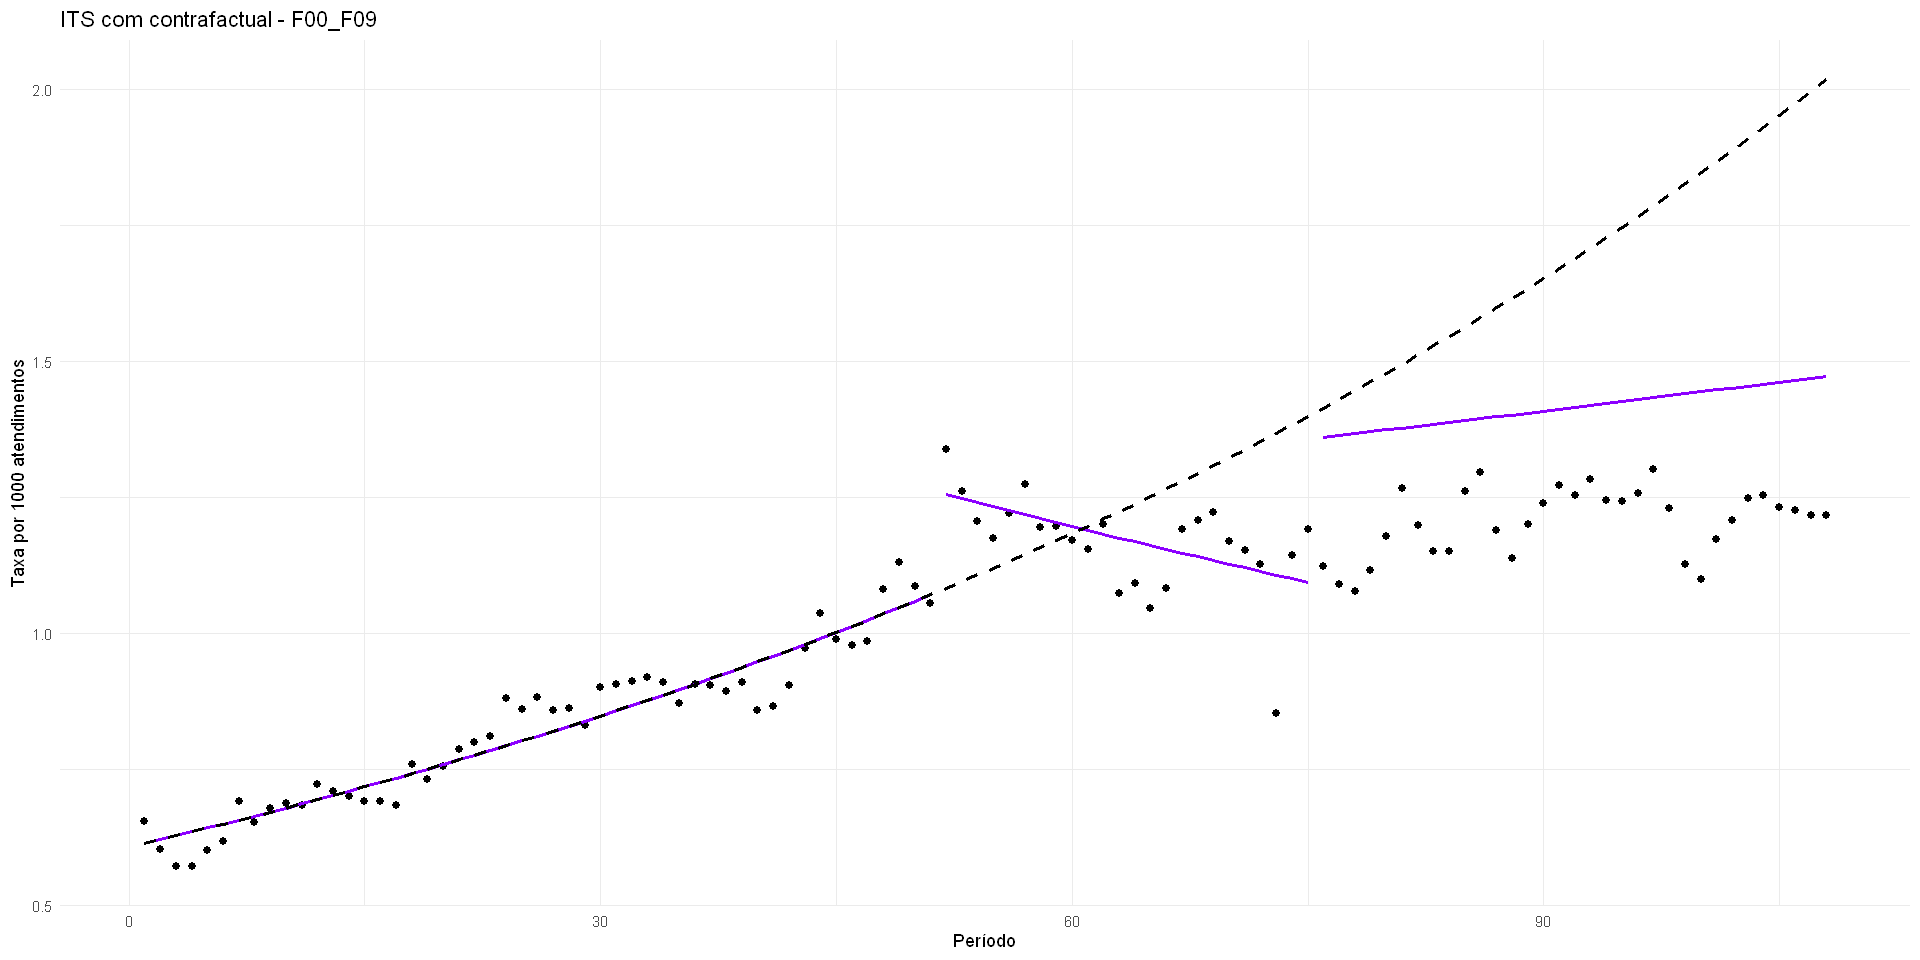

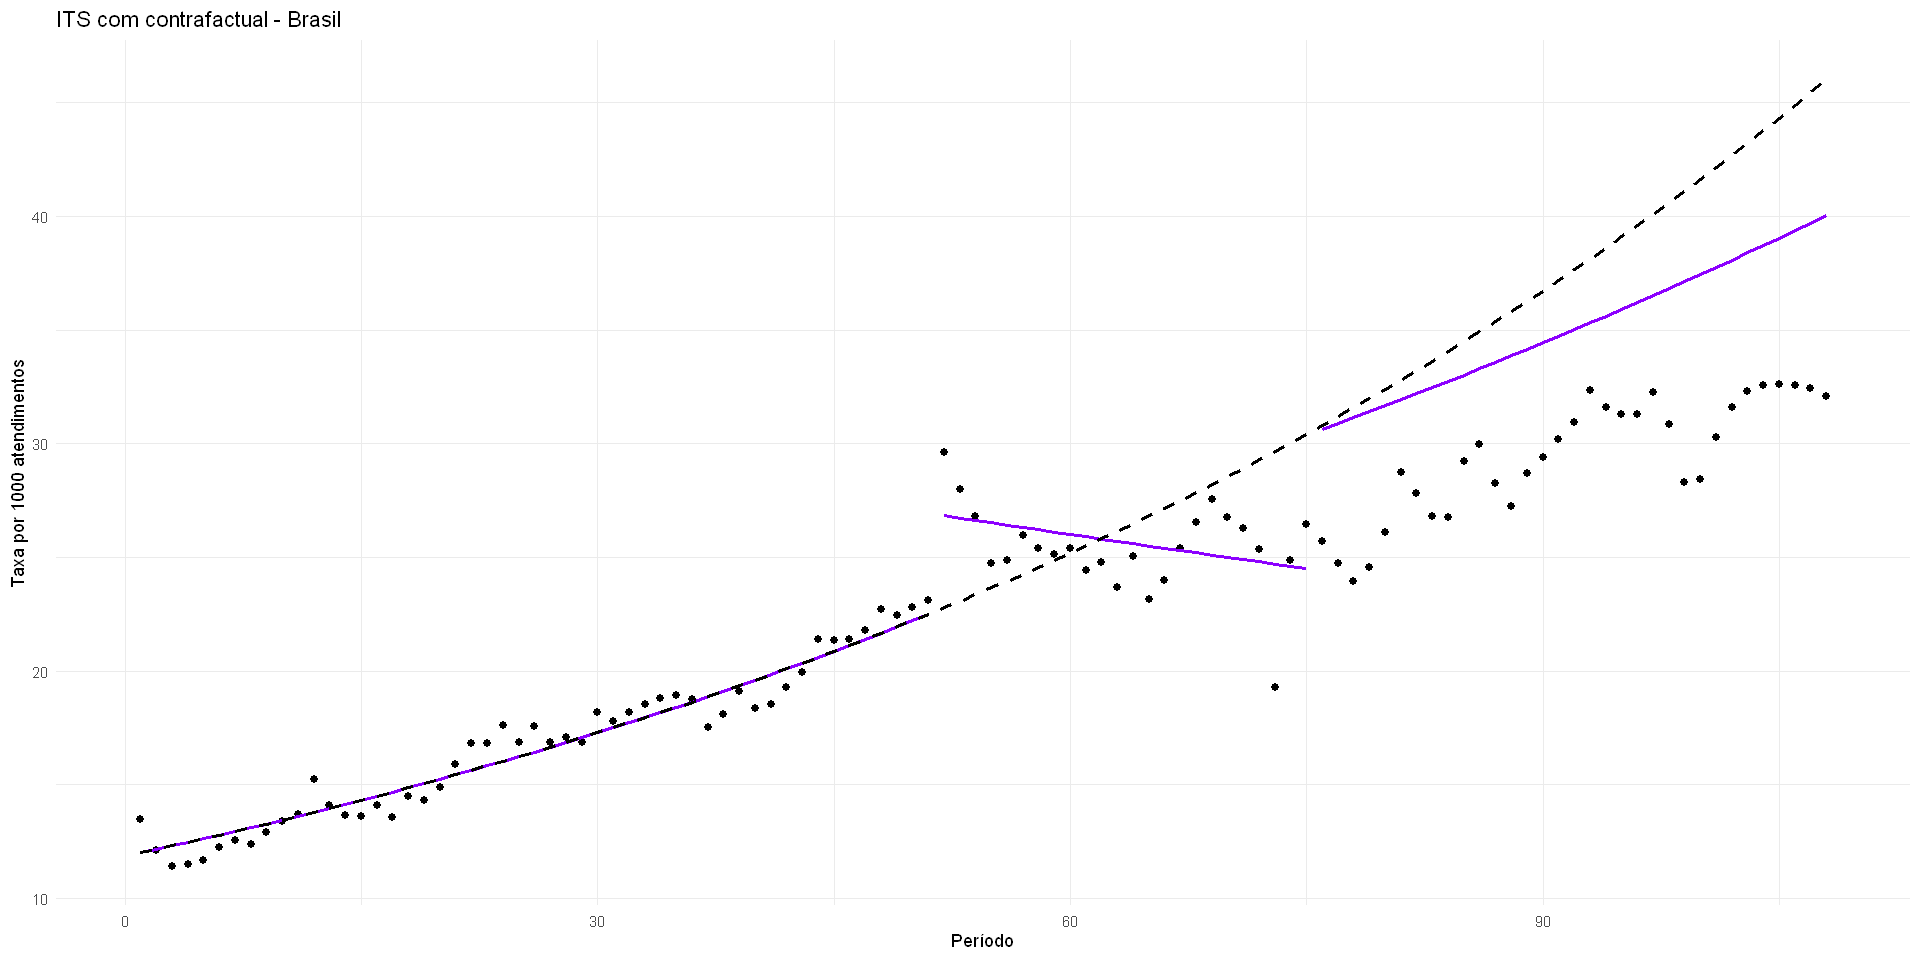

In [62]:
library(ggplot2)
library(dplyr)

for (reg in names(models_list)) {
  cat("Plotando:", reg, "\n")

  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        fase == "pos" ~ exp(intercept + b_pstep + b_poststep + b_time * periodo +
          b_ptrend * Pandemia_Trend + b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  p <- ggplot(reg_data, aes(x = periodo)) +
    geom_point(aes(y = IR), color = "black", size = 2) +
    geom_line(aes(y = predicted_segmented, group = fase), color = "#8c00ff", size = 1) + # <- QUEBRA AQUI
    geom_line(aes(y = predicted_counterfactual), color = "#000000", linetype = "dashed", size = 1) +
    labs(
      title = paste("ITS com contrafactual -", reg),
      y = "Taxa por 1000 atendimentos",
      x = "Período"
    ) +
    theme_minimal()

  print(p)
}
